In [1]:
import torchvision
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt
import pdb

In [2]:
DATADIR = '/data/codes/aiml/datastore_aiml/images/proj_binary_riz/'
PROCDIR = '/data/codes/aiml/projects_aiml/family_face_detection/process/'

In [3]:
image_dataset = torchvision.datasets.ImageFolder(
    root=DATADIR,
    transform=transforms.Compose([
        transforms.Resize((32,32)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ])
)

In [4]:
print('Number of samples: ', len(image_dataset))

Number of samples:  2098


In [5]:
image, label = image_dataset[1000]
print ('Image Size: ', image.size())
print ('Image Label: ', label)

Image Size:  torch.Size([1, 32, 32])
Image Label:  0


In [6]:
# Splitting dataset
train_split = 0.85
num_dataset = len(image_dataset)

indices = list(range(num_dataset))
split_idx = int(np.floor(train_split*num_dataset))

np.random.shuffle(indices)
train_idx, val_idx = indices[:split_idx], indices[split_idx:]

train_dataset = Subset(image_dataset, indices=train_idx)
val_dataset = Subset(image_dataset, indices=val_idx)

print('Train Dataset Num: ', len(train_dataset))
print('Validation Dataset Num: ', len(val_dataset))

Train Dataset Num:  1783
Validation Dataset Num:  315


In [7]:
# Setting Parameters for NN
params = {'batch_size': 16,
          'shuffle': True,
          'num_workers': 4}

train_generator = DataLoader(train_dataset, **params)
val_generator = DataLoader(val_dataset, **params)

print('Train Generator: ', len(train_generator))
print('Validation Generator: ', len(val_generator))

Train Generator:  112
Validation Generator:  20


In [8]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

In [9]:
class ConvNet(nn.Module):
    """ Convolution Neural Network """
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU())
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Sequential(
            nn.Linear(64*8*8, 128),
            nn.ReLU())
        self.fc2 = nn.Linear(128,2)
        
    def forward(self, inp):
        out = self.layer1(inp)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1) # Flatten dimension 64*8*8 (2D) to 1*4096 (1D)
        #out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        
        return out

In [10]:
class LeNet(nn.Module):
    """LeNet CNN"""
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, (5,5), padding=2)
        self.conv2 = nn.Conv2d(6, 16, (5,5))
        self.fc1   = nn.Linear(16*6*6, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 2)
    
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [11]:
def train(epoch, data, train_losses):
    for i, [image,label] in enumerate(data,0):
        image = image.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        predictions = net.forward(image)
        loss = criterion(predictions, label)
        loss.backward()
        optimizer.step()

        if i%10 == 0:
            print (f'EPOCH: {epoch+1} - BATCH: {i} - LOSS: {loss.item()}')
            train_losses.append(loss.item())

EPOCH: 1 - BATCH: 0 - LOSS: 0.7122323513031006
EPOCH: 1 - BATCH: 10 - LOSS: 0.7135377526283264
EPOCH: 1 - BATCH: 20 - LOSS: 0.7100562453269958
EPOCH: 1 - BATCH: 30 - LOSS: 0.7023075222969055
EPOCH: 1 - BATCH: 40 - LOSS: 0.7013040781021118
EPOCH: 1 - BATCH: 50 - LOSS: 0.6991008520126343
EPOCH: 1 - BATCH: 60 - LOSS: 0.6939172148704529
EPOCH: 1 - BATCH: 70 - LOSS: 0.6903082728385925
EPOCH: 1 - BATCH: 80 - LOSS: 0.6914434432983398
EPOCH: 1 - BATCH: 90 - LOSS: 0.686337411403656
EPOCH: 1 - BATCH: 100 - LOSS: 0.6827154159545898
EPOCH: 1 - BATCH: 110 - LOSS: 0.6790854334831238
EPOCH: 2 - BATCH: 0 - LOSS: 0.6745630502700806
EPOCH: 2 - BATCH: 10 - LOSS: 0.6706485748291016
EPOCH: 2 - BATCH: 20 - LOSS: 0.674542248249054
EPOCH: 2 - BATCH: 30 - LOSS: 0.6772905588150024
EPOCH: 2 - BATCH: 40 - LOSS: 0.6648467779159546
EPOCH: 2 - BATCH: 50 - LOSS: 0.661727249622345
EPOCH: 2 - BATCH: 60 - LOSS: 0.6520715951919556
EPOCH: 2 - BATCH: 70 - LOSS: 0.6613298654556274
EPOCH: 2 - BATCH: 80 - LOSS: 0.666929721832

EPOCH: 15 - BATCH: 20 - LOSS: 0.3479369878768921
EPOCH: 15 - BATCH: 30 - LOSS: 0.41172412037849426
EPOCH: 15 - BATCH: 40 - LOSS: 0.3981019854545593
EPOCH: 15 - BATCH: 50 - LOSS: 0.3998817205429077
EPOCH: 15 - BATCH: 60 - LOSS: 0.47307342290878296
EPOCH: 15 - BATCH: 70 - LOSS: 0.6297190189361572
EPOCH: 15 - BATCH: 80 - LOSS: 0.6538965106010437
EPOCH: 15 - BATCH: 90 - LOSS: 0.5775631070137024
EPOCH: 15 - BATCH: 100 - LOSS: 0.4724371135234833
EPOCH: 15 - BATCH: 110 - LOSS: 0.40787360072135925
EPOCH: 16 - BATCH: 0 - LOSS: 0.4852309823036194
EPOCH: 16 - BATCH: 10 - LOSS: 0.320553719997406
EPOCH: 16 - BATCH: 20 - LOSS: 0.5563362836837769
EPOCH: 16 - BATCH: 30 - LOSS: 0.3938470780849457
EPOCH: 16 - BATCH: 40 - LOSS: 0.45698052644729614
EPOCH: 16 - BATCH: 50 - LOSS: 0.4646208584308624
EPOCH: 16 - BATCH: 60 - LOSS: 0.23884128034114838
EPOCH: 16 - BATCH: 70 - LOSS: 0.3940691351890564
EPOCH: 16 - BATCH: 80 - LOSS: 0.4740889370441437
EPOCH: 16 - BATCH: 90 - LOSS: 0.4685337543487549
EPOCH: 16 - BAT

EPOCH: 29 - BATCH: 60 - LOSS: 0.7639071345329285
EPOCH: 29 - BATCH: 70 - LOSS: 0.39510729908943176
EPOCH: 29 - BATCH: 80 - LOSS: 0.7765716910362244
EPOCH: 29 - BATCH: 90 - LOSS: 0.4418199956417084
EPOCH: 29 - BATCH: 100 - LOSS: 1.202426791191101
EPOCH: 29 - BATCH: 110 - LOSS: 0.358921617269516
EPOCH: 30 - BATCH: 0 - LOSS: 0.5928641557693481
EPOCH: 30 - BATCH: 10 - LOSS: 0.26886695623397827
EPOCH: 30 - BATCH: 20 - LOSS: 0.2759202718734741
EPOCH: 30 - BATCH: 30 - LOSS: 0.1713850200176239
EPOCH: 30 - BATCH: 40 - LOSS: 0.3870565593242645
EPOCH: 30 - BATCH: 50 - LOSS: 0.26968082785606384
EPOCH: 30 - BATCH: 60 - LOSS: 0.6850258111953735
EPOCH: 30 - BATCH: 70 - LOSS: 0.5810078978538513
EPOCH: 30 - BATCH: 80 - LOSS: 0.4693695902824402
EPOCH: 30 - BATCH: 90 - LOSS: 0.4819464087486267
EPOCH: 30 - BATCH: 100 - LOSS: 0.2853354215621948
EPOCH: 30 - BATCH: 110 - LOSS: 0.5699414014816284
EPOCH: 31 - BATCH: 0 - LOSS: 0.38738444447517395
EPOCH: 31 - BATCH: 10 - LOSS: 0.5013859272003174
EPOCH: 31 - BATC

EPOCH: 43 - BATCH: 60 - LOSS: 0.1910860538482666
EPOCH: 43 - BATCH: 70 - LOSS: 0.38705047965049744
EPOCH: 43 - BATCH: 80 - LOSS: 0.3699486553668976
EPOCH: 43 - BATCH: 90 - LOSS: 0.41985270380973816
EPOCH: 43 - BATCH: 100 - LOSS: 0.380974680185318
EPOCH: 43 - BATCH: 110 - LOSS: 0.3415035307407379
EPOCH: 44 - BATCH: 0 - LOSS: 0.5896823406219482
EPOCH: 44 - BATCH: 10 - LOSS: 0.3554847538471222
EPOCH: 44 - BATCH: 20 - LOSS: 0.4661925435066223
EPOCH: 44 - BATCH: 30 - LOSS: 0.37202516198158264
EPOCH: 44 - BATCH: 40 - LOSS: 0.3727552592754364
EPOCH: 44 - BATCH: 50 - LOSS: 0.27735909819602966
EPOCH: 44 - BATCH: 60 - LOSS: 0.28708896040916443
EPOCH: 44 - BATCH: 70 - LOSS: 0.37740394473075867
EPOCH: 44 - BATCH: 80 - LOSS: 0.5682796239852905
EPOCH: 44 - BATCH: 90 - LOSS: 0.49164414405822754
EPOCH: 44 - BATCH: 100 - LOSS: 0.3688162565231323
EPOCH: 44 - BATCH: 110 - LOSS: 0.6161516904830933
EPOCH: 45 - BATCH: 0 - LOSS: 0.5639916658401489
EPOCH: 45 - BATCH: 10 - LOSS: 0.5699139833450317
EPOCH: 45 - 

EPOCH: 57 - BATCH: 60 - LOSS: 0.4542907178401947
EPOCH: 57 - BATCH: 70 - LOSS: 0.26971006393432617
EPOCH: 57 - BATCH: 80 - LOSS: 0.5771535038948059
EPOCH: 57 - BATCH: 90 - LOSS: 0.2858230471611023
EPOCH: 57 - BATCH: 100 - LOSS: 0.25093144178390503
EPOCH: 57 - BATCH: 110 - LOSS: 0.1754569709300995
EPOCH: 58 - BATCH: 0 - LOSS: 0.5635249614715576
EPOCH: 58 - BATCH: 10 - LOSS: 0.5329274535179138
EPOCH: 58 - BATCH: 20 - LOSS: 0.4611414670944214
EPOCH: 58 - BATCH: 30 - LOSS: 0.2698555886745453
EPOCH: 58 - BATCH: 40 - LOSS: 0.45596686005592346
EPOCH: 58 - BATCH: 50 - LOSS: 0.27753156423568726
EPOCH: 58 - BATCH: 60 - LOSS: 0.7472557425498962
EPOCH: 58 - BATCH: 70 - LOSS: 0.47242510318756104
EPOCH: 58 - BATCH: 80 - LOSS: 0.7521548271179199
EPOCH: 58 - BATCH: 90 - LOSS: 0.2554247975349426
EPOCH: 58 - BATCH: 100 - LOSS: 0.5882977843284607
EPOCH: 58 - BATCH: 110 - LOSS: 0.4681638181209564
EPOCH: 59 - BATCH: 0 - LOSS: 0.4823048412799835
EPOCH: 59 - BATCH: 10 - LOSS: 0.4553326964378357
EPOCH: 59 - B

EPOCH: 71 - BATCH: 60 - LOSS: 0.1636286824941635
EPOCH: 71 - BATCH: 70 - LOSS: 0.3339504599571228
EPOCH: 71 - BATCH: 80 - LOSS: 0.4431261420249939
EPOCH: 71 - BATCH: 90 - LOSS: 0.5439624786376953
EPOCH: 71 - BATCH: 100 - LOSS: 0.570952832698822
EPOCH: 71 - BATCH: 110 - LOSS: 0.555388867855072
EPOCH: 72 - BATCH: 0 - LOSS: 0.6370077133178711
EPOCH: 72 - BATCH: 10 - LOSS: 0.3625306189060211
EPOCH: 72 - BATCH: 20 - LOSS: 0.2473120093345642
EPOCH: 72 - BATCH: 30 - LOSS: 0.44952595233917236
EPOCH: 72 - BATCH: 40 - LOSS: 0.4957104027271271
EPOCH: 72 - BATCH: 50 - LOSS: 0.2695351541042328
EPOCH: 72 - BATCH: 60 - LOSS: 0.43211498856544495
EPOCH: 72 - BATCH: 70 - LOSS: 0.5753811597824097
EPOCH: 72 - BATCH: 80 - LOSS: 0.399949312210083
EPOCH: 72 - BATCH: 90 - LOSS: 0.49503016471862793
EPOCH: 72 - BATCH: 100 - LOSS: 0.35147824883461
EPOCH: 72 - BATCH: 110 - LOSS: 0.34680524468421936
EPOCH: 73 - BATCH: 0 - LOSS: 0.5780242085456848
EPOCH: 73 - BATCH: 10 - LOSS: 0.5479564666748047
EPOCH: 73 - BATCH: 

EPOCH: 85 - BATCH: 60 - LOSS: 0.37680527567863464
EPOCH: 85 - BATCH: 70 - LOSS: 0.24205468595027924
EPOCH: 85 - BATCH: 80 - LOSS: 0.25227072834968567
EPOCH: 85 - BATCH: 90 - LOSS: 0.28030022978782654
EPOCH: 85 - BATCH: 100 - LOSS: 0.4515020549297333
EPOCH: 85 - BATCH: 110 - LOSS: 0.4540814161300659
EPOCH: 86 - BATCH: 0 - LOSS: 0.15442781150341034
EPOCH: 86 - BATCH: 10 - LOSS: 0.5435740351676941
EPOCH: 86 - BATCH: 20 - LOSS: 0.5635469555854797
EPOCH: 86 - BATCH: 30 - LOSS: 0.4104917049407959
EPOCH: 86 - BATCH: 40 - LOSS: 0.47423604130744934
EPOCH: 86 - BATCH: 50 - LOSS: 0.3454751670360565
EPOCH: 86 - BATCH: 60 - LOSS: 0.5274863839149475
EPOCH: 86 - BATCH: 70 - LOSS: 0.53437739610672
EPOCH: 86 - BATCH: 80 - LOSS: 0.41922831535339355
EPOCH: 86 - BATCH: 90 - LOSS: 0.6959829330444336
EPOCH: 86 - BATCH: 100 - LOSS: 0.2581091523170471
EPOCH: 86 - BATCH: 110 - LOSS: 0.43380939960479736
EPOCH: 87 - BATCH: 0 - LOSS: 0.4598948359489441
EPOCH: 87 - BATCH: 10 - LOSS: 0.25293466448783875
EPOCH: 87 -

EPOCH: 99 - BATCH: 60 - LOSS: 0.3524830937385559
EPOCH: 99 - BATCH: 70 - LOSS: 0.2595299482345581
EPOCH: 99 - BATCH: 80 - LOSS: 0.5805719494819641
EPOCH: 99 - BATCH: 90 - LOSS: 0.5318260788917542
EPOCH: 99 - BATCH: 100 - LOSS: 0.3358069360256195
EPOCH: 99 - BATCH: 110 - LOSS: 0.40996962785720825
EPOCH: 100 - BATCH: 0 - LOSS: 0.4040190577507019
EPOCH: 100 - BATCH: 10 - LOSS: 0.4601711630821228
EPOCH: 100 - BATCH: 20 - LOSS: 0.361814945936203
EPOCH: 100 - BATCH: 30 - LOSS: 0.3221129775047302
EPOCH: 100 - BATCH: 40 - LOSS: 0.36565104126930237
EPOCH: 100 - BATCH: 50 - LOSS: 0.41502660512924194
EPOCH: 100 - BATCH: 60 - LOSS: 0.2859354019165039
EPOCH: 100 - BATCH: 70 - LOSS: 0.5427773594856262
EPOCH: 100 - BATCH: 80 - LOSS: 0.43833428621292114
EPOCH: 100 - BATCH: 90 - LOSS: 0.4597470164299011
EPOCH: 100 - BATCH: 100 - LOSS: 0.4566027522087097
EPOCH: 100 - BATCH: 110 - LOSS: 0.43573227524757385
EPOCH: 101 - BATCH: 0 - LOSS: 0.4954732060432434
EPOCH: 101 - BATCH: 10 - LOSS: 0.23750503361225128

EPOCH: 113 - BATCH: 60 - LOSS: 0.30454063415527344
EPOCH: 113 - BATCH: 70 - LOSS: 0.23305054008960724
EPOCH: 113 - BATCH: 80 - LOSS: 0.29655399918556213
EPOCH: 113 - BATCH: 90 - LOSS: 0.21887478232383728
EPOCH: 113 - BATCH: 100 - LOSS: 0.4184030294418335
EPOCH: 113 - BATCH: 110 - LOSS: 0.28388750553131104
EPOCH: 114 - BATCH: 0 - LOSS: 0.7502186298370361
EPOCH: 114 - BATCH: 10 - LOSS: 0.4634897708892822
EPOCH: 114 - BATCH: 20 - LOSS: 0.34904587268829346
EPOCH: 114 - BATCH: 30 - LOSS: 0.4281318783760071
EPOCH: 114 - BATCH: 40 - LOSS: 0.3159683644771576
EPOCH: 114 - BATCH: 50 - LOSS: 0.18378053605556488
EPOCH: 114 - BATCH: 60 - LOSS: 0.23216646909713745
EPOCH: 114 - BATCH: 70 - LOSS: 0.4458155333995819
EPOCH: 114 - BATCH: 80 - LOSS: 0.40307798981666565
EPOCH: 114 - BATCH: 90 - LOSS: 0.2713187038898468
EPOCH: 114 - BATCH: 100 - LOSS: 0.17461243271827698
EPOCH: 114 - BATCH: 110 - LOSS: 0.37226033210754395
EPOCH: 115 - BATCH: 0 - LOSS: 0.4395095109939575
EPOCH: 115 - BATCH: 10 - LOSS: 0.2872

EPOCH: 127 - BATCH: 60 - LOSS: 0.20113183557987213
EPOCH: 127 - BATCH: 70 - LOSS: 0.35417234897613525
EPOCH: 127 - BATCH: 80 - LOSS: 0.5011674761772156
EPOCH: 127 - BATCH: 90 - LOSS: 0.3987922668457031
EPOCH: 127 - BATCH: 100 - LOSS: 0.5175455212593079
EPOCH: 127 - BATCH: 110 - LOSS: 0.35738831758499146
EPOCH: 128 - BATCH: 0 - LOSS: 0.2048676460981369
EPOCH: 128 - BATCH: 10 - LOSS: 0.3936847448348999
EPOCH: 128 - BATCH: 20 - LOSS: 0.4281690716743469
EPOCH: 128 - BATCH: 30 - LOSS: 0.45041918754577637
EPOCH: 128 - BATCH: 40 - LOSS: 0.28439879417419434
EPOCH: 128 - BATCH: 50 - LOSS: 0.389926552772522
EPOCH: 128 - BATCH: 60 - LOSS: 0.4583713710308075
EPOCH: 128 - BATCH: 70 - LOSS: 0.329100638628006
EPOCH: 128 - BATCH: 80 - LOSS: 0.341346800327301
EPOCH: 128 - BATCH: 90 - LOSS: 0.6731643676757812
EPOCH: 128 - BATCH: 100 - LOSS: 0.19793757796287537
EPOCH: 128 - BATCH: 110 - LOSS: 0.40439674258232117
EPOCH: 129 - BATCH: 0 - LOSS: 0.5418463945388794
EPOCH: 129 - BATCH: 10 - LOSS: 0.74875879287

EPOCH: 141 - BATCH: 60 - LOSS: 0.34399479627609253
EPOCH: 141 - BATCH: 70 - LOSS: 0.3335994482040405
EPOCH: 141 - BATCH: 80 - LOSS: 0.36643949151039124
EPOCH: 141 - BATCH: 90 - LOSS: 0.5678840279579163
EPOCH: 141 - BATCH: 100 - LOSS: 0.23530898988246918
EPOCH: 141 - BATCH: 110 - LOSS: 0.2305939495563507
EPOCH: 142 - BATCH: 0 - LOSS: 0.22104771435260773
EPOCH: 142 - BATCH: 10 - LOSS: 0.44611886143684387
EPOCH: 142 - BATCH: 20 - LOSS: 0.240982323884964
EPOCH: 142 - BATCH: 30 - LOSS: 0.19116553664207458
EPOCH: 142 - BATCH: 40 - LOSS: 0.38820570707321167
EPOCH: 142 - BATCH: 50 - LOSS: 0.08828768134117126
EPOCH: 142 - BATCH: 60 - LOSS: 0.3753737509250641
EPOCH: 142 - BATCH: 70 - LOSS: 0.22123366594314575
EPOCH: 142 - BATCH: 80 - LOSS: 0.3108961880207062
EPOCH: 142 - BATCH: 90 - LOSS: 0.24783392250537872
EPOCH: 142 - BATCH: 100 - LOSS: 0.2715713381767273
EPOCH: 142 - BATCH: 110 - LOSS: 0.21320679783821106
EPOCH: 143 - BATCH: 0 - LOSS: 0.17315596342086792
EPOCH: 143 - BATCH: 10 - LOSS: 0.4821

EPOCH: 155 - BATCH: 0 - LOSS: 0.11292111873626709
EPOCH: 155 - BATCH: 10 - LOSS: 0.1690089851617813
EPOCH: 155 - BATCH: 20 - LOSS: 0.21696358919143677
EPOCH: 155 - BATCH: 30 - LOSS: 0.36048322916030884
EPOCH: 155 - BATCH: 40 - LOSS: 0.30508625507354736
EPOCH: 155 - BATCH: 50 - LOSS: 0.13134320080280304
EPOCH: 155 - BATCH: 60 - LOSS: 0.2900221645832062
EPOCH: 155 - BATCH: 70 - LOSS: 0.2073805034160614
EPOCH: 155 - BATCH: 80 - LOSS: 0.1341514140367508
EPOCH: 155 - BATCH: 90 - LOSS: 0.13716451823711395
EPOCH: 155 - BATCH: 100 - LOSS: 0.2261173278093338
EPOCH: 155 - BATCH: 110 - LOSS: 0.4690535366535187
EPOCH: 156 - BATCH: 0 - LOSS: 0.06451697647571564
EPOCH: 156 - BATCH: 10 - LOSS: 0.2601705491542816
EPOCH: 156 - BATCH: 20 - LOSS: 0.2940952181816101
EPOCH: 156 - BATCH: 30 - LOSS: 0.14886806905269623
EPOCH: 156 - BATCH: 40 - LOSS: 0.3315299153327942
EPOCH: 156 - BATCH: 50 - LOSS: 0.30083492398262024
EPOCH: 156 - BATCH: 60 - LOSS: 0.25914230942726135
EPOCH: 156 - BATCH: 70 - LOSS: 0.3205366

EPOCH: 169 - BATCH: 0 - LOSS: 0.42636412382125854
EPOCH: 169 - BATCH: 10 - LOSS: 0.08474420011043549
EPOCH: 169 - BATCH: 20 - LOSS: 0.4753314256668091
EPOCH: 169 - BATCH: 30 - LOSS: 0.1840263307094574
EPOCH: 169 - BATCH: 40 - LOSS: 0.26732245087623596
EPOCH: 169 - BATCH: 50 - LOSS: 0.4083988070487976
EPOCH: 169 - BATCH: 60 - LOSS: 0.22040092945098877
EPOCH: 169 - BATCH: 70 - LOSS: 0.3172231614589691
EPOCH: 169 - BATCH: 80 - LOSS: 0.06405598670244217
EPOCH: 169 - BATCH: 90 - LOSS: 0.10155729204416275
EPOCH: 169 - BATCH: 100 - LOSS: 0.31956252455711365
EPOCH: 169 - BATCH: 110 - LOSS: 0.5567551255226135
EPOCH: 170 - BATCH: 0 - LOSS: 0.14336560666561127
EPOCH: 170 - BATCH: 10 - LOSS: 0.3326971232891083
EPOCH: 170 - BATCH: 20 - LOSS: 0.29396167397499084
EPOCH: 170 - BATCH: 30 - LOSS: 0.1633150577545166
EPOCH: 170 - BATCH: 40 - LOSS: 0.413135290145874
EPOCH: 170 - BATCH: 50 - LOSS: 0.35447201132774353
EPOCH: 170 - BATCH: 60 - LOSS: 0.40683481097221375
EPOCH: 170 - BATCH: 70 - LOSS: 0.4584830

EPOCH: 183 - BATCH: 0 - LOSS: 0.32236915826797485
EPOCH: 183 - BATCH: 10 - LOSS: 0.13359178602695465
EPOCH: 183 - BATCH: 20 - LOSS: 0.30118539929389954
EPOCH: 183 - BATCH: 30 - LOSS: 0.6183581352233887
EPOCH: 183 - BATCH: 40 - LOSS: 0.10342878103256226
EPOCH: 183 - BATCH: 50 - LOSS: 0.3796318769454956
EPOCH: 183 - BATCH: 60 - LOSS: 0.19331736862659454
EPOCH: 183 - BATCH: 70 - LOSS: 0.18056294322013855
EPOCH: 183 - BATCH: 80 - LOSS: 0.31881532073020935
EPOCH: 183 - BATCH: 90 - LOSS: 0.23976682126522064
EPOCH: 183 - BATCH: 100 - LOSS: 0.11387083679437637
EPOCH: 183 - BATCH: 110 - LOSS: 0.06605052947998047
EPOCH: 184 - BATCH: 0 - LOSS: 0.32787543535232544
EPOCH: 184 - BATCH: 10 - LOSS: 0.30516794323921204
EPOCH: 184 - BATCH: 20 - LOSS: 0.5152623057365417
EPOCH: 184 - BATCH: 30 - LOSS: 0.28591394424438477
EPOCH: 184 - BATCH: 40 - LOSS: 0.3890380859375
EPOCH: 184 - BATCH: 50 - LOSS: 0.43540236353874207
EPOCH: 184 - BATCH: 60 - LOSS: 0.357481449842453
EPOCH: 184 - BATCH: 70 - LOSS: 0.3471847

EPOCH: 196 - BATCH: 60 - LOSS: 0.24766360223293304
EPOCH: 196 - BATCH: 70 - LOSS: 0.2419814169406891
EPOCH: 196 - BATCH: 80 - LOSS: 0.09994617849588394
EPOCH: 196 - BATCH: 90 - LOSS: 0.297766774892807
EPOCH: 196 - BATCH: 100 - LOSS: 0.3386247754096985
EPOCH: 196 - BATCH: 110 - LOSS: 0.2427452653646469
EPOCH: 197 - BATCH: 0 - LOSS: 0.1643376499414444
EPOCH: 197 - BATCH: 10 - LOSS: 0.35821112990379333
EPOCH: 197 - BATCH: 20 - LOSS: 0.3865228295326233
EPOCH: 197 - BATCH: 30 - LOSS: 0.15195581316947937
EPOCH: 197 - BATCH: 40 - LOSS: 0.18271899223327637
EPOCH: 197 - BATCH: 50 - LOSS: 0.3233693540096283
EPOCH: 197 - BATCH: 60 - LOSS: 0.17778955399990082
EPOCH: 197 - BATCH: 70 - LOSS: 0.22413814067840576
EPOCH: 197 - BATCH: 80 - LOSS: 0.2900407314300537
EPOCH: 197 - BATCH: 90 - LOSS: 0.23328378796577454
EPOCH: 197 - BATCH: 100 - LOSS: 0.23905722796916962
EPOCH: 197 - BATCH: 110 - LOSS: 0.39286524057388306
EPOCH: 198 - BATCH: 0 - LOSS: 0.19428440928459167
EPOCH: 198 - BATCH: 10 - LOSS: 0.42679

EPOCH: 210 - BATCH: 0 - LOSS: 0.16414499282836914
EPOCH: 210 - BATCH: 10 - LOSS: 0.18932878971099854
EPOCH: 210 - BATCH: 20 - LOSS: 0.23053200542926788
EPOCH: 210 - BATCH: 30 - LOSS: 0.10508262366056442
EPOCH: 210 - BATCH: 40 - LOSS: 0.14657112956047058
EPOCH: 210 - BATCH: 50 - LOSS: 0.7049633860588074
EPOCH: 210 - BATCH: 60 - LOSS: 0.2040041834115982
EPOCH: 210 - BATCH: 70 - LOSS: 0.24698740243911743
EPOCH: 210 - BATCH: 80 - LOSS: 0.2847871780395508
EPOCH: 210 - BATCH: 90 - LOSS: 0.06548619270324707
EPOCH: 210 - BATCH: 100 - LOSS: 0.44922447204589844
EPOCH: 210 - BATCH: 110 - LOSS: 0.2975063621997833
EPOCH: 211 - BATCH: 0 - LOSS: 0.24213667213916779
EPOCH: 211 - BATCH: 10 - LOSS: 0.2219334840774536
EPOCH: 211 - BATCH: 20 - LOSS: 0.21139837801456451
EPOCH: 211 - BATCH: 30 - LOSS: 0.28417712450027466
EPOCH: 211 - BATCH: 40 - LOSS: 0.1500352919101715
EPOCH: 211 - BATCH: 50 - LOSS: 0.07078097760677338
EPOCH: 211 - BATCH: 60 - LOSS: 0.054593779146671295
EPOCH: 211 - BATCH: 70 - LOSS: 0.280

EPOCH: 224 - BATCH: 0 - LOSS: 0.09598952531814575
EPOCH: 224 - BATCH: 10 - LOSS: 0.34501588344573975
EPOCH: 224 - BATCH: 20 - LOSS: 0.24243442714214325
EPOCH: 224 - BATCH: 30 - LOSS: 0.22780433297157288
EPOCH: 224 - BATCH: 40 - LOSS: 0.21923385560512543
EPOCH: 224 - BATCH: 50 - LOSS: 0.29660192131996155
EPOCH: 224 - BATCH: 60 - LOSS: 0.19974832236766815
EPOCH: 224 - BATCH: 70 - LOSS: 0.26343995332717896
EPOCH: 224 - BATCH: 80 - LOSS: 0.20259828865528107
EPOCH: 224 - BATCH: 90 - LOSS: 0.3921251893043518
EPOCH: 224 - BATCH: 100 - LOSS: 0.16133610904216766
EPOCH: 224 - BATCH: 110 - LOSS: 0.20458199083805084
EPOCH: 225 - BATCH: 0 - LOSS: 0.38807493448257446
EPOCH: 225 - BATCH: 10 - LOSS: 0.2008119523525238
EPOCH: 225 - BATCH: 20 - LOSS: 0.47340744733810425
EPOCH: 225 - BATCH: 30 - LOSS: 0.15603771805763245
EPOCH: 225 - BATCH: 40 - LOSS: 0.19884586334228516
EPOCH: 225 - BATCH: 50 - LOSS: 0.20524460077285767
EPOCH: 225 - BATCH: 60 - LOSS: 0.2376900464296341
EPOCH: 225 - BATCH: 70 - LOSS: 0.1

EPOCH: 238 - BATCH: 0 - LOSS: 0.08214487880468369
EPOCH: 238 - BATCH: 10 - LOSS: 0.0855327844619751
EPOCH: 238 - BATCH: 20 - LOSS: 0.30236536264419556
EPOCH: 238 - BATCH: 30 - LOSS: 0.2177787721157074
EPOCH: 238 - BATCH: 40 - LOSS: 0.4060419797897339
EPOCH: 238 - BATCH: 50 - LOSS: 0.09871501475572586
EPOCH: 238 - BATCH: 60 - LOSS: 0.17726527154445648
EPOCH: 238 - BATCH: 70 - LOSS: 0.16333214938640594
EPOCH: 238 - BATCH: 80 - LOSS: 0.33600640296936035
EPOCH: 238 - BATCH: 90 - LOSS: 0.31333664059638977
EPOCH: 238 - BATCH: 100 - LOSS: 0.30312857031822205
EPOCH: 238 - BATCH: 110 - LOSS: 0.34420526027679443
EPOCH: 239 - BATCH: 0 - LOSS: 0.4338393807411194
EPOCH: 239 - BATCH: 10 - LOSS: 0.24113348126411438
EPOCH: 239 - BATCH: 20 - LOSS: 0.3024485111236572
EPOCH: 239 - BATCH: 30 - LOSS: 0.08610799908638
EPOCH: 239 - BATCH: 40 - LOSS: 0.4145965278148651
EPOCH: 239 - BATCH: 50 - LOSS: 0.20618964731693268
EPOCH: 239 - BATCH: 60 - LOSS: 0.3739009201526642
EPOCH: 239 - BATCH: 70 - LOSS: 0.00988425

EPOCH: 252 - BATCH: 0 - LOSS: 0.3022821843624115
EPOCH: 252 - BATCH: 10 - LOSS: 0.13700315356254578
EPOCH: 252 - BATCH: 20 - LOSS: 0.24795611202716827
EPOCH: 252 - BATCH: 30 - LOSS: 0.22615128755569458
EPOCH: 252 - BATCH: 40 - LOSS: 0.11481127142906189
EPOCH: 252 - BATCH: 50 - LOSS: 0.06301941722631454
EPOCH: 252 - BATCH: 60 - LOSS: 0.13651563227176666
EPOCH: 252 - BATCH: 70 - LOSS: 0.506653904914856
EPOCH: 252 - BATCH: 80 - LOSS: 0.1307556927204132
EPOCH: 252 - BATCH: 90 - LOSS: 0.10133689641952515
EPOCH: 252 - BATCH: 100 - LOSS: 0.39795953035354614
EPOCH: 252 - BATCH: 110 - LOSS: 0.14537136256694794
EPOCH: 253 - BATCH: 0 - LOSS: 0.22744260728359222
EPOCH: 253 - BATCH: 10 - LOSS: 0.3599227964878082
EPOCH: 253 - BATCH: 20 - LOSS: 0.3576848804950714
EPOCH: 253 - BATCH: 30 - LOSS: 0.20178666710853577
EPOCH: 253 - BATCH: 40 - LOSS: 0.262645959854126
EPOCH: 253 - BATCH: 50 - LOSS: 0.18868112564086914
EPOCH: 253 - BATCH: 60 - LOSS: 0.12439505010843277
EPOCH: 253 - BATCH: 70 - LOSS: 0.417550

EPOCH: 265 - BATCH: 60 - LOSS: 0.12333062291145325
EPOCH: 265 - BATCH: 70 - LOSS: 0.2632749378681183
EPOCH: 265 - BATCH: 80 - LOSS: 0.04109305143356323
EPOCH: 265 - BATCH: 90 - LOSS: 0.18405745923519135
EPOCH: 265 - BATCH: 100 - LOSS: 0.2390616238117218
EPOCH: 265 - BATCH: 110 - LOSS: 0.16763608157634735
EPOCH: 266 - BATCH: 0 - LOSS: 0.250993013381958
EPOCH: 266 - BATCH: 10 - LOSS: 0.21771420538425446
EPOCH: 266 - BATCH: 20 - LOSS: 0.4450579583644867
EPOCH: 266 - BATCH: 30 - LOSS: 0.041176434606313705
EPOCH: 266 - BATCH: 40 - LOSS: 0.14479151368141174
EPOCH: 266 - BATCH: 50 - LOSS: 0.247615784406662
EPOCH: 266 - BATCH: 60 - LOSS: 0.3710184693336487
EPOCH: 266 - BATCH: 70 - LOSS: 0.38462939858436584
EPOCH: 266 - BATCH: 80 - LOSS: 0.15883606672286987
EPOCH: 266 - BATCH: 90 - LOSS: 0.1689043492078781
EPOCH: 266 - BATCH: 100 - LOSS: 0.20805543661117554
EPOCH: 266 - BATCH: 110 - LOSS: 0.2667894959449768
EPOCH: 267 - BATCH: 0 - LOSS: 0.08061223477125168
EPOCH: 267 - BATCH: 10 - LOSS: 0.21357

EPOCH: 279 - BATCH: 0 - LOSS: 0.16374698281288147
EPOCH: 279 - BATCH: 10 - LOSS: 0.30883827805519104
EPOCH: 279 - BATCH: 20 - LOSS: 0.13565005362033844
EPOCH: 279 - BATCH: 30 - LOSS: 0.1443028450012207
EPOCH: 279 - BATCH: 40 - LOSS: 0.14627738296985626
EPOCH: 279 - BATCH: 50 - LOSS: 0.2597690224647522
EPOCH: 279 - BATCH: 60 - LOSS: 0.26598531007766724
EPOCH: 279 - BATCH: 70 - LOSS: 0.7534508109092712
EPOCH: 279 - BATCH: 80 - LOSS: 0.26465219259262085
EPOCH: 279 - BATCH: 90 - LOSS: 0.1449735164642334
EPOCH: 279 - BATCH: 100 - LOSS: 0.26000604033470154
EPOCH: 279 - BATCH: 110 - LOSS: 0.0982687696814537
EPOCH: 280 - BATCH: 0 - LOSS: 0.2269110232591629
EPOCH: 280 - BATCH: 10 - LOSS: 0.18129153549671173
EPOCH: 280 - BATCH: 20 - LOSS: 0.1124134510755539
EPOCH: 280 - BATCH: 30 - LOSS: 0.07897637039422989
EPOCH: 280 - BATCH: 40 - LOSS: 0.07008003443479538
EPOCH: 280 - BATCH: 50 - LOSS: 0.32714247703552246
EPOCH: 280 - BATCH: 60 - LOSS: 0.19048914313316345
EPOCH: 280 - BATCH: 70 - LOSS: 0.15612

EPOCH: 292 - BATCH: 60 - LOSS: 0.09678983688354492
EPOCH: 292 - BATCH: 70 - LOSS: 0.08816181123256683
EPOCH: 292 - BATCH: 80 - LOSS: 0.30548030138015747
EPOCH: 292 - BATCH: 90 - LOSS: 0.23668384552001953
EPOCH: 292 - BATCH: 100 - LOSS: 0.3186034858226776
EPOCH: 292 - BATCH: 110 - LOSS: 0.2144239842891693
EPOCH: 293 - BATCH: 0 - LOSS: 0.43818673491477966
EPOCH: 293 - BATCH: 10 - LOSS: 0.10309524834156036
EPOCH: 293 - BATCH: 20 - LOSS: 0.21036972105503082
EPOCH: 293 - BATCH: 30 - LOSS: 0.11038018763065338
EPOCH: 293 - BATCH: 40 - LOSS: 0.2481469064950943
EPOCH: 293 - BATCH: 50 - LOSS: 0.18114450573921204
EPOCH: 293 - BATCH: 60 - LOSS: 0.2829643487930298
EPOCH: 293 - BATCH: 70 - LOSS: 0.09889744222164154
EPOCH: 293 - BATCH: 80 - LOSS: 0.24734923243522644
EPOCH: 293 - BATCH: 90 - LOSS: 0.17352740466594696
EPOCH: 293 - BATCH: 100 - LOSS: 0.1521490067243576
EPOCH: 293 - BATCH: 110 - LOSS: 0.32890585064888
EPOCH: 294 - BATCH: 0 - LOSS: 0.21589981019496918
EPOCH: 294 - BATCH: 10 - LOSS: 0.0782

EPOCH: 306 - BATCH: 0 - LOSS: 0.16119176149368286
EPOCH: 306 - BATCH: 10 - LOSS: 0.31921133399009705
EPOCH: 306 - BATCH: 20 - LOSS: 0.21347655355930328
EPOCH: 306 - BATCH: 30 - LOSS: 0.3085309565067291
EPOCH: 306 - BATCH: 40 - LOSS: 0.21171735227108002
EPOCH: 306 - BATCH: 50 - LOSS: 0.10597533732652664
EPOCH: 306 - BATCH: 60 - LOSS: 0.3474429249763489
EPOCH: 306 - BATCH: 70 - LOSS: 0.30370187759399414
EPOCH: 306 - BATCH: 80 - LOSS: 0.11141914129257202
EPOCH: 306 - BATCH: 90 - LOSS: 0.12397554516792297
EPOCH: 306 - BATCH: 100 - LOSS: 0.19015704095363617
EPOCH: 306 - BATCH: 110 - LOSS: 0.18750794231891632
EPOCH: 307 - BATCH: 0 - LOSS: 0.10740325599908829
EPOCH: 307 - BATCH: 10 - LOSS: 0.09923671185970306
EPOCH: 307 - BATCH: 20 - LOSS: 0.1374795138835907
EPOCH: 307 - BATCH: 30 - LOSS: 0.20169538259506226
EPOCH: 307 - BATCH: 40 - LOSS: 0.15385615825653076
EPOCH: 307 - BATCH: 50 - LOSS: 0.16018658876419067
EPOCH: 307 - BATCH: 60 - LOSS: 0.25863397121429443
EPOCH: 307 - BATCH: 70 - LOSS: 0.1

EPOCH: 319 - BATCH: 60 - LOSS: 0.18269404768943787
EPOCH: 319 - BATCH: 70 - LOSS: 0.26043257117271423
EPOCH: 319 - BATCH: 80 - LOSS: 0.3129766583442688
EPOCH: 319 - BATCH: 90 - LOSS: 0.03176151588559151
EPOCH: 319 - BATCH: 100 - LOSS: 0.06447254866361618
EPOCH: 319 - BATCH: 110 - LOSS: 0.17134247720241547
EPOCH: 320 - BATCH: 0 - LOSS: 0.14131122827529907
EPOCH: 320 - BATCH: 10 - LOSS: 0.06469199061393738
EPOCH: 320 - BATCH: 20 - LOSS: 0.10601004213094711
EPOCH: 320 - BATCH: 30 - LOSS: 0.18634235858917236
EPOCH: 320 - BATCH: 40 - LOSS: 0.13571225106716156
EPOCH: 320 - BATCH: 50 - LOSS: 0.16489821672439575
EPOCH: 320 - BATCH: 60 - LOSS: 0.052311141043901443
EPOCH: 320 - BATCH: 70 - LOSS: 0.08633854985237122
EPOCH: 320 - BATCH: 80 - LOSS: 0.09079044312238693
EPOCH: 320 - BATCH: 90 - LOSS: 0.09007211029529572
EPOCH: 320 - BATCH: 100 - LOSS: 0.27767035365104675
EPOCH: 320 - BATCH: 110 - LOSS: 0.16041618585586548
EPOCH: 321 - BATCH: 0 - LOSS: 0.1516733020544052
EPOCH: 321 - BATCH: 10 - LOSS:

EPOCH: 333 - BATCH: 0 - LOSS: 0.1285739541053772
EPOCH: 333 - BATCH: 10 - LOSS: 0.058019328862428665
EPOCH: 333 - BATCH: 20 - LOSS: 0.11919157207012177
EPOCH: 333 - BATCH: 30 - LOSS: 0.20513778924942017
EPOCH: 333 - BATCH: 40 - LOSS: 0.1493247151374817
EPOCH: 333 - BATCH: 50 - LOSS: 0.18736548721790314
EPOCH: 333 - BATCH: 60 - LOSS: 0.1708116978406906
EPOCH: 333 - BATCH: 70 - LOSS: 0.3487076163291931
EPOCH: 333 - BATCH: 80 - LOSS: 0.2339422106742859
EPOCH: 333 - BATCH: 90 - LOSS: 0.0601949542760849
EPOCH: 333 - BATCH: 100 - LOSS: 0.162759929895401
EPOCH: 333 - BATCH: 110 - LOSS: 0.15024857223033905
EPOCH: 334 - BATCH: 0 - LOSS: 0.11954939365386963
EPOCH: 334 - BATCH: 10 - LOSS: 0.13052970170974731
EPOCH: 334 - BATCH: 20 - LOSS: 0.09340930730104446
EPOCH: 334 - BATCH: 30 - LOSS: 0.16456502676010132
EPOCH: 334 - BATCH: 40 - LOSS: 0.2654283344745636
EPOCH: 334 - BATCH: 50 - LOSS: 0.21853026747703552
EPOCH: 334 - BATCH: 60 - LOSS: 0.12697798013687134
EPOCH: 334 - BATCH: 70 - LOSS: 0.236084

EPOCH: 346 - BATCH: 60 - LOSS: 0.19922758638858795
EPOCH: 346 - BATCH: 70 - LOSS: 0.2677111327648163
EPOCH: 346 - BATCH: 80 - LOSS: 0.23709648847579956
EPOCH: 346 - BATCH: 90 - LOSS: 0.0618576854467392
EPOCH: 346 - BATCH: 100 - LOSS: 0.033811744302511215
EPOCH: 346 - BATCH: 110 - LOSS: 0.31254222989082336
EPOCH: 347 - BATCH: 0 - LOSS: 0.05438230186700821
EPOCH: 347 - BATCH: 10 - LOSS: 0.018890028819441795
EPOCH: 347 - BATCH: 20 - LOSS: 0.032735005021095276
EPOCH: 347 - BATCH: 30 - LOSS: 0.15324082970619202
EPOCH: 347 - BATCH: 40 - LOSS: 0.10909981280565262
EPOCH: 347 - BATCH: 50 - LOSS: 0.09063345938920975
EPOCH: 347 - BATCH: 60 - LOSS: 0.14299321174621582
EPOCH: 347 - BATCH: 70 - LOSS: 0.25748902559280396
EPOCH: 347 - BATCH: 80 - LOSS: 0.1558419018983841
EPOCH: 347 - BATCH: 90 - LOSS: 0.138064444065094
EPOCH: 347 - BATCH: 100 - LOSS: 0.16502858698368073
EPOCH: 347 - BATCH: 110 - LOSS: 0.1618073731660843
EPOCH: 348 - BATCH: 0 - LOSS: 0.10506635904312134
EPOCH: 348 - BATCH: 10 - LOSS: 0

EPOCH: 360 - BATCH: 0 - LOSS: 0.09976942837238312
EPOCH: 360 - BATCH: 10 - LOSS: 0.05746915936470032
EPOCH: 360 - BATCH: 20 - LOSS: 0.038902271538972855
EPOCH: 360 - BATCH: 30 - LOSS: 0.12091177701950073
EPOCH: 360 - BATCH: 40 - LOSS: 0.3012846112251282
EPOCH: 360 - BATCH: 50 - LOSS: 0.11680368334054947
EPOCH: 360 - BATCH: 60 - LOSS: 0.12508000433444977
EPOCH: 360 - BATCH: 70 - LOSS: 0.11327143758535385
EPOCH: 360 - BATCH: 80 - LOSS: 0.0839996337890625
EPOCH: 360 - BATCH: 90 - LOSS: 0.09501853585243225
EPOCH: 360 - BATCH: 100 - LOSS: 0.0936799943447113
EPOCH: 360 - BATCH: 110 - LOSS: 0.11104466021060944
EPOCH: 361 - BATCH: 0 - LOSS: 0.1534343808889389
EPOCH: 361 - BATCH: 10 - LOSS: 0.08631809055805206
EPOCH: 361 - BATCH: 20 - LOSS: 0.09655134379863739
EPOCH: 361 - BATCH: 30 - LOSS: 0.18559804558753967
EPOCH: 361 - BATCH: 40 - LOSS: 0.054337743669748306
EPOCH: 361 - BATCH: 50 - LOSS: 0.28201571106910706
EPOCH: 361 - BATCH: 60 - LOSS: 0.2102154642343521
EPOCH: 361 - BATCH: 70 - LOSS: 0.0

EPOCH: 373 - BATCH: 60 - LOSS: 0.013417337089776993
EPOCH: 373 - BATCH: 70 - LOSS: 0.14858399331569672
EPOCH: 373 - BATCH: 80 - LOSS: 0.04461556673049927
EPOCH: 373 - BATCH: 90 - LOSS: 0.04368831217288971
EPOCH: 373 - BATCH: 100 - LOSS: 0.20325836539268494
EPOCH: 373 - BATCH: 110 - LOSS: 0.2610585689544678
EPOCH: 374 - BATCH: 0 - LOSS: 0.2860657870769501
EPOCH: 374 - BATCH: 10 - LOSS: 0.25642460584640503
EPOCH: 374 - BATCH: 20 - LOSS: 0.06745841354131699
EPOCH: 374 - BATCH: 30 - LOSS: 0.05112720653414726
EPOCH: 374 - BATCH: 40 - LOSS: 0.15325255692005157
EPOCH: 374 - BATCH: 50 - LOSS: 0.19246415793895721
EPOCH: 374 - BATCH: 60 - LOSS: 0.052252475172281265
EPOCH: 374 - BATCH: 70 - LOSS: 0.05972696840763092
EPOCH: 374 - BATCH: 80 - LOSS: 0.07384148240089417
EPOCH: 374 - BATCH: 90 - LOSS: 0.09059661626815796
EPOCH: 374 - BATCH: 100 - LOSS: 0.13404324650764465
EPOCH: 374 - BATCH: 110 - LOSS: 0.13657179474830627
EPOCH: 375 - BATCH: 0 - LOSS: 0.09703437238931656
EPOCH: 375 - BATCH: 10 - LOSS

EPOCH: 387 - BATCH: 0 - LOSS: 0.0385332852602005
EPOCH: 387 - BATCH: 10 - LOSS: 0.2289792001247406
EPOCH: 387 - BATCH: 20 - LOSS: 0.05507683753967285
EPOCH: 387 - BATCH: 30 - LOSS: 0.055282216519117355
EPOCH: 387 - BATCH: 40 - LOSS: 0.04081067070364952
EPOCH: 387 - BATCH: 50 - LOSS: 0.085757777094841
EPOCH: 387 - BATCH: 60 - LOSS: 0.07802433520555496
EPOCH: 387 - BATCH: 70 - LOSS: 0.039035871624946594
EPOCH: 387 - BATCH: 80 - LOSS: 0.06128429248929024
EPOCH: 387 - BATCH: 90 - LOSS: 0.139779195189476
EPOCH: 387 - BATCH: 100 - LOSS: 0.15441268682479858
EPOCH: 387 - BATCH: 110 - LOSS: 0.13045933842658997
EPOCH: 388 - BATCH: 0 - LOSS: 0.24999241530895233
EPOCH: 388 - BATCH: 10 - LOSS: 0.04830927401781082
EPOCH: 388 - BATCH: 20 - LOSS: 0.022193536162376404
EPOCH: 388 - BATCH: 30 - LOSS: 0.1693727672100067
EPOCH: 388 - BATCH: 40 - LOSS: 0.11195489764213562
EPOCH: 388 - BATCH: 50 - LOSS: 0.09900583326816559
EPOCH: 388 - BATCH: 60 - LOSS: 0.17421813309192657
EPOCH: 388 - BATCH: 70 - LOSS: 0.19

EPOCH: 400 - BATCH: 70 - LOSS: 0.024312330409884453
EPOCH: 400 - BATCH: 80 - LOSS: 0.048988789319992065
EPOCH: 400 - BATCH: 90 - LOSS: 0.11926878988742828
EPOCH: 400 - BATCH: 100 - LOSS: 0.008266947232186794
EPOCH: 400 - BATCH: 110 - LOSS: 0.09453452378511429
EPOCH: 401 - BATCH: 0 - LOSS: 0.08576888591051102
EPOCH: 401 - BATCH: 10 - LOSS: 0.1895565688610077
EPOCH: 401 - BATCH: 20 - LOSS: 0.13054053485393524
EPOCH: 401 - BATCH: 30 - LOSS: 0.12747794389724731
EPOCH: 401 - BATCH: 40 - LOSS: 0.07292500138282776
EPOCH: 401 - BATCH: 50 - LOSS: 0.06023897975683212
EPOCH: 401 - BATCH: 60 - LOSS: 0.04565661400556564
EPOCH: 401 - BATCH: 70 - LOSS: 0.024824729189276695
EPOCH: 401 - BATCH: 80 - LOSS: 0.09885302931070328
EPOCH: 401 - BATCH: 90 - LOSS: 0.02627921663224697
EPOCH: 401 - BATCH: 100 - LOSS: 0.02155976928770542
EPOCH: 401 - BATCH: 110 - LOSS: 0.12320871651172638
EPOCH: 402 - BATCH: 0 - LOSS: 0.13705827295780182
EPOCH: 402 - BATCH: 10 - LOSS: 0.08071091026067734
EPOCH: 402 - BATCH: 20 - L

EPOCH: 414 - BATCH: 0 - LOSS: 0.30937352776527405
EPOCH: 414 - BATCH: 10 - LOSS: 0.022962456569075584
EPOCH: 414 - BATCH: 20 - LOSS: 0.15793603658676147
EPOCH: 414 - BATCH: 30 - LOSS: 0.03918138146400452
EPOCH: 414 - BATCH: 40 - LOSS: 0.13871121406555176
EPOCH: 414 - BATCH: 50 - LOSS: 0.04711301252245903
EPOCH: 414 - BATCH: 60 - LOSS: 0.15293371677398682
EPOCH: 414 - BATCH: 70 - LOSS: 0.015459924936294556
EPOCH: 414 - BATCH: 80 - LOSS: 0.09617042541503906
EPOCH: 414 - BATCH: 90 - LOSS: 0.16418075561523438
EPOCH: 414 - BATCH: 100 - LOSS: 0.05504728481173515
EPOCH: 414 - BATCH: 110 - LOSS: 0.09140140563249588
EPOCH: 415 - BATCH: 0 - LOSS: 0.03829581290483475
EPOCH: 415 - BATCH: 10 - LOSS: 0.10618660598993301
EPOCH: 415 - BATCH: 20 - LOSS: 0.10534542798995972
EPOCH: 415 - BATCH: 30 - LOSS: 0.19398684799671173
EPOCH: 415 - BATCH: 40 - LOSS: 0.06163053214550018
EPOCH: 415 - BATCH: 50 - LOSS: 0.025699328631162643
EPOCH: 415 - BATCH: 60 - LOSS: 0.011793374083936214
EPOCH: 415 - BATCH: 70 - LO

EPOCH: 427 - BATCH: 60 - LOSS: 0.17686550319194794
EPOCH: 427 - BATCH: 70 - LOSS: 0.037830788642168045
EPOCH: 427 - BATCH: 80 - LOSS: 0.12385106086730957
EPOCH: 427 - BATCH: 90 - LOSS: 0.061759546399116516
EPOCH: 427 - BATCH: 100 - LOSS: 0.06440997123718262
EPOCH: 427 - BATCH: 110 - LOSS: 0.019302647560834885
EPOCH: 428 - BATCH: 0 - LOSS: 0.11737316846847534
EPOCH: 428 - BATCH: 10 - LOSS: 0.14016221463680267
EPOCH: 428 - BATCH: 20 - LOSS: 0.15891845524311066
EPOCH: 428 - BATCH: 30 - LOSS: 0.07585111260414124
EPOCH: 428 - BATCH: 40 - LOSS: 0.1912340670824051
EPOCH: 428 - BATCH: 50 - LOSS: 0.08853215724229813
EPOCH: 428 - BATCH: 60 - LOSS: 0.03993279114365578
EPOCH: 428 - BATCH: 70 - LOSS: 0.216739684343338
EPOCH: 428 - BATCH: 80 - LOSS: 0.023749783635139465
EPOCH: 428 - BATCH: 90 - LOSS: 0.0638677254319191
EPOCH: 428 - BATCH: 100 - LOSS: 0.016376744955778122
EPOCH: 428 - BATCH: 110 - LOSS: 0.11063192784786224
EPOCH: 429 - BATCH: 0 - LOSS: 0.05722862482070923
EPOCH: 429 - BATCH: 10 - LOS

EPOCH: 441 - BATCH: 0 - LOSS: 0.010780473239719868
EPOCH: 441 - BATCH: 10 - LOSS: 0.03940870240330696
EPOCH: 441 - BATCH: 20 - LOSS: 0.21243757009506226
EPOCH: 441 - BATCH: 30 - LOSS: 0.1786225587129593
EPOCH: 441 - BATCH: 40 - LOSS: 0.12912243604660034
EPOCH: 441 - BATCH: 50 - LOSS: 0.048031486570835114
EPOCH: 441 - BATCH: 60 - LOSS: 0.22477039694786072
EPOCH: 441 - BATCH: 70 - LOSS: 0.1041722446680069
EPOCH: 441 - BATCH: 80 - LOSS: 0.020913394168019295
EPOCH: 441 - BATCH: 90 - LOSS: 0.0051471455954015255
EPOCH: 441 - BATCH: 100 - LOSS: 0.0758538469672203
EPOCH: 441 - BATCH: 110 - LOSS: 0.06358567625284195
EPOCH: 442 - BATCH: 0 - LOSS: 0.12538433074951172
EPOCH: 442 - BATCH: 10 - LOSS: 0.015573299489915371
EPOCH: 442 - BATCH: 20 - LOSS: 0.0857212021946907
EPOCH: 442 - BATCH: 30 - LOSS: 0.18217672407627106
EPOCH: 442 - BATCH: 40 - LOSS: 0.045799653977155685
EPOCH: 442 - BATCH: 50 - LOSS: 0.02209090255200863
EPOCH: 442 - BATCH: 60 - LOSS: 0.027404434978961945
EPOCH: 442 - BATCH: 70 - LO

EPOCH: 454 - BATCH: 60 - LOSS: 0.03896704688668251
EPOCH: 454 - BATCH: 70 - LOSS: 0.05150317773222923
EPOCH: 454 - BATCH: 80 - LOSS: 0.27496805787086487
EPOCH: 454 - BATCH: 90 - LOSS: 0.05808837711811066
EPOCH: 454 - BATCH: 100 - LOSS: 0.03136279061436653
EPOCH: 454 - BATCH: 110 - LOSS: 0.04407021403312683
EPOCH: 455 - BATCH: 0 - LOSS: 0.09877819567918777
EPOCH: 455 - BATCH: 10 - LOSS: 0.008619703352451324
EPOCH: 455 - BATCH: 20 - LOSS: 0.2772599458694458
EPOCH: 455 - BATCH: 30 - LOSS: 0.0773586556315422
EPOCH: 455 - BATCH: 40 - LOSS: 0.010897325351834297
EPOCH: 455 - BATCH: 50 - LOSS: 0.09256524592638016
EPOCH: 455 - BATCH: 60 - LOSS: 0.04635181650519371
EPOCH: 455 - BATCH: 70 - LOSS: 0.02587086148560047
EPOCH: 455 - BATCH: 80 - LOSS: 0.04530206695199013
EPOCH: 455 - BATCH: 90 - LOSS: 0.19122515618801117
EPOCH: 455 - BATCH: 100 - LOSS: 0.08626275509595871
EPOCH: 455 - BATCH: 110 - LOSS: 0.040880605578422546
EPOCH: 456 - BATCH: 0 - LOSS: 0.0987410917878151
EPOCH: 456 - BATCH: 10 - LOSS

EPOCH: 468 - BATCH: 0 - LOSS: 0.01887853443622589
EPOCH: 468 - BATCH: 10 - LOSS: 0.07001328468322754
EPOCH: 468 - BATCH: 20 - LOSS: 0.03419949859380722
EPOCH: 468 - BATCH: 30 - LOSS: 0.03560519590973854
EPOCH: 468 - BATCH: 40 - LOSS: 0.15978150069713593
EPOCH: 468 - BATCH: 50 - LOSS: 0.02341649867594242
EPOCH: 468 - BATCH: 60 - LOSS: 0.2826596796512604
EPOCH: 468 - BATCH: 70 - LOSS: 0.10609675943851471
EPOCH: 468 - BATCH: 80 - LOSS: 0.08087551593780518
EPOCH: 468 - BATCH: 90 - LOSS: 0.0359250009059906
EPOCH: 468 - BATCH: 100 - LOSS: 0.053350646048784256
EPOCH: 468 - BATCH: 110 - LOSS: 0.10177350789308548
EPOCH: 469 - BATCH: 0 - LOSS: 0.10607510060071945
EPOCH: 469 - BATCH: 10 - LOSS: 0.023487120866775513
EPOCH: 469 - BATCH: 20 - LOSS: 0.043864019215106964
EPOCH: 469 - BATCH: 30 - LOSS: 0.015555107966065407
EPOCH: 469 - BATCH: 40 - LOSS: 0.05247499793767929
EPOCH: 469 - BATCH: 50 - LOSS: 0.01670321635901928
EPOCH: 469 - BATCH: 60 - LOSS: 0.04755347594618797
EPOCH: 469 - BATCH: 70 - LOSS

EPOCH: 481 - BATCH: 60 - LOSS: 0.08496969938278198
EPOCH: 481 - BATCH: 70 - LOSS: 0.042754851281642914
EPOCH: 481 - BATCH: 80 - LOSS: 0.22386616468429565
EPOCH: 481 - BATCH: 90 - LOSS: 0.0661083236336708
EPOCH: 481 - BATCH: 100 - LOSS: 0.05630362778902054
EPOCH: 481 - BATCH: 110 - LOSS: 0.06957802176475525
EPOCH: 482 - BATCH: 0 - LOSS: 0.19613105058670044
EPOCH: 482 - BATCH: 10 - LOSS: 0.016551591455936432
EPOCH: 482 - BATCH: 20 - LOSS: 0.020372575148940086
EPOCH: 482 - BATCH: 30 - LOSS: 0.0681711733341217
EPOCH: 482 - BATCH: 40 - LOSS: 0.06344030797481537
EPOCH: 482 - BATCH: 50 - LOSS: 0.056400883942842484
EPOCH: 482 - BATCH: 60 - LOSS: 0.10778321325778961
EPOCH: 482 - BATCH: 70 - LOSS: 0.009191244840621948
EPOCH: 482 - BATCH: 80 - LOSS: 0.02226657047867775
EPOCH: 482 - BATCH: 90 - LOSS: 0.026019394397735596
EPOCH: 482 - BATCH: 100 - LOSS: 0.07065537571907043
EPOCH: 482 - BATCH: 110 - LOSS: 0.04144555702805519
EPOCH: 483 - BATCH: 0 - LOSS: 0.028604717925190926
EPOCH: 483 - BATCH: 10 -

EPOCH: 495 - BATCH: 0 - LOSS: 0.08853794634342194
EPOCH: 495 - BATCH: 10 - LOSS: 0.06239673122763634
EPOCH: 495 - BATCH: 20 - LOSS: 0.11290259659290314
EPOCH: 495 - BATCH: 30 - LOSS: 0.06258195638656616
EPOCH: 495 - BATCH: 40 - LOSS: 0.030511844903230667
EPOCH: 495 - BATCH: 50 - LOSS: 0.03551224619150162
EPOCH: 495 - BATCH: 60 - LOSS: 0.034917254000902176
EPOCH: 495 - BATCH: 70 - LOSS: 0.03825361654162407
EPOCH: 495 - BATCH: 80 - LOSS: 0.0040261875838041306
EPOCH: 495 - BATCH: 90 - LOSS: 0.05474918335676193
EPOCH: 495 - BATCH: 100 - LOSS: 0.15699836611747742
EPOCH: 495 - BATCH: 110 - LOSS: 0.10186031460762024
EPOCH: 496 - BATCH: 0 - LOSS: 0.033440910279750824
EPOCH: 496 - BATCH: 10 - LOSS: 0.0833483412861824
EPOCH: 496 - BATCH: 20 - LOSS: 0.03649764880537987
EPOCH: 496 - BATCH: 30 - LOSS: 0.3822705149650574
EPOCH: 496 - BATCH: 40 - LOSS: 0.06386387348175049
EPOCH: 496 - BATCH: 50 - LOSS: 0.03772188723087311
EPOCH: 496 - BATCH: 60 - LOSS: 0.17132426798343658
EPOCH: 496 - BATCH: 70 - LOS

EPOCH: 508 - BATCH: 60 - LOSS: 0.02581147290766239
EPOCH: 508 - BATCH: 70 - LOSS: 0.010600075125694275
EPOCH: 508 - BATCH: 80 - LOSS: 0.042537491768598557
EPOCH: 508 - BATCH: 90 - LOSS: 0.01627514138817787
EPOCH: 508 - BATCH: 100 - LOSS: 0.01752728968858719
EPOCH: 508 - BATCH: 110 - LOSS: 0.08552441000938416
EPOCH: 509 - BATCH: 0 - LOSS: 0.11381801962852478
EPOCH: 509 - BATCH: 10 - LOSS: 0.04898534715175629
EPOCH: 509 - BATCH: 20 - LOSS: 0.01686836965382099
EPOCH: 509 - BATCH: 30 - LOSS: 0.06506603211164474
EPOCH: 509 - BATCH: 40 - LOSS: 0.10911526530981064
EPOCH: 509 - BATCH: 50 - LOSS: 0.05516591668128967
EPOCH: 509 - BATCH: 60 - LOSS: 0.07019078731536865
EPOCH: 509 - BATCH: 70 - LOSS: 0.019165607169270515
EPOCH: 509 - BATCH: 80 - LOSS: 0.04987379163503647
EPOCH: 509 - BATCH: 90 - LOSS: 0.04238066449761391
EPOCH: 509 - BATCH: 100 - LOSS: 0.08305016905069351
EPOCH: 509 - BATCH: 110 - LOSS: 0.06210704892873764
EPOCH: 510 - BATCH: 0 - LOSS: 0.033653683960437775
EPOCH: 510 - BATCH: 10 - 

EPOCH: 522 - BATCH: 0 - LOSS: 0.009961049072444439
EPOCH: 522 - BATCH: 10 - LOSS: 0.07945197820663452
EPOCH: 522 - BATCH: 20 - LOSS: 0.013035636395215988
EPOCH: 522 - BATCH: 30 - LOSS: 0.015312669798731804
EPOCH: 522 - BATCH: 40 - LOSS: 0.013086237944662571
EPOCH: 522 - BATCH: 50 - LOSS: 0.05878825485706329
EPOCH: 522 - BATCH: 60 - LOSS: 0.009839961305260658
EPOCH: 522 - BATCH: 70 - LOSS: 0.10116440057754517
EPOCH: 522 - BATCH: 80 - LOSS: 0.02625497244298458
EPOCH: 522 - BATCH: 90 - LOSS: 0.028132110834121704
EPOCH: 522 - BATCH: 100 - LOSS: 0.06396645307540894
EPOCH: 522 - BATCH: 110 - LOSS: 0.05908065661787987
EPOCH: 523 - BATCH: 0 - LOSS: 0.00565799605101347
EPOCH: 523 - BATCH: 10 - LOSS: 0.018060646951198578
EPOCH: 523 - BATCH: 20 - LOSS: 0.024470075964927673
EPOCH: 523 - BATCH: 30 - LOSS: 0.016627496108412743
EPOCH: 523 - BATCH: 40 - LOSS: 0.15207143127918243
EPOCH: 523 - BATCH: 50 - LOSS: 0.04679387807846069
EPOCH: 523 - BATCH: 60 - LOSS: 0.0009304552804678679
EPOCH: 523 - BATCH: 

EPOCH: 535 - BATCH: 70 - LOSS: 0.16683681309223175
EPOCH: 535 - BATCH: 80 - LOSS: 0.06988726556301117
EPOCH: 535 - BATCH: 90 - LOSS: 0.04061446338891983
EPOCH: 535 - BATCH: 100 - LOSS: 0.018471434712409973
EPOCH: 535 - BATCH: 110 - LOSS: 0.030997127294540405
EPOCH: 536 - BATCH: 0 - LOSS: 0.10393360257148743
EPOCH: 536 - BATCH: 10 - LOSS: 0.005572448950260878
EPOCH: 536 - BATCH: 20 - LOSS: 0.023418834432959557
EPOCH: 536 - BATCH: 30 - LOSS: 0.051334671676158905
EPOCH: 536 - BATCH: 40 - LOSS: 0.033974502235651016
EPOCH: 536 - BATCH: 50 - LOSS: 0.10424993932247162
EPOCH: 536 - BATCH: 60 - LOSS: 0.07744815200567245
EPOCH: 536 - BATCH: 70 - LOSS: 0.1152157187461853
EPOCH: 536 - BATCH: 80 - LOSS: 0.06802855432033539
EPOCH: 536 - BATCH: 90 - LOSS: 0.009645760990679264
EPOCH: 536 - BATCH: 100 - LOSS: 0.1631591022014618
EPOCH: 536 - BATCH: 110 - LOSS: 0.006944617722183466
EPOCH: 537 - BATCH: 0 - LOSS: 0.12784050405025482
EPOCH: 537 - BATCH: 10 - LOSS: 0.015309900045394897
EPOCH: 537 - BATCH: 20

EPOCH: 549 - BATCH: 0 - LOSS: 0.004442460834980011
EPOCH: 549 - BATCH: 10 - LOSS: 0.18662627041339874
EPOCH: 549 - BATCH: 20 - LOSS: 0.007910385727882385
EPOCH: 549 - BATCH: 30 - LOSS: 0.009048819541931152
EPOCH: 549 - BATCH: 40 - LOSS: 0.038045309484004974
EPOCH: 549 - BATCH: 50 - LOSS: 0.14446230232715607
EPOCH: 549 - BATCH: 60 - LOSS: 0.03600430488586426
EPOCH: 549 - BATCH: 70 - LOSS: 0.07075043767690659
EPOCH: 549 - BATCH: 80 - LOSS: 0.017845185473561287
EPOCH: 549 - BATCH: 90 - LOSS: 0.04375312104821205
EPOCH: 549 - BATCH: 100 - LOSS: 0.014516561292111874
EPOCH: 549 - BATCH: 110 - LOSS: 0.022043433040380478
EPOCH: 550 - BATCH: 0 - LOSS: 0.01371473167091608
EPOCH: 550 - BATCH: 10 - LOSS: 0.056622639298439026
EPOCH: 550 - BATCH: 20 - LOSS: 0.011480246670544147
EPOCH: 550 - BATCH: 30 - LOSS: 0.0055945259518921375
EPOCH: 550 - BATCH: 40 - LOSS: 0.15409277379512787
EPOCH: 550 - BATCH: 50 - LOSS: 0.1706640124320984
EPOCH: 550 - BATCH: 60 - LOSS: 0.07757579535245895
EPOCH: 550 - BATCH: 7

EPOCH: 562 - BATCH: 60 - LOSS: 0.018154293298721313
EPOCH: 562 - BATCH: 70 - LOSS: 0.014059869572520256
EPOCH: 562 - BATCH: 80 - LOSS: 0.013929851353168488
EPOCH: 562 - BATCH: 90 - LOSS: 0.12504591047763824
EPOCH: 562 - BATCH: 100 - LOSS: 0.010464388877153397
EPOCH: 562 - BATCH: 110 - LOSS: 0.0005310502601787448
EPOCH: 563 - BATCH: 0 - LOSS: 0.0089773740619421
EPOCH: 563 - BATCH: 10 - LOSS: 0.05475367605686188
EPOCH: 563 - BATCH: 20 - LOSS: 0.1375805288553238
EPOCH: 563 - BATCH: 30 - LOSS: 0.06527352333068848
EPOCH: 563 - BATCH: 40 - LOSS: 0.018920350819826126
EPOCH: 563 - BATCH: 50 - LOSS: 0.08442377299070358
EPOCH: 563 - BATCH: 60 - LOSS: 0.18748846650123596
EPOCH: 563 - BATCH: 70 - LOSS: 0.015870092436671257
EPOCH: 563 - BATCH: 80 - LOSS: 0.051967743784189224
EPOCH: 563 - BATCH: 90 - LOSS: 0.1816461980342865
EPOCH: 563 - BATCH: 100 - LOSS: 0.011344177648425102
EPOCH: 563 - BATCH: 110 - LOSS: 0.09480656683444977
EPOCH: 564 - BATCH: 0 - LOSS: 0.02149461768567562
EPOCH: 564 - BATCH: 10

EPOCH: 576 - BATCH: 0 - LOSS: 0.02206333354115486
EPOCH: 576 - BATCH: 10 - LOSS: 0.006458541844040155
EPOCH: 576 - BATCH: 20 - LOSS: 0.009952930733561516
EPOCH: 576 - BATCH: 30 - LOSS: 0.013858300633728504
EPOCH: 576 - BATCH: 40 - LOSS: 0.03214801475405693
EPOCH: 576 - BATCH: 50 - LOSS: 0.05630148574709892
EPOCH: 576 - BATCH: 60 - LOSS: 0.004388493951410055
EPOCH: 576 - BATCH: 70 - LOSS: 0.022020427510142326
EPOCH: 576 - BATCH: 80 - LOSS: 0.12479904294013977
EPOCH: 576 - BATCH: 90 - LOSS: 0.06261010468006134
EPOCH: 576 - BATCH: 100 - LOSS: 0.054033637046813965
EPOCH: 576 - BATCH: 110 - LOSS: 0.2153913676738739
EPOCH: 577 - BATCH: 0 - LOSS: 0.005387695971876383
EPOCH: 577 - BATCH: 10 - LOSS: 0.01273320335894823
EPOCH: 577 - BATCH: 20 - LOSS: 0.002386358566582203
EPOCH: 577 - BATCH: 30 - LOSS: 0.056891389191150665
EPOCH: 577 - BATCH: 40 - LOSS: 0.24241530895233154
EPOCH: 577 - BATCH: 50 - LOSS: 0.0009620285127311945
EPOCH: 577 - BATCH: 60 - LOSS: 0.04576435312628746
EPOCH: 577 - BATCH: 7

EPOCH: 589 - BATCH: 60 - LOSS: 0.014984145760536194
EPOCH: 589 - BATCH: 70 - LOSS: 0.03402653709053993
EPOCH: 589 - BATCH: 80 - LOSS: 0.021091025322675705
EPOCH: 589 - BATCH: 90 - LOSS: 0.005925133358687162
EPOCH: 589 - BATCH: 100 - LOSS: 0.008170290850102901
EPOCH: 589 - BATCH: 110 - LOSS: 0.2513536512851715
EPOCH: 590 - BATCH: 0 - LOSS: 0.007215158548206091
EPOCH: 590 - BATCH: 10 - LOSS: 0.17061184346675873
EPOCH: 590 - BATCH: 20 - LOSS: 0.004514644388109446
EPOCH: 590 - BATCH: 30 - LOSS: 0.044619154185056686
EPOCH: 590 - BATCH: 40 - LOSS: 0.0045290435664355755
EPOCH: 590 - BATCH: 50 - LOSS: 0.06876283884048462
EPOCH: 590 - BATCH: 60 - LOSS: 0.0301801897585392
EPOCH: 590 - BATCH: 70 - LOSS: 0.039595313370227814
EPOCH: 590 - BATCH: 80 - LOSS: 0.08575225621461868
EPOCH: 590 - BATCH: 90 - LOSS: 0.006356972269713879
EPOCH: 590 - BATCH: 100 - LOSS: 0.004031130112707615
EPOCH: 590 - BATCH: 110 - LOSS: 0.009225552901625633
EPOCH: 591 - BATCH: 0 - LOSS: 0.007753337733447552
EPOCH: 591 - BATC

EPOCH: 603 - BATCH: 0 - LOSS: 0.016604075208306313
EPOCH: 603 - BATCH: 10 - LOSS: 0.006677697878330946
EPOCH: 603 - BATCH: 20 - LOSS: 0.04249526560306549
EPOCH: 603 - BATCH: 30 - LOSS: 0.07692847400903702
EPOCH: 603 - BATCH: 40 - LOSS: 0.0487605519592762
EPOCH: 603 - BATCH: 50 - LOSS: 0.013948642648756504
EPOCH: 603 - BATCH: 60 - LOSS: 0.004128865897655487
EPOCH: 603 - BATCH: 70 - LOSS: 0.057511910796165466
EPOCH: 603 - BATCH: 80 - LOSS: 0.004840964917093515
EPOCH: 603 - BATCH: 90 - LOSS: 0.09389357268810272
EPOCH: 603 - BATCH: 100 - LOSS: 0.02713833935558796
EPOCH: 603 - BATCH: 110 - LOSS: 0.06888867169618607
EPOCH: 604 - BATCH: 0 - LOSS: 0.02402624674141407
EPOCH: 604 - BATCH: 10 - LOSS: 0.030856583267450333
EPOCH: 604 - BATCH: 20 - LOSS: 0.011912329122424126
EPOCH: 604 - BATCH: 30 - LOSS: 0.0030309148132801056
EPOCH: 604 - BATCH: 40 - LOSS: 0.008883527480065823
EPOCH: 604 - BATCH: 50 - LOSS: 0.039567962288856506
EPOCH: 604 - BATCH: 60 - LOSS: 0.0012282468378543854
EPOCH: 604 - BATCH

EPOCH: 616 - BATCH: 60 - LOSS: 0.028300084173679352
EPOCH: 616 - BATCH: 70 - LOSS: 0.06647937744855881
EPOCH: 616 - BATCH: 80 - LOSS: 0.027882663533091545
EPOCH: 616 - BATCH: 90 - LOSS: 0.03182661533355713
EPOCH: 616 - BATCH: 100 - LOSS: 0.01760353147983551
EPOCH: 616 - BATCH: 110 - LOSS: 0.012886889278888702
EPOCH: 617 - BATCH: 0 - LOSS: 0.006087797693908215
EPOCH: 617 - BATCH: 10 - LOSS: 0.014380507171154022
EPOCH: 617 - BATCH: 20 - LOSS: 0.0271634291857481
EPOCH: 617 - BATCH: 30 - LOSS: 0.04349807649850845
EPOCH: 617 - BATCH: 40 - LOSS: 0.010919279418885708
EPOCH: 617 - BATCH: 50 - LOSS: 0.023180929943919182
EPOCH: 617 - BATCH: 60 - LOSS: 0.012985221110284328
EPOCH: 617 - BATCH: 70 - LOSS: 0.19603155553340912
EPOCH: 617 - BATCH: 80 - LOSS: 0.04795726388692856
EPOCH: 617 - BATCH: 90 - LOSS: 0.018375122919678688
EPOCH: 617 - BATCH: 100 - LOSS: 0.006514503620564938
EPOCH: 617 - BATCH: 110 - LOSS: 0.01616954430937767
EPOCH: 618 - BATCH: 0 - LOSS: 0.0876142606139183
EPOCH: 618 - BATCH: 1

EPOCH: 629 - BATCH: 110 - LOSS: 0.011136822402477264
EPOCH: 630 - BATCH: 0 - LOSS: 0.06510467082262039
EPOCH: 630 - BATCH: 10 - LOSS: 0.037718266248703
EPOCH: 630 - BATCH: 20 - LOSS: 0.02603239379823208
EPOCH: 630 - BATCH: 30 - LOSS: 0.05054208263754845
EPOCH: 630 - BATCH: 40 - LOSS: 0.08420038223266602
EPOCH: 630 - BATCH: 50 - LOSS: 0.0047097946517169476
EPOCH: 630 - BATCH: 60 - LOSS: 0.0068298461847007275
EPOCH: 630 - BATCH: 70 - LOSS: 0.019569797441363335
EPOCH: 630 - BATCH: 80 - LOSS: 0.042489875108003616
EPOCH: 630 - BATCH: 90 - LOSS: 0.039182960987091064
EPOCH: 630 - BATCH: 100 - LOSS: 0.01937383972108364
EPOCH: 630 - BATCH: 110 - LOSS: 0.023740524426102638
EPOCH: 631 - BATCH: 0 - LOSS: 0.016975296661257744
EPOCH: 631 - BATCH: 10 - LOSS: 0.02958144247531891
EPOCH: 631 - BATCH: 20 - LOSS: 0.02615199238061905
EPOCH: 631 - BATCH: 30 - LOSS: 0.029290158301591873
EPOCH: 631 - BATCH: 40 - LOSS: 0.0055254437029361725
EPOCH: 631 - BATCH: 50 - LOSS: 0.00706040533259511
EPOCH: 631 - BATCH:

EPOCH: 643 - BATCH: 60 - LOSS: 0.0015501658199355006
EPOCH: 643 - BATCH: 70 - LOSS: 0.01654869318008423
EPOCH: 643 - BATCH: 80 - LOSS: 0.0019061999628320336
EPOCH: 643 - BATCH: 90 - LOSS: 0.00602770084515214
EPOCH: 643 - BATCH: 100 - LOSS: 0.04224306344985962
EPOCH: 643 - BATCH: 110 - LOSS: 0.003539392724633217
EPOCH: 644 - BATCH: 0 - LOSS: 0.01845724508166313
EPOCH: 644 - BATCH: 10 - LOSS: 0.017193567007780075
EPOCH: 644 - BATCH: 20 - LOSS: 0.04336243122816086
EPOCH: 644 - BATCH: 30 - LOSS: 0.15008163452148438
EPOCH: 644 - BATCH: 40 - LOSS: 0.0030777943320572376
EPOCH: 644 - BATCH: 50 - LOSS: 0.015061027370393276
EPOCH: 644 - BATCH: 60 - LOSS: 0.03980615735054016
EPOCH: 644 - BATCH: 70 - LOSS: 0.00796783622354269
EPOCH: 644 - BATCH: 80 - LOSS: 0.016065528616309166
EPOCH: 644 - BATCH: 90 - LOSS: 0.0801256000995636
EPOCH: 644 - BATCH: 100 - LOSS: 0.008125496096909046
EPOCH: 644 - BATCH: 110 - LOSS: 0.006175030022859573
EPOCH: 645 - BATCH: 0 - LOSS: 0.012255637906491756
EPOCH: 645 - BATC

EPOCH: 657 - BATCH: 0 - LOSS: 0.007795917335897684
EPOCH: 657 - BATCH: 10 - LOSS: 0.008389797061681747
EPOCH: 657 - BATCH: 20 - LOSS: 0.00237276847474277
EPOCH: 657 - BATCH: 30 - LOSS: 0.011665696278214455
EPOCH: 657 - BATCH: 40 - LOSS: 0.017187537625432014
EPOCH: 657 - BATCH: 50 - LOSS: 0.011560196988284588
EPOCH: 657 - BATCH: 60 - LOSS: 0.03212890028953552
EPOCH: 657 - BATCH: 70 - LOSS: 0.0064700935035943985
EPOCH: 657 - BATCH: 80 - LOSS: 0.036489952355623245
EPOCH: 657 - BATCH: 90 - LOSS: 0.045855563133955
EPOCH: 657 - BATCH: 100 - LOSS: 0.003261445788666606
EPOCH: 657 - BATCH: 110 - LOSS: 0.02226271666586399
EPOCH: 658 - BATCH: 0 - LOSS: 0.01460935641080141
EPOCH: 658 - BATCH: 10 - LOSS: 0.008395576849579811
EPOCH: 658 - BATCH: 20 - LOSS: 0.0036112938541918993
EPOCH: 658 - BATCH: 30 - LOSS: 0.008763817138969898
EPOCH: 658 - BATCH: 40 - LOSS: 0.026642369106411934
EPOCH: 658 - BATCH: 50 - LOSS: 0.027178669348359108
EPOCH: 658 - BATCH: 60 - LOSS: 0.02442380040884018
EPOCH: 658 - BATCH

EPOCH: 670 - BATCH: 60 - LOSS: 0.016029279679059982
EPOCH: 670 - BATCH: 70 - LOSS: 0.011389637365937233
EPOCH: 670 - BATCH: 80 - LOSS: 0.005944395437836647
EPOCH: 670 - BATCH: 90 - LOSS: 0.015726912766695023
EPOCH: 670 - BATCH: 100 - LOSS: 0.0125799048691988
EPOCH: 670 - BATCH: 110 - LOSS: 0.004780797753483057
EPOCH: 671 - BATCH: 0 - LOSS: 0.0007144715636968613
EPOCH: 671 - BATCH: 10 - LOSS: 0.009275760501623154
EPOCH: 671 - BATCH: 20 - LOSS: 0.0026065863203257322
EPOCH: 671 - BATCH: 30 - LOSS: 0.01963237300515175
EPOCH: 671 - BATCH: 40 - LOSS: 0.00363269355148077
EPOCH: 671 - BATCH: 50 - LOSS: 0.0018443731823936105
EPOCH: 671 - BATCH: 60 - LOSS: 0.05012623593211174
EPOCH: 671 - BATCH: 70 - LOSS: 0.004329624120146036
EPOCH: 671 - BATCH: 80 - LOSS: 0.00096372194821015
EPOCH: 671 - BATCH: 90 - LOSS: 0.036549896001815796
EPOCH: 671 - BATCH: 100 - LOSS: 0.04181234911084175
EPOCH: 671 - BATCH: 110 - LOSS: 0.008641126565635204
EPOCH: 672 - BATCH: 0 - LOSS: 0.011663706973195076
EPOCH: 672 - B

EPOCH: 684 - BATCH: 0 - LOSS: 0.035664185881614685
EPOCH: 684 - BATCH: 10 - LOSS: 0.009192781522870064
EPOCH: 684 - BATCH: 20 - LOSS: 0.008344615809619427
EPOCH: 684 - BATCH: 30 - LOSS: 0.014217941090464592
EPOCH: 684 - BATCH: 40 - LOSS: 0.024024641141295433
EPOCH: 684 - BATCH: 50 - LOSS: 0.00504192803055048
EPOCH: 684 - BATCH: 60 - LOSS: 0.003925321623682976
EPOCH: 684 - BATCH: 70 - LOSS: 0.020599795505404472
EPOCH: 684 - BATCH: 80 - LOSS: 0.013418088667094707
EPOCH: 684 - BATCH: 90 - LOSS: 0.000663523213006556
EPOCH: 684 - BATCH: 100 - LOSS: 0.02106916531920433
EPOCH: 684 - BATCH: 110 - LOSS: 0.015094542875885963
EPOCH: 685 - BATCH: 0 - LOSS: 0.01543804444372654
EPOCH: 685 - BATCH: 10 - LOSS: 0.016311271116137505
EPOCH: 685 - BATCH: 20 - LOSS: 0.09217921644449234
EPOCH: 685 - BATCH: 30 - LOSS: 0.00022321163851302117
EPOCH: 685 - BATCH: 40 - LOSS: 0.013482130132615566
EPOCH: 685 - BATCH: 50 - LOSS: 0.011030679568648338
EPOCH: 685 - BATCH: 60 - LOSS: 0.0015376074006780982
EPOCH: 685 - 

EPOCH: 697 - BATCH: 60 - LOSS: 0.010075604543089867
EPOCH: 697 - BATCH: 70 - LOSS: 0.01094125397503376
EPOCH: 697 - BATCH: 80 - LOSS: 0.02399425581097603
EPOCH: 697 - BATCH: 90 - LOSS: 0.03654733672738075
EPOCH: 697 - BATCH: 100 - LOSS: 0.08979785442352295
EPOCH: 697 - BATCH: 110 - LOSS: 0.007066005375236273
EPOCH: 698 - BATCH: 0 - LOSS: 0.016985172405838966
EPOCH: 698 - BATCH: 10 - LOSS: 0.005158252082765102
EPOCH: 698 - BATCH: 20 - LOSS: 0.00884237326681614
EPOCH: 698 - BATCH: 30 - LOSS: 0.04545575752854347
EPOCH: 698 - BATCH: 40 - LOSS: 0.030748479068279266
EPOCH: 698 - BATCH: 50 - LOSS: 0.007985957898199558
EPOCH: 698 - BATCH: 60 - LOSS: 0.0016067756805568933
EPOCH: 698 - BATCH: 70 - LOSS: 0.0006308507290668786
EPOCH: 698 - BATCH: 80 - LOSS: 0.0010068374685943127
EPOCH: 698 - BATCH: 90 - LOSS: 0.008599067106842995
EPOCH: 698 - BATCH: 100 - LOSS: 0.0034345504827797413
EPOCH: 698 - BATCH: 110 - LOSS: 0.0411936491727829
EPOCH: 699 - BATCH: 0 - LOSS: 0.0123513238504529
EPOCH: 699 - BAT

EPOCH: 711 - BATCH: 0 - LOSS: 0.011716196313500404
EPOCH: 711 - BATCH: 10 - LOSS: 0.0034004314802587032
EPOCH: 711 - BATCH: 20 - LOSS: 0.0340128131210804
EPOCH: 711 - BATCH: 30 - LOSS: 0.011367672123014927
EPOCH: 711 - BATCH: 40 - LOSS: 0.010824999772012234
EPOCH: 711 - BATCH: 50 - LOSS: 0.010957571677863598
EPOCH: 711 - BATCH: 60 - LOSS: 0.01112543884664774
EPOCH: 711 - BATCH: 70 - LOSS: 0.0009344345307908952
EPOCH: 711 - BATCH: 80 - LOSS: 0.01335472147911787
EPOCH: 711 - BATCH: 90 - LOSS: 0.014116677455604076
EPOCH: 711 - BATCH: 100 - LOSS: 0.003621086711063981
EPOCH: 711 - BATCH: 110 - LOSS: 0.002534670289605856
EPOCH: 712 - BATCH: 0 - LOSS: 0.0027142209000885487
EPOCH: 712 - BATCH: 10 - LOSS: 0.01298195868730545
EPOCH: 712 - BATCH: 20 - LOSS: 0.02950154058635235
EPOCH: 712 - BATCH: 30 - LOSS: 0.0074158161878585815
EPOCH: 712 - BATCH: 40 - LOSS: 0.002736438997089863
EPOCH: 712 - BATCH: 50 - LOSS: 0.01977073960006237
EPOCH: 712 - BATCH: 60 - LOSS: 0.006201411597430706
EPOCH: 712 - BA

EPOCH: 724 - BATCH: 60 - LOSS: 0.020555362105369568
EPOCH: 724 - BATCH: 70 - LOSS: 0.012142958119511604
EPOCH: 724 - BATCH: 80 - LOSS: 0.014193709008395672
EPOCH: 724 - BATCH: 90 - LOSS: 0.00550465052947402
EPOCH: 724 - BATCH: 100 - LOSS: 0.009893222711980343
EPOCH: 724 - BATCH: 110 - LOSS: 0.004094280302524567
EPOCH: 725 - BATCH: 0 - LOSS: 0.009921437129378319
EPOCH: 725 - BATCH: 10 - LOSS: 0.008604194968938828
EPOCH: 725 - BATCH: 20 - LOSS: 0.01340823620557785
EPOCH: 725 - BATCH: 30 - LOSS: 0.011601097881793976
EPOCH: 725 - BATCH: 40 - LOSS: 0.0011635762639343739
EPOCH: 725 - BATCH: 50 - LOSS: 0.022540487349033356
EPOCH: 725 - BATCH: 60 - LOSS: 0.010616408661007881
EPOCH: 725 - BATCH: 70 - LOSS: 0.03816625848412514
EPOCH: 725 - BATCH: 80 - LOSS: 0.025613054633140564
EPOCH: 725 - BATCH: 90 - LOSS: 0.01534647773951292
EPOCH: 725 - BATCH: 100 - LOSS: 0.0009315491188317537
EPOCH: 725 - BATCH: 110 - LOSS: 0.04933733493089676
EPOCH: 726 - BATCH: 0 - LOSS: 0.03355260565876961
EPOCH: 726 - B

EPOCH: 738 - BATCH: 0 - LOSS: 0.001737235113978386
EPOCH: 738 - BATCH: 10 - LOSS: 0.00483489828184247
EPOCH: 738 - BATCH: 20 - LOSS: 0.021996818482875824
EPOCH: 738 - BATCH: 30 - LOSS: 6.716154894093052e-05
EPOCH: 738 - BATCH: 40 - LOSS: 0.010752476751804352
EPOCH: 738 - BATCH: 50 - LOSS: 0.0015214135637506843
EPOCH: 738 - BATCH: 60 - LOSS: 0.003968174569308758
EPOCH: 738 - BATCH: 70 - LOSS: 0.021572286263108253
EPOCH: 738 - BATCH: 80 - LOSS: 0.006585241295397282
EPOCH: 738 - BATCH: 90 - LOSS: 0.014082923531532288
EPOCH: 738 - BATCH: 100 - LOSS: 0.015176152810454369
EPOCH: 738 - BATCH: 110 - LOSS: 0.012492108158767223
EPOCH: 739 - BATCH: 0 - LOSS: 0.011983943171799183
EPOCH: 739 - BATCH: 10 - LOSS: 0.021198345348238945
EPOCH: 739 - BATCH: 20 - LOSS: 0.001522117294371128
EPOCH: 739 - BATCH: 30 - LOSS: 0.011767922900617123
EPOCH: 739 - BATCH: 40 - LOSS: 0.009895944967865944
EPOCH: 739 - BATCH: 50 - LOSS: 0.011347540654242039
EPOCH: 739 - BATCH: 60 - LOSS: 0.012877991423010826
EPOCH: 739 

EPOCH: 751 - BATCH: 70 - LOSS: 0.008441178128123283
EPOCH: 751 - BATCH: 80 - LOSS: 0.0024031088687479496
EPOCH: 751 - BATCH: 90 - LOSS: 0.01055240724235773
EPOCH: 751 - BATCH: 100 - LOSS: 0.010622124187648296
EPOCH: 751 - BATCH: 110 - LOSS: 0.018313424661755562
EPOCH: 752 - BATCH: 0 - LOSS: 0.014418385922908783
EPOCH: 752 - BATCH: 10 - LOSS: 0.0057577402330935
EPOCH: 752 - BATCH: 20 - LOSS: 0.0012436837423592806
EPOCH: 752 - BATCH: 30 - LOSS: 0.005745679140090942
EPOCH: 752 - BATCH: 40 - LOSS: 0.0034729440230876207
EPOCH: 752 - BATCH: 50 - LOSS: 0.010772223584353924
EPOCH: 752 - BATCH: 60 - LOSS: 0.0059557161293923855
EPOCH: 752 - BATCH: 70 - LOSS: 0.004235453903675079
EPOCH: 752 - BATCH: 80 - LOSS: 0.003562887432053685
EPOCH: 752 - BATCH: 90 - LOSS: 0.009628282859921455
EPOCH: 752 - BATCH: 100 - LOSS: 0.005807133391499519
EPOCH: 752 - BATCH: 110 - LOSS: 0.0057234615087509155
EPOCH: 753 - BATCH: 0 - LOSS: 0.014146910980343819
EPOCH: 753 - BATCH: 10 - LOSS: 0.0061714123003184795
EPOCH: 

EPOCH: 765 - BATCH: 0 - LOSS: 6.18238773313351e-05
EPOCH: 765 - BATCH: 10 - LOSS: 0.004342029336839914
EPOCH: 765 - BATCH: 20 - LOSS: 0.014352038502693176
EPOCH: 765 - BATCH: 30 - LOSS: 0.0045237429440021515
EPOCH: 765 - BATCH: 40 - LOSS: 0.008438486605882645
EPOCH: 765 - BATCH: 50 - LOSS: 0.006066086236387491
EPOCH: 765 - BATCH: 60 - LOSS: 0.008039259351789951
EPOCH: 765 - BATCH: 70 - LOSS: 0.0020352965220808983
EPOCH: 765 - BATCH: 80 - LOSS: 0.006349964998662472
EPOCH: 765 - BATCH: 90 - LOSS: 0.00015923348837532103
EPOCH: 765 - BATCH: 100 - LOSS: 0.0011141678551211953
EPOCH: 765 - BATCH: 110 - LOSS: 0.0069739194586873055
EPOCH: 766 - BATCH: 0 - LOSS: 0.0012710413429886103
EPOCH: 766 - BATCH: 10 - LOSS: 0.010471328161656857
EPOCH: 766 - BATCH: 20 - LOSS: 0.019068490713834763
EPOCH: 766 - BATCH: 30 - LOSS: 9.623778896639124e-05
EPOCH: 766 - BATCH: 40 - LOSS: 0.006885142996907234
EPOCH: 766 - BATCH: 50 - LOSS: 0.0010045524686574936
EPOCH: 766 - BATCH: 60 - LOSS: 0.007035731803625822
EPO

EPOCH: 778 - BATCH: 60 - LOSS: 0.0031013921834528446
EPOCH: 778 - BATCH: 70 - LOSS: 0.013119181618094444
EPOCH: 778 - BATCH: 80 - LOSS: 0.0003343085991218686
EPOCH: 778 - BATCH: 90 - LOSS: 0.006866879761219025
EPOCH: 778 - BATCH: 100 - LOSS: 0.012834914028644562
EPOCH: 778 - BATCH: 110 - LOSS: 0.009787872433662415
EPOCH: 779 - BATCH: 0 - LOSS: 0.007166366092860699
EPOCH: 779 - BATCH: 10 - LOSS: 0.031060781329870224
EPOCH: 779 - BATCH: 20 - LOSS: 0.002935504773631692
EPOCH: 779 - BATCH: 30 - LOSS: 0.002703373786062002
EPOCH: 779 - BATCH: 40 - LOSS: 0.003620184026658535
EPOCH: 779 - BATCH: 50 - LOSS: 0.0010890872217714787
EPOCH: 779 - BATCH: 60 - LOSS: 0.003183618886396289
EPOCH: 779 - BATCH: 70 - LOSS: 0.018084436655044556
EPOCH: 779 - BATCH: 80 - LOSS: 0.0039319912903010845
EPOCH: 779 - BATCH: 90 - LOSS: 0.008249825797975063
EPOCH: 779 - BATCH: 100 - LOSS: 0.010153845883905888
EPOCH: 779 - BATCH: 110 - LOSS: 0.011084183119237423
EPOCH: 780 - BATCH: 0 - LOSS: 0.027470391243696213
EPOCH:

EPOCH: 792 - BATCH: 0 - LOSS: 0.008076568134129047
EPOCH: 792 - BATCH: 10 - LOSS: 0.002776126842945814
EPOCH: 792 - BATCH: 20 - LOSS: 0.002317998558282852
EPOCH: 792 - BATCH: 30 - LOSS: 0.02125091664493084
EPOCH: 792 - BATCH: 40 - LOSS: 0.0041253590025007725
EPOCH: 792 - BATCH: 50 - LOSS: 0.005286663770675659
EPOCH: 792 - BATCH: 60 - LOSS: 0.010086665861308575
EPOCH: 792 - BATCH: 70 - LOSS: 0.003900097217410803
EPOCH: 792 - BATCH: 80 - LOSS: 0.002964228158816695
EPOCH: 792 - BATCH: 90 - LOSS: 0.00010274800297338516
EPOCH: 792 - BATCH: 100 - LOSS: 0.004116981755942106
EPOCH: 792 - BATCH: 110 - LOSS: 0.011721537448465824
EPOCH: 793 - BATCH: 0 - LOSS: 0.006025513168424368
EPOCH: 793 - BATCH: 10 - LOSS: 0.002594465622678399
EPOCH: 793 - BATCH: 20 - LOSS: 0.005343258380889893
EPOCH: 793 - BATCH: 30 - LOSS: 0.00804906990379095
EPOCH: 793 - BATCH: 40 - LOSS: 0.004326408728957176
EPOCH: 793 - BATCH: 50 - LOSS: 0.009284996427595615
EPOCH: 793 - BATCH: 60 - LOSS: 0.0036399306263774633
EPOCH: 793

EPOCH: 805 - BATCH: 70 - LOSS: 0.001218161080032587
EPOCH: 805 - BATCH: 80 - LOSS: 0.005072321742773056
EPOCH: 805 - BATCH: 90 - LOSS: 0.0119039136916399
EPOCH: 805 - BATCH: 100 - LOSS: 0.0064545441418886185
EPOCH: 805 - BATCH: 110 - LOSS: 0.005947276018559933
EPOCH: 806 - BATCH: 0 - LOSS: 0.00042071079951711
EPOCH: 806 - BATCH: 10 - LOSS: 0.0002691606932785362
EPOCH: 806 - BATCH: 20 - LOSS: 0.006170243490487337
EPOCH: 806 - BATCH: 30 - LOSS: 0.007358877919614315
EPOCH: 806 - BATCH: 40 - LOSS: 0.006884989328682423
EPOCH: 806 - BATCH: 50 - LOSS: 0.0008784899837337434
EPOCH: 806 - BATCH: 60 - LOSS: 0.005564293824136257
EPOCH: 806 - BATCH: 70 - LOSS: 0.008777370676398277
EPOCH: 806 - BATCH: 80 - LOSS: 0.0018563608173280954
EPOCH: 806 - BATCH: 90 - LOSS: 0.007051482331007719
EPOCH: 806 - BATCH: 100 - LOSS: 0.0015544649213552475
EPOCH: 806 - BATCH: 110 - LOSS: 0.0009018723503686488
EPOCH: 807 - BATCH: 0 - LOSS: 0.009609944187104702
EPOCH: 807 - BATCH: 10 - LOSS: 0.02159498631954193
EPOCH: 8

EPOCH: 819 - BATCH: 0 - LOSS: 0.0007491868454962969
EPOCH: 819 - BATCH: 10 - LOSS: 0.004850306548178196
EPOCH: 819 - BATCH: 20 - LOSS: 0.00483440887182951
EPOCH: 819 - BATCH: 30 - LOSS: 0.004042343236505985
EPOCH: 819 - BATCH: 40 - LOSS: 0.005816023331135511
EPOCH: 819 - BATCH: 50 - LOSS: 0.0011694574495777488
EPOCH: 819 - BATCH: 60 - LOSS: 0.006431665737181902
EPOCH: 819 - BATCH: 70 - LOSS: 0.006572725251317024
EPOCH: 819 - BATCH: 80 - LOSS: 0.0011118141701444983
EPOCH: 819 - BATCH: 90 - LOSS: 0.005587446969002485
EPOCH: 819 - BATCH: 100 - LOSS: 0.0015020885039120913
EPOCH: 819 - BATCH: 110 - LOSS: 0.005614411551505327
EPOCH: 820 - BATCH: 0 - LOSS: 0.0023599639534950256
EPOCH: 820 - BATCH: 10 - LOSS: 0.0034452215768396854
EPOCH: 820 - BATCH: 20 - LOSS: 0.0001529647852294147
EPOCH: 820 - BATCH: 30 - LOSS: 0.004403626546263695
EPOCH: 820 - BATCH: 40 - LOSS: 0.0005214872653596103
EPOCH: 820 - BATCH: 50 - LOSS: 0.0001431602577213198
EPOCH: 820 - BATCH: 60 - LOSS: 0.002499288646504283
EPOC

EPOCH: 832 - BATCH: 0 - LOSS: 0.0011263093911111355
EPOCH: 832 - BATCH: 10 - LOSS: 0.008734667673707008
EPOCH: 832 - BATCH: 20 - LOSS: 0.00043877074494957924
EPOCH: 832 - BATCH: 30 - LOSS: 0.007896410301327705
EPOCH: 832 - BATCH: 40 - LOSS: 0.0054469299502670765
EPOCH: 832 - BATCH: 50 - LOSS: 0.004078359808772802
EPOCH: 832 - BATCH: 60 - LOSS: 0.002130155684426427
EPOCH: 832 - BATCH: 70 - LOSS: 0.003767270129173994
EPOCH: 832 - BATCH: 80 - LOSS: 0.003286568447947502
EPOCH: 832 - BATCH: 90 - LOSS: 0.013820450752973557
EPOCH: 832 - BATCH: 100 - LOSS: 0.003765602596104145
EPOCH: 832 - BATCH: 110 - LOSS: 0.0002945083542726934
EPOCH: 833 - BATCH: 0 - LOSS: 0.003717917948961258
EPOCH: 833 - BATCH: 10 - LOSS: 0.01399193424731493
EPOCH: 833 - BATCH: 20 - LOSS: 0.004912709817290306
EPOCH: 833 - BATCH: 30 - LOSS: 0.0026250926312059164
EPOCH: 833 - BATCH: 40 - LOSS: 0.0039778295904397964
EPOCH: 833 - BATCH: 50 - LOSS: 0.0013556686462834477
EPOCH: 833 - BATCH: 60 - LOSS: 0.005347568076103926
EPOCH

EPOCH: 845 - BATCH: 0 - LOSS: 0.001907843048684299
EPOCH: 845 - BATCH: 10 - LOSS: 0.0010846644872799516
EPOCH: 845 - BATCH: 20 - LOSS: 0.0009056007256731391
EPOCH: 845 - BATCH: 30 - LOSS: 0.011474811471998692
EPOCH: 845 - BATCH: 40 - LOSS: 0.002031594282016158
EPOCH: 845 - BATCH: 50 - LOSS: 0.0044823894277215
EPOCH: 845 - BATCH: 60 - LOSS: 0.0017773963045328856
EPOCH: 845 - BATCH: 70 - LOSS: 0.018456585705280304
EPOCH: 845 - BATCH: 80 - LOSS: 0.00732701038941741
EPOCH: 845 - BATCH: 90 - LOSS: 0.00043308179010637105
EPOCH: 845 - BATCH: 100 - LOSS: 0.004807530902326107
EPOCH: 845 - BATCH: 110 - LOSS: 0.005212240386754274
EPOCH: 846 - BATCH: 0 - LOSS: 0.009326164610683918
EPOCH: 846 - BATCH: 10 - LOSS: 0.0030974349938333035
EPOCH: 846 - BATCH: 20 - LOSS: 0.00012385791342239827
EPOCH: 846 - BATCH: 30 - LOSS: 0.00022137261112220585
EPOCH: 846 - BATCH: 40 - LOSS: 0.002986376406624913
EPOCH: 846 - BATCH: 50 - LOSS: 1.0623683920130134e-05
EPOCH: 846 - BATCH: 60 - LOSS: 0.011537854559719563
EPO

EPOCH: 858 - BATCH: 0 - LOSS: 0.0006266511045396328
EPOCH: 858 - BATCH: 10 - LOSS: 0.0030617639422416687
EPOCH: 858 - BATCH: 20 - LOSS: 0.0013074768939986825
EPOCH: 858 - BATCH: 30 - LOSS: 0.004585688933730125
EPOCH: 858 - BATCH: 40 - LOSS: 0.0016002963529899716
EPOCH: 858 - BATCH: 50 - LOSS: 0.002583639230579138
EPOCH: 858 - BATCH: 60 - LOSS: 0.001962533686310053
EPOCH: 858 - BATCH: 70 - LOSS: 0.005423590075224638
EPOCH: 858 - BATCH: 80 - LOSS: 0.00855567492544651
EPOCH: 858 - BATCH: 90 - LOSS: 0.0019659509416669607
EPOCH: 858 - BATCH: 100 - LOSS: 0.003289000364020467
EPOCH: 858 - BATCH: 110 - LOSS: 0.039392489939928055
EPOCH: 859 - BATCH: 0 - LOSS: 0.001625244040042162
EPOCH: 859 - BATCH: 10 - LOSS: 0.003467516740784049
EPOCH: 859 - BATCH: 20 - LOSS: 0.009807422757148743
EPOCH: 859 - BATCH: 30 - LOSS: 0.00040456512942910194
EPOCH: 859 - BATCH: 40 - LOSS: 0.004676275886595249
EPOCH: 859 - BATCH: 50 - LOSS: 0.028297867625951767
EPOCH: 859 - BATCH: 60 - LOSS: 0.0010561170056462288
EPOCH

EPOCH: 871 - BATCH: 60 - LOSS: 0.0025025929789990187
EPOCH: 871 - BATCH: 70 - LOSS: 0.00022106491087470204
EPOCH: 871 - BATCH: 80 - LOSS: 0.005097203887999058
EPOCH: 871 - BATCH: 90 - LOSS: 0.004234842490404844
EPOCH: 871 - BATCH: 100 - LOSS: 0.0014403644017875195
EPOCH: 871 - BATCH: 110 - LOSS: 4.360239108791575e-05
EPOCH: 872 - BATCH: 0 - LOSS: 0.013225219212472439
EPOCH: 872 - BATCH: 10 - LOSS: 0.005030338652431965
EPOCH: 872 - BATCH: 20 - LOSS: 0.0014915801584720612
EPOCH: 872 - BATCH: 30 - LOSS: 0.0034360275603830814
EPOCH: 872 - BATCH: 40 - LOSS: 0.00649634562432766
EPOCH: 872 - BATCH: 50 - LOSS: 0.002269548596814275
EPOCH: 872 - BATCH: 60 - LOSS: 0.0015541595639660954
EPOCH: 872 - BATCH: 70 - LOSS: 0.0028342099394649267
EPOCH: 872 - BATCH: 80 - LOSS: 0.006555179134011269
EPOCH: 872 - BATCH: 90 - LOSS: 0.0060074906796216965
EPOCH: 872 - BATCH: 100 - LOSS: 0.001501606311649084
EPOCH: 872 - BATCH: 110 - LOSS: 0.0036226778756827116
EPOCH: 873 - BATCH: 0 - LOSS: 0.001771061448380351


EPOCH: 884 - BATCH: 60 - LOSS: 0.0037071905098855495
EPOCH: 884 - BATCH: 70 - LOSS: 0.004626676440238953
EPOCH: 884 - BATCH: 80 - LOSS: 0.0013939774362370372
EPOCH: 884 - BATCH: 90 - LOSS: 0.006423045881092548
EPOCH: 884 - BATCH: 100 - LOSS: 0.0016611067112535238
EPOCH: 884 - BATCH: 110 - LOSS: 7.481721695512533e-05
EPOCH: 885 - BATCH: 0 - LOSS: 0.0011772977886721492
EPOCH: 885 - BATCH: 10 - LOSS: 0.0027944697067141533
EPOCH: 885 - BATCH: 20 - LOSS: 0.0005583331803791225
EPOCH: 885 - BATCH: 30 - LOSS: 0.0026330596301704645
EPOCH: 885 - BATCH: 40 - LOSS: 0.0021007705945521593
EPOCH: 885 - BATCH: 50 - LOSS: 0.00342799280770123
EPOCH: 885 - BATCH: 60 - LOSS: 0.001184762455523014
EPOCH: 885 - BATCH: 70 - LOSS: 0.0005576753756031394
EPOCH: 885 - BATCH: 80 - LOSS: 0.009375806897878647
EPOCH: 885 - BATCH: 90 - LOSS: 0.0027644289657473564
EPOCH: 885 - BATCH: 100 - LOSS: 0.003171981777995825
EPOCH: 885 - BATCH: 110 - LOSS: 0.0009103878401219845
EPOCH: 886 - BATCH: 0 - LOSS: 0.01180213876068592


EPOCH: 897 - BATCH: 70 - LOSS: 0.006922888569533825
EPOCH: 897 - BATCH: 80 - LOSS: 0.00015221296052914113
EPOCH: 897 - BATCH: 90 - LOSS: 0.0008274521678686142
EPOCH: 897 - BATCH: 100 - LOSS: 0.005361425690352917
EPOCH: 897 - BATCH: 110 - LOSS: 0.003277440322563052
EPOCH: 898 - BATCH: 0 - LOSS: 0.0011507407762110233
EPOCH: 898 - BATCH: 10 - LOSS: 0.000200859853066504
EPOCH: 898 - BATCH: 20 - LOSS: 0.004398945719003677
EPOCH: 898 - BATCH: 30 - LOSS: 0.0008440621895715594
EPOCH: 898 - BATCH: 40 - LOSS: 0.0033051969949156046
EPOCH: 898 - BATCH: 50 - LOSS: 0.009383870288729668
EPOCH: 898 - BATCH: 60 - LOSS: 0.0019475363660603762
EPOCH: 898 - BATCH: 70 - LOSS: 0.0019120523938909173
EPOCH: 898 - BATCH: 80 - LOSS: 3.7470868846867234e-05
EPOCH: 898 - BATCH: 90 - LOSS: 0.004660297650843859
EPOCH: 898 - BATCH: 100 - LOSS: 0.008993410505354404
EPOCH: 898 - BATCH: 110 - LOSS: 0.000755686778575182
EPOCH: 899 - BATCH: 0 - LOSS: 0.0017425620462745428
EPOCH: 899 - BATCH: 10 - LOSS: 1.3932530009697075e-

EPOCH: 911 - BATCH: 0 - LOSS: 0.0005977608961984515
EPOCH: 911 - BATCH: 10 - LOSS: 0.005344209261238575
EPOCH: 911 - BATCH: 20 - LOSS: 0.00021332164760679007
EPOCH: 911 - BATCH: 30 - LOSS: 0.016697131097316742
EPOCH: 911 - BATCH: 40 - LOSS: 0.0020603330340236425
EPOCH: 911 - BATCH: 50 - LOSS: 0.0017678472213447094
EPOCH: 911 - BATCH: 60 - LOSS: 0.0003343970456626266
EPOCH: 911 - BATCH: 70 - LOSS: 0.0009648744598962367
EPOCH: 911 - BATCH: 80 - LOSS: 0.0008721366757526994
EPOCH: 911 - BATCH: 90 - LOSS: 0.00278408988378942
EPOCH: 911 - BATCH: 100 - LOSS: 0.0015714411856606603
EPOCH: 911 - BATCH: 110 - LOSS: 0.00028600080986507237
EPOCH: 912 - BATCH: 0 - LOSS: 0.009169169701635838
EPOCH: 912 - BATCH: 10 - LOSS: 0.0032196897082030773
EPOCH: 912 - BATCH: 20 - LOSS: 0.001242787460796535
EPOCH: 912 - BATCH: 30 - LOSS: 0.0037740543484687805
EPOCH: 912 - BATCH: 40 - LOSS: 0.0008264047792181373
EPOCH: 912 - BATCH: 50 - LOSS: 0.0027029025368392467
EPOCH: 912 - BATCH: 60 - LOSS: 0.00969338603317737

EPOCH: 924 - BATCH: 0 - LOSS: 0.0036582299508154392
EPOCH: 924 - BATCH: 10 - LOSS: 0.0037193286698311567
EPOCH: 924 - BATCH: 20 - LOSS: 0.00034456641878932714
EPOCH: 924 - BATCH: 30 - LOSS: 0.0022590102162212133
EPOCH: 924 - BATCH: 40 - LOSS: 0.005095769185572863
EPOCH: 924 - BATCH: 50 - LOSS: 0.004785734694451094
EPOCH: 924 - BATCH: 60 - LOSS: 0.001009873696602881
EPOCH: 924 - BATCH: 70 - LOSS: 0.003883984172716737
EPOCH: 924 - BATCH: 80 - LOSS: 0.004261148162186146
EPOCH: 924 - BATCH: 90 - LOSS: 0.00017689724336378276
EPOCH: 924 - BATCH: 100 - LOSS: 0.000567372830118984
EPOCH: 924 - BATCH: 110 - LOSS: 0.0011928994208574295
EPOCH: 925 - BATCH: 0 - LOSS: 0.005743258632719517
EPOCH: 925 - BATCH: 10 - LOSS: 0.008222773671150208
EPOCH: 925 - BATCH: 20 - LOSS: 0.0007829936221241951
EPOCH: 925 - BATCH: 30 - LOSS: 0.00010520363866817206
EPOCH: 925 - BATCH: 40 - LOSS: 0.008255005814135075
EPOCH: 925 - BATCH: 50 - LOSS: 0.0002524255833122879
EPOCH: 925 - BATCH: 60 - LOSS: 0.0020036366768181324

EPOCH: 937 - BATCH: 0 - LOSS: 0.006243196316063404
EPOCH: 937 - BATCH: 10 - LOSS: 0.0020198537968099117
EPOCH: 937 - BATCH: 20 - LOSS: 0.001387565047480166
EPOCH: 937 - BATCH: 30 - LOSS: 0.0020437377970665693
EPOCH: 937 - BATCH: 40 - LOSS: 0.0026438480708748102
EPOCH: 937 - BATCH: 50 - LOSS: 0.003917086403816938
EPOCH: 937 - BATCH: 60 - LOSS: 0.006789207924157381
EPOCH: 937 - BATCH: 70 - LOSS: 0.0021544720511883497
EPOCH: 937 - BATCH: 80 - LOSS: 0.004436251241713762
EPOCH: 937 - BATCH: 90 - LOSS: 0.004234837368130684
EPOCH: 937 - BATCH: 100 - LOSS: 8.470850298181176e-05
EPOCH: 937 - BATCH: 110 - LOSS: 0.0037310270126909018
EPOCH: 938 - BATCH: 0 - LOSS: 0.001243807841092348
EPOCH: 938 - BATCH: 10 - LOSS: 0.005410816054791212
EPOCH: 938 - BATCH: 20 - LOSS: 0.0008133264491334558
EPOCH: 938 - BATCH: 30 - LOSS: 0.0012596442829817533
EPOCH: 938 - BATCH: 40 - LOSS: 0.0018255417235195637
EPOCH: 938 - BATCH: 50 - LOSS: 0.0027750302106142044
EPOCH: 938 - BATCH: 60 - LOSS: 3.7997710933268536e-06


EPOCH: 950 - BATCH: 0 - LOSS: 0.0024204568471759558
EPOCH: 950 - BATCH: 10 - LOSS: 0.001733099576085806
EPOCH: 950 - BATCH: 20 - LOSS: 0.0011567517649382353
EPOCH: 950 - BATCH: 30 - LOSS: 0.01046027708798647
EPOCH: 950 - BATCH: 40 - LOSS: 0.0030966470949351788
EPOCH: 950 - BATCH: 50 - LOSS: 0.002369871363043785
EPOCH: 950 - BATCH: 60 - LOSS: 0.0004085850960109383
EPOCH: 950 - BATCH: 70 - LOSS: 0.0018536500865593553
EPOCH: 950 - BATCH: 80 - LOSS: 0.0006084049236960709
EPOCH: 950 - BATCH: 90 - LOSS: 4.1249924834119156e-05
EPOCH: 950 - BATCH: 100 - LOSS: 0.00010630294855218381
EPOCH: 950 - BATCH: 110 - LOSS: 0.016565848141908646
EPOCH: 951 - BATCH: 0 - LOSS: 0.0002102368453051895
EPOCH: 951 - BATCH: 10 - LOSS: 0.00021519081201404333
EPOCH: 951 - BATCH: 20 - LOSS: 2.3011787561699748e-05
EPOCH: 951 - BATCH: 30 - LOSS: 0.003078090725466609
EPOCH: 951 - BATCH: 40 - LOSS: 0.0009822254069149494
EPOCH: 951 - BATCH: 50 - LOSS: 0.0001335641136392951
EPOCH: 951 - BATCH: 60 - LOSS: 0.002325824229046

EPOCH: 963 - BATCH: 0 - LOSS: 3.203528467565775e-05
EPOCH: 963 - BATCH: 10 - LOSS: 0.0007749355281703174
EPOCH: 963 - BATCH: 20 - LOSS: 0.00023133661306928843
EPOCH: 963 - BATCH: 30 - LOSS: 0.0015208488330245018
EPOCH: 963 - BATCH: 40 - LOSS: 0.003430163487792015
EPOCH: 963 - BATCH: 50 - LOSS: 0.0038286924827843904
EPOCH: 963 - BATCH: 60 - LOSS: 0.000333711679559201
EPOCH: 963 - BATCH: 70 - LOSS: 0.001323097851127386
EPOCH: 963 - BATCH: 80 - LOSS: 0.0024938774295151234
EPOCH: 963 - BATCH: 90 - LOSS: 4.309518408263102e-05
EPOCH: 963 - BATCH: 100 - LOSS: 0.0022262204438447952
EPOCH: 963 - BATCH: 110 - LOSS: 0.0003505670465528965
EPOCH: 964 - BATCH: 0 - LOSS: 0.001747308997437358
EPOCH: 964 - BATCH: 10 - LOSS: 0.0009541390463709831
EPOCH: 964 - BATCH: 20 - LOSS: 8.027005969779566e-05
EPOCH: 964 - BATCH: 30 - LOSS: 0.003034483641386032
EPOCH: 964 - BATCH: 40 - LOSS: 0.00017753012070897967
EPOCH: 964 - BATCH: 50 - LOSS: 0.0027684455271810293
EPOCH: 964 - BATCH: 60 - LOSS: 0.0009080235613510

EPOCH: 976 - BATCH: 0 - LOSS: 0.0016825722996145487
EPOCH: 976 - BATCH: 10 - LOSS: 3.017942071892321e-05
EPOCH: 976 - BATCH: 20 - LOSS: 0.0013343030586838722
EPOCH: 976 - BATCH: 30 - LOSS: 0.0004900494823232293
EPOCH: 976 - BATCH: 40 - LOSS: 0.0012193438597023487
EPOCH: 976 - BATCH: 50 - LOSS: 8.178503776434809e-05
EPOCH: 976 - BATCH: 60 - LOSS: 7.897221075836569e-05
EPOCH: 976 - BATCH: 70 - LOSS: 0.0030707730911672115
EPOCH: 976 - BATCH: 80 - LOSS: 0.002786252647638321
EPOCH: 976 - BATCH: 90 - LOSS: 0.005534342024475336
EPOCH: 976 - BATCH: 100 - LOSS: 0.004029568284749985
EPOCH: 976 - BATCH: 110 - LOSS: 0.002141019329428673
EPOCH: 977 - BATCH: 0 - LOSS: 0.001467677648179233
EPOCH: 977 - BATCH: 10 - LOSS: 0.0038405023515224457
EPOCH: 977 - BATCH: 20 - LOSS: 0.0005217528669163585
EPOCH: 977 - BATCH: 30 - LOSS: 0.00618203217163682
EPOCH: 977 - BATCH: 40 - LOSS: 0.006970666348934174
EPOCH: 977 - BATCH: 50 - LOSS: 0.0015309933805838227
EPOCH: 977 - BATCH: 60 - LOSS: 0.00047870734124444425


EPOCH: 988 - BATCH: 110 - LOSS: 0.004920719191431999
EPOCH: 989 - BATCH: 0 - LOSS: 0.001049959217198193
EPOCH: 989 - BATCH: 10 - LOSS: 0.002999931573867798
EPOCH: 989 - BATCH: 20 - LOSS: 0.0027769794687628746
EPOCH: 989 - BATCH: 30 - LOSS: 0.0007843651110306382
EPOCH: 989 - BATCH: 40 - LOSS: 0.004671769216656685
EPOCH: 989 - BATCH: 50 - LOSS: 0.00010750209185061976
EPOCH: 989 - BATCH: 60 - LOSS: 0.004396300297230482
EPOCH: 989 - BATCH: 70 - LOSS: 0.0029956342186778784
EPOCH: 989 - BATCH: 80 - LOSS: 0.004062871914356947
EPOCH: 989 - BATCH: 90 - LOSS: 0.0016651693731546402
EPOCH: 989 - BATCH: 100 - LOSS: 0.005046796053647995
EPOCH: 989 - BATCH: 110 - LOSS: 0.0011046904837712646
EPOCH: 990 - BATCH: 0 - LOSS: 0.002903996966779232
EPOCH: 990 - BATCH: 10 - LOSS: 0.003716760780662298
EPOCH: 990 - BATCH: 20 - LOSS: 0.005943360272794962
EPOCH: 990 - BATCH: 30 - LOSS: 0.005735088139772415
EPOCH: 990 - BATCH: 40 - LOSS: 0.0028464016504585743
EPOCH: 990 - BATCH: 50 - LOSS: 0.00233636237680912
EPOC

EPOCH: 1002 - BATCH: 0 - LOSS: 0.0021143993362784386
EPOCH: 1002 - BATCH: 10 - LOSS: 0.004615751560777426
EPOCH: 1002 - BATCH: 20 - LOSS: 0.000513005827087909
EPOCH: 1002 - BATCH: 30 - LOSS: 0.000999010051600635
EPOCH: 1002 - BATCH: 40 - LOSS: 0.0039672208949923515
EPOCH: 1002 - BATCH: 50 - LOSS: 0.004117176868021488
EPOCH: 1002 - BATCH: 60 - LOSS: 4.818458910449408e-05
EPOCH: 1002 - BATCH: 70 - LOSS: 0.003579257056117058
EPOCH: 1002 - BATCH: 80 - LOSS: 0.0022027678787708282
EPOCH: 1002 - BATCH: 90 - LOSS: 0.0016658133827149868
EPOCH: 1002 - BATCH: 100 - LOSS: 0.0056968024000525475
EPOCH: 1002 - BATCH: 110 - LOSS: 0.0001020956551656127
EPOCH: 1003 - BATCH: 0 - LOSS: 0.0019021083135157824
EPOCH: 1003 - BATCH: 10 - LOSS: 0.0003147232928313315
EPOCH: 1003 - BATCH: 20 - LOSS: 0.0014141707215458155
EPOCH: 1003 - BATCH: 30 - LOSS: 0.00021579433814622462
EPOCH: 1003 - BATCH: 40 - LOSS: 0.00013873347779735923
EPOCH: 1003 - BATCH: 50 - LOSS: 0.0032961945980787277
EPOCH: 1003 - BATCH: 60 - LOSS:

EPOCH: 1015 - BATCH: 0 - LOSS: 0.00021675473544746637
EPOCH: 1015 - BATCH: 10 - LOSS: 0.0016013507265597582
EPOCH: 1015 - BATCH: 20 - LOSS: 0.005226975306868553
EPOCH: 1015 - BATCH: 30 - LOSS: 0.0026481538079679012
EPOCH: 1015 - BATCH: 40 - LOSS: 0.003737559774890542
EPOCH: 1015 - BATCH: 50 - LOSS: 9.774357749847695e-05
EPOCH: 1015 - BATCH: 60 - LOSS: 0.0010602946858853102
EPOCH: 1015 - BATCH: 70 - LOSS: 0.009107806719839573
EPOCH: 1015 - BATCH: 80 - LOSS: 0.0023699167650192976
EPOCH: 1015 - BATCH: 90 - LOSS: 0.0012411166680976748
EPOCH: 1015 - BATCH: 100 - LOSS: 0.0011384495301172137
EPOCH: 1015 - BATCH: 110 - LOSS: 0.006391029339283705
EPOCH: 1016 - BATCH: 0 - LOSS: 0.0011224942281842232
EPOCH: 1016 - BATCH: 10 - LOSS: 0.0020255602430552244
EPOCH: 1016 - BATCH: 20 - LOSS: 0.002073241164907813
EPOCH: 1016 - BATCH: 30 - LOSS: 0.0032901358790695667
EPOCH: 1016 - BATCH: 40 - LOSS: 0.0007223926368169487
EPOCH: 1016 - BATCH: 50 - LOSS: 0.0016352897509932518
EPOCH: 1016 - BATCH: 60 - LOSS: 

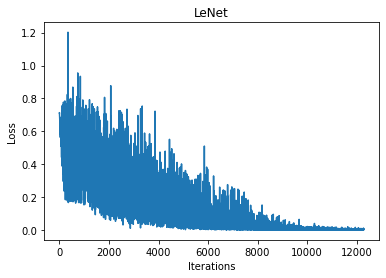

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)


In [12]:
# Verify LeNet
net = LeNet()
net = net.to(device)

# Hyperparameters
num_epochs = 1024
learning_rate = 0.0001
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
#optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

lenet_train_losses = []

for epoch in range(num_epochs):
    train(epoch, train_generator, lenet_train_losses)
    
import matplotlib.pyplot as plt
plt.plot(lenet_train_losses)
plt.title('LeNet')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

#Saving the model as a state dictionary
state = {
    'net_dict': net.state_dict()
}
torch.save(state, 'LeNet.pkl')

print (net)

EPOCH: 1 - BATCH: 0 - LOSS: 0.5582748651504517
EPOCH: 1 - BATCH: 10 - LOSS: 0.3961228132247925
EPOCH: 1 - BATCH: 20 - LOSS: 0.5882580280303955
EPOCH: 1 - BATCH: 30 - LOSS: 0.6169806718826294
EPOCH: 1 - BATCH: 40 - LOSS: 0.43866127729415894
EPOCH: 1 - BATCH: 50 - LOSS: 0.5481557250022888
EPOCH: 1 - BATCH: 60 - LOSS: 0.41876038908958435
EPOCH: 1 - BATCH: 70 - LOSS: 0.2578705847263336
EPOCH: 1 - BATCH: 80 - LOSS: 0.3206436038017273
EPOCH: 1 - BATCH: 90 - LOSS: 0.42193013429641724
EPOCH: 1 - BATCH: 100 - LOSS: 0.31198596954345703
EPOCH: 1 - BATCH: 110 - LOSS: 0.42192021012306213
EPOCH: 2 - BATCH: 0 - LOSS: 0.28606510162353516
EPOCH: 2 - BATCH: 10 - LOSS: 0.32996365427970886
EPOCH: 2 - BATCH: 20 - LOSS: 0.36791542172431946
EPOCH: 2 - BATCH: 30 - LOSS: 0.47604894638061523
EPOCH: 2 - BATCH: 40 - LOSS: 0.23311883211135864
EPOCH: 2 - BATCH: 50 - LOSS: 0.3026772141456604
EPOCH: 2 - BATCH: 60 - LOSS: 0.463741660118103
EPOCH: 2 - BATCH: 70 - LOSS: 0.3427537977695465
EPOCH: 2 - BATCH: 80 - LOSS: 0.

EPOCH: 14 - BATCH: 110 - LOSS: 0.10130056738853455
EPOCH: 15 - BATCH: 0 - LOSS: 0.12061788141727448
EPOCH: 15 - BATCH: 10 - LOSS: 0.1624172478914261
EPOCH: 15 - BATCH: 20 - LOSS: 0.25285619497299194
EPOCH: 15 - BATCH: 30 - LOSS: 0.06442394852638245
EPOCH: 15 - BATCH: 40 - LOSS: 0.230596125125885
EPOCH: 15 - BATCH: 50 - LOSS: 0.06986933946609497
EPOCH: 15 - BATCH: 60 - LOSS: 0.08967195451259613
EPOCH: 15 - BATCH: 70 - LOSS: 0.16044625639915466
EPOCH: 15 - BATCH: 80 - LOSS: 0.10060718655586243
EPOCH: 15 - BATCH: 90 - LOSS: 0.12839922308921814
EPOCH: 15 - BATCH: 100 - LOSS: 0.24146641790866852
EPOCH: 15 - BATCH: 110 - LOSS: 0.12967459857463837
EPOCH: 16 - BATCH: 0 - LOSS: 0.07935985177755356
EPOCH: 16 - BATCH: 10 - LOSS: 0.07429063320159912
EPOCH: 16 - BATCH: 20 - LOSS: 0.05713312327861786
EPOCH: 16 - BATCH: 30 - LOSS: 0.1652567982673645
EPOCH: 16 - BATCH: 40 - LOSS: 0.09869642555713654
EPOCH: 16 - BATCH: 50 - LOSS: 0.04804328829050064
EPOCH: 16 - BATCH: 60 - LOSS: 0.11403302103281021
EPO

EPOCH: 29 - BATCH: 0 - LOSS: 0.0931527316570282
EPOCH: 29 - BATCH: 10 - LOSS: 0.13108821213245392
EPOCH: 29 - BATCH: 20 - LOSS: 0.051903627812862396
EPOCH: 29 - BATCH: 30 - LOSS: 0.10658960044384003
EPOCH: 29 - BATCH: 40 - LOSS: 0.14047770202159882
EPOCH: 29 - BATCH: 50 - LOSS: 0.09252359718084335
EPOCH: 29 - BATCH: 60 - LOSS: 0.11837848275899887
EPOCH: 29 - BATCH: 70 - LOSS: 0.06971120834350586
EPOCH: 29 - BATCH: 80 - LOSS: 0.07254279404878616
EPOCH: 29 - BATCH: 90 - LOSS: 0.034392278641462326
EPOCH: 29 - BATCH: 100 - LOSS: 0.2063354253768921
EPOCH: 29 - BATCH: 110 - LOSS: 0.023354940116405487
EPOCH: 30 - BATCH: 0 - LOSS: 0.11316072195768356
EPOCH: 30 - BATCH: 10 - LOSS: 0.06243840605020523
EPOCH: 30 - BATCH: 20 - LOSS: 0.0634809210896492
EPOCH: 30 - BATCH: 30 - LOSS: 0.06992201507091522
EPOCH: 30 - BATCH: 40 - LOSS: 0.11444122344255447
EPOCH: 30 - BATCH: 50 - LOSS: 0.05557628720998764
EPOCH: 30 - BATCH: 60 - LOSS: 0.04495106264948845
EPOCH: 30 - BATCH: 70 - LOSS: 0.058620695024728775

EPOCH: 42 - BATCH: 100 - LOSS: 0.057824958115816116
EPOCH: 42 - BATCH: 110 - LOSS: 0.030156664550304413
EPOCH: 43 - BATCH: 0 - LOSS: 0.031990837305784225
EPOCH: 43 - BATCH: 10 - LOSS: 0.03376644104719162
EPOCH: 43 - BATCH: 20 - LOSS: 0.09323249012231827
EPOCH: 43 - BATCH: 30 - LOSS: 0.007682951167225838
EPOCH: 43 - BATCH: 40 - LOSS: 0.014785255305469036
EPOCH: 43 - BATCH: 50 - LOSS: 0.024483410641551018
EPOCH: 43 - BATCH: 60 - LOSS: 0.24558483064174652
EPOCH: 43 - BATCH: 70 - LOSS: 0.03512771055102348
EPOCH: 43 - BATCH: 80 - LOSS: 0.03110385313630104
EPOCH: 43 - BATCH: 90 - LOSS: 0.04575677216053009
EPOCH: 43 - BATCH: 100 - LOSS: 0.013899405486881733
EPOCH: 43 - BATCH: 110 - LOSS: 0.011031943373382092
EPOCH: 44 - BATCH: 0 - LOSS: 0.05240572616457939
EPOCH: 44 - BATCH: 10 - LOSS: 0.10256452858448029
EPOCH: 44 - BATCH: 20 - LOSS: 0.0511055514216423
EPOCH: 44 - BATCH: 30 - LOSS: 0.03347799554467201
EPOCH: 44 - BATCH: 40 - LOSS: 0.06202204152941704
EPOCH: 44 - BATCH: 50 - LOSS: 0.014929159

EPOCH: 56 - BATCH: 60 - LOSS: 0.009099811315536499
EPOCH: 56 - BATCH: 70 - LOSS: 0.017371831461787224
EPOCH: 56 - BATCH: 80 - LOSS: 0.03519968315958977
EPOCH: 56 - BATCH: 90 - LOSS: 0.01877967268228531
EPOCH: 56 - BATCH: 100 - LOSS: 0.04365835711359978
EPOCH: 56 - BATCH: 110 - LOSS: 0.03513211011886597
EPOCH: 57 - BATCH: 0 - LOSS: 0.08910947293043137
EPOCH: 57 - BATCH: 10 - LOSS: 0.07234226912260056
EPOCH: 57 - BATCH: 20 - LOSS: 0.04560520499944687
EPOCH: 57 - BATCH: 30 - LOSS: 0.0436713844537735
EPOCH: 57 - BATCH: 40 - LOSS: 0.06897448748350143
EPOCH: 57 - BATCH: 50 - LOSS: 0.013255827128887177
EPOCH: 57 - BATCH: 60 - LOSS: 0.04236255958676338
EPOCH: 57 - BATCH: 70 - LOSS: 0.0059951115399599075
EPOCH: 57 - BATCH: 80 - LOSS: 0.024999886751174927
EPOCH: 57 - BATCH: 90 - LOSS: 0.023839164525270462
EPOCH: 57 - BATCH: 100 - LOSS: 0.028424538671970367
EPOCH: 57 - BATCH: 110 - LOSS: 0.015850117430090904
EPOCH: 58 - BATCH: 0 - LOSS: 0.05224251002073288
EPOCH: 58 - BATCH: 10 - LOSS: 0.02999576

EPOCH: 70 - BATCH: 0 - LOSS: 0.011237605474889278
EPOCH: 70 - BATCH: 10 - LOSS: 0.020032798871397972
EPOCH: 70 - BATCH: 20 - LOSS: 0.008510366082191467
EPOCH: 70 - BATCH: 30 - LOSS: 0.040745265781879425
EPOCH: 70 - BATCH: 40 - LOSS: 0.019248779863119125
EPOCH: 70 - BATCH: 50 - LOSS: 0.00500864302739501
EPOCH: 70 - BATCH: 60 - LOSS: 0.004497625399380922
EPOCH: 70 - BATCH: 70 - LOSS: 0.028985418379306793
EPOCH: 70 - BATCH: 80 - LOSS: 0.01014032680541277
EPOCH: 70 - BATCH: 90 - LOSS: 0.0070916712284088135
EPOCH: 70 - BATCH: 100 - LOSS: 0.03846580907702446
EPOCH: 70 - BATCH: 110 - LOSS: 0.012666696682572365
EPOCH: 71 - BATCH: 0 - LOSS: 0.007193797267973423
EPOCH: 71 - BATCH: 10 - LOSS: 0.01847057044506073
EPOCH: 71 - BATCH: 20 - LOSS: 0.010101276449859142
EPOCH: 71 - BATCH: 30 - LOSS: 0.021090004593133926
EPOCH: 71 - BATCH: 40 - LOSS: 0.02666482701897621
EPOCH: 71 - BATCH: 50 - LOSS: 0.01454245951026678
EPOCH: 71 - BATCH: 60 - LOSS: 0.01763012260198593
EPOCH: 71 - BATCH: 70 - LOSS: 0.02545

EPOCH: 83 - BATCH: 100 - LOSS: 0.009185368195176125
EPOCH: 83 - BATCH: 110 - LOSS: 0.057754725217819214
EPOCH: 84 - BATCH: 0 - LOSS: 0.003976709209382534
EPOCH: 84 - BATCH: 10 - LOSS: 0.002624869579449296
EPOCH: 84 - BATCH: 20 - LOSS: 0.06449341773986816
EPOCH: 84 - BATCH: 30 - LOSS: 0.01646779663860798
EPOCH: 84 - BATCH: 40 - LOSS: 0.009282578714191914
EPOCH: 84 - BATCH: 50 - LOSS: 0.010450034402310848
EPOCH: 84 - BATCH: 60 - LOSS: 0.02482881024479866
EPOCH: 84 - BATCH: 70 - LOSS: 0.0023959800601005554
EPOCH: 84 - BATCH: 80 - LOSS: 0.06739470362663269
EPOCH: 84 - BATCH: 90 - LOSS: 0.006040747277438641
EPOCH: 84 - BATCH: 100 - LOSS: 0.016871117055416107
EPOCH: 84 - BATCH: 110 - LOSS: 0.024699542671442032
EPOCH: 85 - BATCH: 0 - LOSS: 0.02714528515934944
EPOCH: 85 - BATCH: 10 - LOSS: 0.01581427827477455
EPOCH: 85 - BATCH: 20 - LOSS: 0.024859532713890076
EPOCH: 85 - BATCH: 30 - LOSS: 0.009943239390850067
EPOCH: 85 - BATCH: 40 - LOSS: 0.004384283442050219
EPOCH: 85 - BATCH: 50 - LOSS: 0.01

EPOCH: 97 - BATCH: 60 - LOSS: 0.016360130161046982
EPOCH: 97 - BATCH: 70 - LOSS: 0.008782762102782726
EPOCH: 97 - BATCH: 80 - LOSS: 0.01790301315486431
EPOCH: 97 - BATCH: 90 - LOSS: 0.00671300757676363
EPOCH: 97 - BATCH: 100 - LOSS: 0.007906137965619564
EPOCH: 97 - BATCH: 110 - LOSS: 0.014271211810410023
EPOCH: 98 - BATCH: 0 - LOSS: 0.007988477125763893
EPOCH: 98 - BATCH: 10 - LOSS: 0.05970902740955353
EPOCH: 98 - BATCH: 20 - LOSS: 0.033252522349357605
EPOCH: 98 - BATCH: 30 - LOSS: 0.02518351934850216
EPOCH: 98 - BATCH: 40 - LOSS: 0.006678211502730846
EPOCH: 98 - BATCH: 50 - LOSS: 0.0050400965847074986
EPOCH: 98 - BATCH: 60 - LOSS: 0.005652661435306072
EPOCH: 98 - BATCH: 70 - LOSS: 0.010362676344811916
EPOCH: 98 - BATCH: 80 - LOSS: 0.0055104028433561325
EPOCH: 98 - BATCH: 90 - LOSS: 0.009230406023561954
EPOCH: 98 - BATCH: 100 - LOSS: 0.014829386956989765
EPOCH: 98 - BATCH: 110 - LOSS: 0.007341689895838499
EPOCH: 99 - BATCH: 0 - LOSS: 0.005266588646918535
EPOCH: 99 - BATCH: 10 - LOSS: 0

EPOCH: 111 - BATCH: 0 - LOSS: 0.0013890527188777924
EPOCH: 111 - BATCH: 10 - LOSS: 0.005136349704116583
EPOCH: 111 - BATCH: 20 - LOSS: 0.010010631754994392
EPOCH: 111 - BATCH: 30 - LOSS: 0.0031298829708248377
EPOCH: 111 - BATCH: 40 - LOSS: 0.010534103028476238
EPOCH: 111 - BATCH: 50 - LOSS: 0.007309672888368368
EPOCH: 111 - BATCH: 60 - LOSS: 0.03015943244099617
EPOCH: 111 - BATCH: 70 - LOSS: 0.013887354172766209
EPOCH: 111 - BATCH: 80 - LOSS: 0.0020912608597427607
EPOCH: 111 - BATCH: 90 - LOSS: 0.04640960320830345
EPOCH: 111 - BATCH: 100 - LOSS: 0.02878488413989544
EPOCH: 111 - BATCH: 110 - LOSS: 0.0034067081287503242
EPOCH: 112 - BATCH: 0 - LOSS: 0.00592449028044939
EPOCH: 112 - BATCH: 10 - LOSS: 0.003945918288081884
EPOCH: 112 - BATCH: 20 - LOSS: 0.0096207270398736
EPOCH: 112 - BATCH: 30 - LOSS: 0.006629603914916515
EPOCH: 112 - BATCH: 40 - LOSS: 0.025618480518460274
EPOCH: 112 - BATCH: 50 - LOSS: 0.011715139262378216
EPOCH: 112 - BATCH: 60 - LOSS: 0.009119238704442978
EPOCH: 112 - B

EPOCH: 124 - BATCH: 60 - LOSS: 0.012599721550941467
EPOCH: 124 - BATCH: 70 - LOSS: 0.006991908885538578
EPOCH: 124 - BATCH: 80 - LOSS: 0.004975185729563236
EPOCH: 124 - BATCH: 90 - LOSS: 0.0037553911097347736
EPOCH: 124 - BATCH: 100 - LOSS: 0.006824757903814316
EPOCH: 124 - BATCH: 110 - LOSS: 0.004488861188292503
EPOCH: 125 - BATCH: 0 - LOSS: 0.011546687223017216
EPOCH: 125 - BATCH: 10 - LOSS: 0.00365224271081388
EPOCH: 125 - BATCH: 20 - LOSS: 0.0013305892935022712
EPOCH: 125 - BATCH: 30 - LOSS: 0.0075240712612867355
EPOCH: 125 - BATCH: 40 - LOSS: 0.009095062501728535
EPOCH: 125 - BATCH: 50 - LOSS: 0.01846901886165142
EPOCH: 125 - BATCH: 60 - LOSS: 0.002144403988495469
EPOCH: 125 - BATCH: 70 - LOSS: 0.004487319383770227
EPOCH: 125 - BATCH: 80 - LOSS: 0.0023990825284272432
EPOCH: 125 - BATCH: 90 - LOSS: 0.013471206650137901
EPOCH: 125 - BATCH: 100 - LOSS: 0.007632061839103699
EPOCH: 125 - BATCH: 110 - LOSS: 0.005429109092801809
EPOCH: 126 - BATCH: 0 - LOSS: 0.0026289159432053566
EPOCH: 

EPOCH: 137 - BATCH: 100 - LOSS: 0.0031580838840454817
EPOCH: 137 - BATCH: 110 - LOSS: 0.005690393038094044
EPOCH: 138 - BATCH: 0 - LOSS: 0.01485785935074091
EPOCH: 138 - BATCH: 10 - LOSS: 0.006067235954105854
EPOCH: 138 - BATCH: 20 - LOSS: 0.004433195572346449
EPOCH: 138 - BATCH: 30 - LOSS: 0.0009271600283682346
EPOCH: 138 - BATCH: 40 - LOSS: 0.0014866862911731005
EPOCH: 138 - BATCH: 50 - LOSS: 0.02583571895956993
EPOCH: 138 - BATCH: 60 - LOSS: 0.0006690701120533049
EPOCH: 138 - BATCH: 70 - LOSS: 0.012780535966157913
EPOCH: 138 - BATCH: 80 - LOSS: 0.0041157458908855915
EPOCH: 138 - BATCH: 90 - LOSS: 0.0005505132721737027
EPOCH: 138 - BATCH: 100 - LOSS: 0.023692967370152473
EPOCH: 138 - BATCH: 110 - LOSS: 0.01142177451401949
EPOCH: 139 - BATCH: 0 - LOSS: 0.029957542195916176
EPOCH: 139 - BATCH: 10 - LOSS: 0.0043413070961833
EPOCH: 139 - BATCH: 20 - LOSS: 0.008007883094251156
EPOCH: 139 - BATCH: 30 - LOSS: 0.0058052088133990765
EPOCH: 139 - BATCH: 40 - LOSS: 0.013815267942845821
EPOCH: 1

EPOCH: 150 - BATCH: 110 - LOSS: 0.001028485712595284
EPOCH: 151 - BATCH: 0 - LOSS: 0.001988716423511505
EPOCH: 151 - BATCH: 10 - LOSS: 0.0024004396982491016
EPOCH: 151 - BATCH: 20 - LOSS: 0.007995858788490295
EPOCH: 151 - BATCH: 30 - LOSS: 0.0005712363054044545
EPOCH: 151 - BATCH: 40 - LOSS: 0.0026332885026931763
EPOCH: 151 - BATCH: 50 - LOSS: 0.005539316684007645
EPOCH: 151 - BATCH: 60 - LOSS: 0.01417857501655817
EPOCH: 151 - BATCH: 70 - LOSS: 0.0069107129238545895
EPOCH: 151 - BATCH: 80 - LOSS: 0.003936500288546085
EPOCH: 151 - BATCH: 90 - LOSS: 0.0035476668272167444
EPOCH: 151 - BATCH: 100 - LOSS: 0.018154283985495567
EPOCH: 151 - BATCH: 110 - LOSS: 0.006368983071297407
EPOCH: 152 - BATCH: 0 - LOSS: 0.0048028635792434216
EPOCH: 152 - BATCH: 10 - LOSS: 0.0059467339888215065
EPOCH: 152 - BATCH: 20 - LOSS: 0.002147918799892068
EPOCH: 152 - BATCH: 30 - LOSS: 0.005561278201639652
EPOCH: 152 - BATCH: 40 - LOSS: 0.006131578236818314
EPOCH: 152 - BATCH: 50 - LOSS: 0.007903431542217731
EPOCH

EPOCH: 164 - BATCH: 0 - LOSS: 0.0023518663365393877
EPOCH: 164 - BATCH: 10 - LOSS: 0.0008430135785602033
EPOCH: 164 - BATCH: 20 - LOSS: 0.004549519624561071
EPOCH: 164 - BATCH: 30 - LOSS: 0.00039793422911316156
EPOCH: 164 - BATCH: 40 - LOSS: 0.00418388657271862
EPOCH: 164 - BATCH: 50 - LOSS: 0.007540907245129347
EPOCH: 164 - BATCH: 60 - LOSS: 0.004758929368108511
EPOCH: 164 - BATCH: 70 - LOSS: 0.004047423135489225
EPOCH: 164 - BATCH: 80 - LOSS: 0.0055060721933841705
EPOCH: 164 - BATCH: 90 - LOSS: 0.006549063604325056
EPOCH: 164 - BATCH: 100 - LOSS: 0.005452071316540241
EPOCH: 164 - BATCH: 110 - LOSS: 0.003910381812602282
EPOCH: 165 - BATCH: 0 - LOSS: 0.0022102559451013803
EPOCH: 165 - BATCH: 10 - LOSS: 0.0029619077686220407
EPOCH: 165 - BATCH: 20 - LOSS: 0.007051210850477219
EPOCH: 165 - BATCH: 30 - LOSS: 0.000997818191535771
EPOCH: 165 - BATCH: 40 - LOSS: 0.0036744335666298866
EPOCH: 165 - BATCH: 50 - LOSS: 0.002684713574126363
EPOCH: 165 - BATCH: 60 - LOSS: 0.0068718683905899525
EPOC

EPOCH: 177 - BATCH: 60 - LOSS: 0.006705495063215494
EPOCH: 177 - BATCH: 70 - LOSS: 0.01031581498682499
EPOCH: 177 - BATCH: 80 - LOSS: 0.0013830158859491348
EPOCH: 177 - BATCH: 90 - LOSS: 0.004297459498047829
EPOCH: 177 - BATCH: 100 - LOSS: 0.003183778841048479
EPOCH: 177 - BATCH: 110 - LOSS: 0.0034128217957913876
EPOCH: 178 - BATCH: 0 - LOSS: 0.003320517251268029
EPOCH: 178 - BATCH: 10 - LOSS: 0.001628960482776165
EPOCH: 178 - BATCH: 20 - LOSS: 0.008949131704866886
EPOCH: 178 - BATCH: 30 - LOSS: 0.0027067482005804777
EPOCH: 178 - BATCH: 40 - LOSS: 0.005710260942578316
EPOCH: 178 - BATCH: 50 - LOSS: 0.0015913979150354862
EPOCH: 178 - BATCH: 60 - LOSS: 0.0024123804178088903
EPOCH: 178 - BATCH: 70 - LOSS: 0.015014787204563618
EPOCH: 178 - BATCH: 80 - LOSS: 0.0008025985443964601
EPOCH: 178 - BATCH: 90 - LOSS: 0.00397650059312582
EPOCH: 178 - BATCH: 100 - LOSS: 0.003892652690410614
EPOCH: 178 - BATCH: 110 - LOSS: 0.0015824981965124607
EPOCH: 179 - BATCH: 0 - LOSS: 0.002925949404016137
EPOCH

EPOCH: 190 - BATCH: 70 - LOSS: 0.0065083494409918785
EPOCH: 190 - BATCH: 80 - LOSS: 0.0046902066096663475
EPOCH: 190 - BATCH: 90 - LOSS: 0.0034909341484308243
EPOCH: 190 - BATCH: 100 - LOSS: 0.00222362601198256
EPOCH: 190 - BATCH: 110 - LOSS: 0.006317491177469492
EPOCH: 191 - BATCH: 0 - LOSS: 0.0023141673300415277
EPOCH: 191 - BATCH: 10 - LOSS: 0.007611544337123632
EPOCH: 191 - BATCH: 20 - LOSS: 0.00451244693249464
EPOCH: 191 - BATCH: 30 - LOSS: 0.004147464409470558
EPOCH: 191 - BATCH: 40 - LOSS: 0.006821022368967533
EPOCH: 191 - BATCH: 50 - LOSS: 0.002852335339412093
EPOCH: 191 - BATCH: 60 - LOSS: 0.0029368619434535503
EPOCH: 191 - BATCH: 70 - LOSS: 0.001434018835425377
EPOCH: 191 - BATCH: 80 - LOSS: 0.0005832658498547971
EPOCH: 191 - BATCH: 90 - LOSS: 0.009826317429542542
EPOCH: 191 - BATCH: 100 - LOSS: 0.0034084247890859842
EPOCH: 191 - BATCH: 110 - LOSS: 0.003408044343814254
EPOCH: 192 - BATCH: 0 - LOSS: 0.003772133495658636
EPOCH: 192 - BATCH: 10 - LOSS: 0.0008314813603647053
EPOC

EPOCH: 204 - BATCH: 0 - LOSS: 0.003196059027686715
EPOCH: 204 - BATCH: 10 - LOSS: 0.006523228250443935
EPOCH: 204 - BATCH: 20 - LOSS: 0.006993365474045277
EPOCH: 204 - BATCH: 30 - LOSS: 0.0005878987140022218
EPOCH: 204 - BATCH: 40 - LOSS: 0.0019910484552383423
EPOCH: 204 - BATCH: 50 - LOSS: 0.001943063922226429
EPOCH: 204 - BATCH: 60 - LOSS: 0.004539783112704754
EPOCH: 204 - BATCH: 70 - LOSS: 0.002157576847821474
EPOCH: 204 - BATCH: 80 - LOSS: 0.0013188122538849711
EPOCH: 204 - BATCH: 90 - LOSS: 0.003652295796200633
EPOCH: 204 - BATCH: 100 - LOSS: 0.0040769921615719795
EPOCH: 204 - BATCH: 110 - LOSS: 0.001607614103704691
EPOCH: 205 - BATCH: 0 - LOSS: 0.003730662865564227
EPOCH: 205 - BATCH: 10 - LOSS: 0.001419975538738072
EPOCH: 205 - BATCH: 20 - LOSS: 0.00755296042189002
EPOCH: 205 - BATCH: 30 - LOSS: 0.003804564941674471
EPOCH: 205 - BATCH: 40 - LOSS: 0.0022873911075294018
EPOCH: 205 - BATCH: 50 - LOSS: 0.0006306302384473383
EPOCH: 205 - BATCH: 60 - LOSS: 0.0021586548537015915
EPOCH:

EPOCH: 217 - BATCH: 0 - LOSS: 0.0008821727242320776
EPOCH: 217 - BATCH: 10 - LOSS: 0.0031898359302431345
EPOCH: 217 - BATCH: 20 - LOSS: 0.004950832109898329
EPOCH: 217 - BATCH: 30 - LOSS: 0.0006585472729057074
EPOCH: 217 - BATCH: 40 - LOSS: 0.0015117881121113896
EPOCH: 217 - BATCH: 50 - LOSS: 0.005135105922818184
EPOCH: 217 - BATCH: 60 - LOSS: 0.003356821136549115
EPOCH: 217 - BATCH: 70 - LOSS: 0.0021147001534700394
EPOCH: 217 - BATCH: 80 - LOSS: 0.005798437632620335
EPOCH: 217 - BATCH: 90 - LOSS: 0.004183052573353052
EPOCH: 217 - BATCH: 100 - LOSS: 0.0027924254536628723
EPOCH: 217 - BATCH: 110 - LOSS: 0.0001438756298739463
EPOCH: 218 - BATCH: 0 - LOSS: 0.002240350702777505
EPOCH: 218 - BATCH: 10 - LOSS: 0.0013642598642036319
EPOCH: 218 - BATCH: 20 - LOSS: 0.0030221999622881413
EPOCH: 218 - BATCH: 30 - LOSS: 0.0027453897055238485
EPOCH: 218 - BATCH: 40 - LOSS: 0.0005689847166649997
EPOCH: 218 - BATCH: 50 - LOSS: 0.0012336354702711105
EPOCH: 218 - BATCH: 60 - LOSS: 0.005164419766515493


EPOCH: 230 - BATCH: 0 - LOSS: 0.0008449528249911964
EPOCH: 230 - BATCH: 10 - LOSS: 0.003000421216711402
EPOCH: 230 - BATCH: 20 - LOSS: 0.0053807031363248825
EPOCH: 230 - BATCH: 30 - LOSS: 0.002813315950334072
EPOCH: 230 - BATCH: 40 - LOSS: 0.0017640726873651147
EPOCH: 230 - BATCH: 50 - LOSS: 0.0045760395005345345
EPOCH: 230 - BATCH: 60 - LOSS: 0.00024522055173292756
EPOCH: 230 - BATCH: 70 - LOSS: 0.0007262795697897673
EPOCH: 230 - BATCH: 80 - LOSS: 0.002148069441318512
EPOCH: 230 - BATCH: 90 - LOSS: 0.0008027236326597631
EPOCH: 230 - BATCH: 100 - LOSS: 0.001465940149500966
EPOCH: 230 - BATCH: 110 - LOSS: 0.0005912934429943562
EPOCH: 231 - BATCH: 0 - LOSS: 0.00015594159776810557
EPOCH: 231 - BATCH: 10 - LOSS: 0.0018852464854717255
EPOCH: 231 - BATCH: 20 - LOSS: 0.0005069451872259378
EPOCH: 231 - BATCH: 30 - LOSS: 0.00434580584987998
EPOCH: 231 - BATCH: 40 - LOSS: 0.0021444966550916433
EPOCH: 231 - BATCH: 50 - LOSS: 0.021128375083208084
EPOCH: 231 - BATCH: 60 - LOSS: 0.002634412609040737

EPOCH: 243 - BATCH: 0 - LOSS: 0.005913897883147001
EPOCH: 243 - BATCH: 10 - LOSS: 0.0035339617170393467
EPOCH: 243 - BATCH: 20 - LOSS: 0.0009575815638527274
EPOCH: 243 - BATCH: 30 - LOSS: 0.0010719832498580217
EPOCH: 243 - BATCH: 40 - LOSS: 0.0028218452353030443
EPOCH: 243 - BATCH: 50 - LOSS: 0.0011169039644300938
EPOCH: 243 - BATCH: 60 - LOSS: 0.00416167126968503
EPOCH: 243 - BATCH: 70 - LOSS: 0.0036428431048989296
EPOCH: 243 - BATCH: 80 - LOSS: 0.0008237762376666069
EPOCH: 243 - BATCH: 90 - LOSS: 0.00473769661039114
EPOCH: 243 - BATCH: 100 - LOSS: 0.0016685286536812782
EPOCH: 243 - BATCH: 110 - LOSS: 0.0008851552847772837
EPOCH: 244 - BATCH: 0 - LOSS: 0.003345344215631485
EPOCH: 244 - BATCH: 10 - LOSS: 0.0007654726505279541
EPOCH: 244 - BATCH: 20 - LOSS: 0.0016075497260317206
EPOCH: 244 - BATCH: 30 - LOSS: 0.003594056237488985
EPOCH: 244 - BATCH: 40 - LOSS: 0.004339838866144419
EPOCH: 244 - BATCH: 50 - LOSS: 0.001294266781769693
EPOCH: 244 - BATCH: 60 - LOSS: 0.00245821475982666
EPOC

EPOCH: 256 - BATCH: 0 - LOSS: 0.0018901131115853786
EPOCH: 256 - BATCH: 10 - LOSS: 0.002462328178808093
EPOCH: 256 - BATCH: 20 - LOSS: 0.0013016634620726109
EPOCH: 256 - BATCH: 30 - LOSS: 0.000901171239092946
EPOCH: 256 - BATCH: 40 - LOSS: 0.0009666751720942557
EPOCH: 256 - BATCH: 50 - LOSS: 0.0008895121864043176
EPOCH: 256 - BATCH: 60 - LOSS: 0.00040646607521921396
EPOCH: 256 - BATCH: 70 - LOSS: 0.0018981104949489236
EPOCH: 256 - BATCH: 80 - LOSS: 0.005444540176540613
EPOCH: 256 - BATCH: 90 - LOSS: 6.313485209830105e-05
EPOCH: 256 - BATCH: 100 - LOSS: 0.001249466324225068
EPOCH: 256 - BATCH: 110 - LOSS: 0.0022107893601059914
EPOCH: 257 - BATCH: 0 - LOSS: 0.0002800362999550998
EPOCH: 257 - BATCH: 10 - LOSS: 0.003784013446420431
EPOCH: 257 - BATCH: 20 - LOSS: 0.00593703193590045
EPOCH: 257 - BATCH: 30 - LOSS: 0.00411583948880434
EPOCH: 257 - BATCH: 40 - LOSS: 0.0007122062379494309
EPOCH: 257 - BATCH: 50 - LOSS: 0.00644286023452878
EPOCH: 257 - BATCH: 60 - LOSS: 0.0016123867826536298
EPO

EPOCH: 269 - BATCH: 0 - LOSS: 0.002812136197462678
EPOCH: 269 - BATCH: 10 - LOSS: 0.004226849414408207
EPOCH: 269 - BATCH: 20 - LOSS: 0.0021044781897217035
EPOCH: 269 - BATCH: 30 - LOSS: 0.0025986728724092245
EPOCH: 269 - BATCH: 40 - LOSS: 0.0021355003118515015
EPOCH: 269 - BATCH: 50 - LOSS: 0.0005733943544328213
EPOCH: 269 - BATCH: 60 - LOSS: 0.0010743871098384261
EPOCH: 269 - BATCH: 70 - LOSS: 0.001101038884371519
EPOCH: 269 - BATCH: 80 - LOSS: 0.0026558570098131895
EPOCH: 269 - BATCH: 90 - LOSS: 0.007237230893224478
EPOCH: 269 - BATCH: 100 - LOSS: 0.0007093707099556923
EPOCH: 269 - BATCH: 110 - LOSS: 0.009969132952392101
EPOCH: 270 - BATCH: 0 - LOSS: 0.0020068923477083445
EPOCH: 270 - BATCH: 10 - LOSS: 0.002007146365940571
EPOCH: 270 - BATCH: 20 - LOSS: 0.0020279409363865852
EPOCH: 270 - BATCH: 30 - LOSS: 0.0011841359082609415
EPOCH: 270 - BATCH: 40 - LOSS: 0.01164313219487667
EPOCH: 270 - BATCH: 50 - LOSS: 0.0026443384122103453
EPOCH: 270 - BATCH: 60 - LOSS: 0.0009831064380705357
E

EPOCH: 282 - BATCH: 0 - LOSS: 0.0016795890405774117
EPOCH: 282 - BATCH: 10 - LOSS: 0.00235217553563416
EPOCH: 282 - BATCH: 20 - LOSS: 0.004126337822526693
EPOCH: 282 - BATCH: 30 - LOSS: 0.002168545499444008
EPOCH: 282 - BATCH: 40 - LOSS: 0.001703835790976882
EPOCH: 282 - BATCH: 50 - LOSS: 0.003191167488694191
EPOCH: 282 - BATCH: 60 - LOSS: 0.0013328131753951311
EPOCH: 282 - BATCH: 70 - LOSS: 0.0004855666193179786
EPOCH: 282 - BATCH: 80 - LOSS: 0.000981201184913516
EPOCH: 282 - BATCH: 90 - LOSS: 0.0003879317664541304
EPOCH: 282 - BATCH: 100 - LOSS: 0.0022401497699320316
EPOCH: 282 - BATCH: 110 - LOSS: 0.0034421728923916817
EPOCH: 283 - BATCH: 0 - LOSS: 0.0009029954089783132
EPOCH: 283 - BATCH: 10 - LOSS: 0.0019292030483484268
EPOCH: 283 - BATCH: 20 - LOSS: 0.0012408014154061675
EPOCH: 283 - BATCH: 30 - LOSS: 0.0005351654253900051
EPOCH: 283 - BATCH: 40 - LOSS: 0.00098236626945436
EPOCH: 283 - BATCH: 50 - LOSS: 0.012067543342709541
EPOCH: 283 - BATCH: 60 - LOSS: 0.001048009842634201
EPOC

EPOCH: 295 - BATCH: 0 - LOSS: 0.0024633528664708138
EPOCH: 295 - BATCH: 10 - LOSS: 0.002329671522602439
EPOCH: 295 - BATCH: 20 - LOSS: 0.001289336127229035
EPOCH: 295 - BATCH: 30 - LOSS: 0.000446241901954636
EPOCH: 295 - BATCH: 40 - LOSS: 0.0015402627177536488
EPOCH: 295 - BATCH: 50 - LOSS: 0.0001587491133250296
EPOCH: 295 - BATCH: 60 - LOSS: 0.0004641892737708986
EPOCH: 295 - BATCH: 70 - LOSS: 0.0014925553696230054
EPOCH: 295 - BATCH: 80 - LOSS: 0.0013753253733739257
EPOCH: 295 - BATCH: 90 - LOSS: 0.0051545943133533
EPOCH: 295 - BATCH: 100 - LOSS: 0.0002418046206003055
EPOCH: 295 - BATCH: 110 - LOSS: 0.003156498074531555
EPOCH: 296 - BATCH: 0 - LOSS: 0.0012295154156163335
EPOCH: 296 - BATCH: 10 - LOSS: 0.001156858168542385
EPOCH: 296 - BATCH: 20 - LOSS: 0.0010963815730065107
EPOCH: 296 - BATCH: 30 - LOSS: 0.005378095433115959
EPOCH: 296 - BATCH: 40 - LOSS: 0.002194154541939497
EPOCH: 296 - BATCH: 50 - LOSS: 0.005491167772561312
EPOCH: 296 - BATCH: 60 - LOSS: 0.001914351829327643
EPOCH

EPOCH: 308 - BATCH: 0 - LOSS: 0.0006522172479890287
EPOCH: 308 - BATCH: 10 - LOSS: 0.0003115373256150633
EPOCH: 308 - BATCH: 20 - LOSS: 0.002520063193514943
EPOCH: 308 - BATCH: 30 - LOSS: 0.0018043158343061805
EPOCH: 308 - BATCH: 40 - LOSS: 0.003272667760029435
EPOCH: 308 - BATCH: 50 - LOSS: 0.0032749606762081385
EPOCH: 308 - BATCH: 60 - LOSS: 0.00359629699960351
EPOCH: 308 - BATCH: 70 - LOSS: 0.002261823508888483
EPOCH: 308 - BATCH: 80 - LOSS: 8.031618563109078e-06
EPOCH: 308 - BATCH: 90 - LOSS: 0.003178160637617111
EPOCH: 308 - BATCH: 100 - LOSS: 0.0009574535069987178
EPOCH: 308 - BATCH: 110 - LOSS: 0.0023236912675201893
EPOCH: 309 - BATCH: 0 - LOSS: 0.0008582526352256536
EPOCH: 309 - BATCH: 10 - LOSS: 0.0005964100710116327
EPOCH: 309 - BATCH: 20 - LOSS: 0.0006714914925396442
EPOCH: 309 - BATCH: 30 - LOSS: 0.0010960844811052084
EPOCH: 309 - BATCH: 40 - LOSS: 0.0006989825633354485
EPOCH: 309 - BATCH: 50 - LOSS: 0.0006178765324875712
EPOCH: 309 - BATCH: 60 - LOSS: 0.0013519579079002142

EPOCH: 321 - BATCH: 0 - LOSS: 0.001099572516977787
EPOCH: 321 - BATCH: 10 - LOSS: 0.0003827586770057678
EPOCH: 321 - BATCH: 20 - LOSS: 0.004057943820953369
EPOCH: 321 - BATCH: 30 - LOSS: 0.00017778905748855323
EPOCH: 321 - BATCH: 40 - LOSS: 0.002732345601543784
EPOCH: 321 - BATCH: 50 - LOSS: 0.0011084777070209384
EPOCH: 321 - BATCH: 60 - LOSS: 0.0007946083787828684
EPOCH: 321 - BATCH: 70 - LOSS: 0.0006276796339079738
EPOCH: 321 - BATCH: 80 - LOSS: 0.0006720217643305659
EPOCH: 321 - BATCH: 90 - LOSS: 0.002613411983475089
EPOCH: 321 - BATCH: 100 - LOSS: 0.0039045829325914383
EPOCH: 321 - BATCH: 110 - LOSS: 0.00015076861018314958
EPOCH: 322 - BATCH: 0 - LOSS: 0.0045126648619771
EPOCH: 322 - BATCH: 10 - LOSS: 0.002428889973089099
EPOCH: 322 - BATCH: 20 - LOSS: 0.0019371809903532267
EPOCH: 322 - BATCH: 30 - LOSS: 0.0007899552001617849
EPOCH: 322 - BATCH: 40 - LOSS: 0.0003358328540343791
EPOCH: 322 - BATCH: 50 - LOSS: 0.0012134788557887077
EPOCH: 322 - BATCH: 60 - LOSS: 0.0008973996737040579

EPOCH: 334 - BATCH: 0 - LOSS: 0.0010760253062471747
EPOCH: 334 - BATCH: 10 - LOSS: 0.0018422516295686364
EPOCH: 334 - BATCH: 20 - LOSS: 2.627645335451234e-05
EPOCH: 334 - BATCH: 30 - LOSS: 0.00045061594573780894
EPOCH: 334 - BATCH: 40 - LOSS: 0.0018783233826979995
EPOCH: 334 - BATCH: 50 - LOSS: 0.0015287523856386542
EPOCH: 334 - BATCH: 60 - LOSS: 0.002116031479090452
EPOCH: 334 - BATCH: 70 - LOSS: 0.0006093474221415818
EPOCH: 334 - BATCH: 80 - LOSS: 0.00043910363456234336
EPOCH: 334 - BATCH: 90 - LOSS: 0.0013865845976397395
EPOCH: 334 - BATCH: 100 - LOSS: 0.0013632464688271284
EPOCH: 334 - BATCH: 110 - LOSS: 0.0007474519079551101
EPOCH: 335 - BATCH: 0 - LOSS: 0.00010238255345029756
EPOCH: 335 - BATCH: 10 - LOSS: 0.0005112724611535668
EPOCH: 335 - BATCH: 20 - LOSS: 0.00015937657735776156
EPOCH: 335 - BATCH: 30 - LOSS: 0.0010535272303968668
EPOCH: 335 - BATCH: 40 - LOSS: 0.0013543589739128947
EPOCH: 335 - BATCH: 50 - LOSS: 0.0010533498134464025
EPOCH: 335 - BATCH: 60 - LOSS: 0.0020170493

EPOCH: 347 - BATCH: 0 - LOSS: 0.0011594245443120599
EPOCH: 347 - BATCH: 10 - LOSS: 0.0024086860939860344
EPOCH: 347 - BATCH: 20 - LOSS: 0.002021295949816704
EPOCH: 347 - BATCH: 30 - LOSS: 0.00025984394596889615
EPOCH: 347 - BATCH: 40 - LOSS: 0.0001695608807494864
EPOCH: 347 - BATCH: 50 - LOSS: 0.0009137820452451706
EPOCH: 347 - BATCH: 60 - LOSS: 0.0010816442081704736
EPOCH: 347 - BATCH: 70 - LOSS: 0.0009375509107485414
EPOCH: 347 - BATCH: 80 - LOSS: 0.0008987605106085539
EPOCH: 347 - BATCH: 90 - LOSS: 0.0006091237301006913
EPOCH: 347 - BATCH: 100 - LOSS: 0.0006590959965251386
EPOCH: 347 - BATCH: 110 - LOSS: 8.395394252147526e-05
EPOCH: 348 - BATCH: 0 - LOSS: 0.0005607196944765747
EPOCH: 348 - BATCH: 10 - LOSS: 0.0008531774510629475
EPOCH: 348 - BATCH: 20 - LOSS: 0.0007431043777614832
EPOCH: 348 - BATCH: 30 - LOSS: 0.00020964966097380966
EPOCH: 348 - BATCH: 40 - LOSS: 4.60078808828257e-05
EPOCH: 348 - BATCH: 50 - LOSS: 0.0006974530988372862
EPOCH: 348 - BATCH: 60 - LOSS: 0.0006298368680

EPOCH: 360 - BATCH: 0 - LOSS: 0.0002731282729655504
EPOCH: 360 - BATCH: 10 - LOSS: 0.00016340143338311464
EPOCH: 360 - BATCH: 20 - LOSS: 0.0009178718319162726
EPOCH: 360 - BATCH: 30 - LOSS: 0.00023607381444890052
EPOCH: 360 - BATCH: 40 - LOSS: 0.00220866734161973
EPOCH: 360 - BATCH: 50 - LOSS: 0.0004760649462696165
EPOCH: 360 - BATCH: 60 - LOSS: 0.0007127395365387201
EPOCH: 360 - BATCH: 70 - LOSS: 0.0006668089190497994
EPOCH: 360 - BATCH: 80 - LOSS: 0.001770713715814054
EPOCH: 360 - BATCH: 90 - LOSS: 0.0022959604393690825
EPOCH: 360 - BATCH: 100 - LOSS: 0.0008385169203393161
EPOCH: 360 - BATCH: 110 - LOSS: 0.0016971598379313946
EPOCH: 361 - BATCH: 0 - LOSS: 0.0002524049486964941
EPOCH: 361 - BATCH: 10 - LOSS: 0.001460561528801918
EPOCH: 361 - BATCH: 20 - LOSS: 0.0007175076170824468
EPOCH: 361 - BATCH: 30 - LOSS: 0.00029352636192925274
EPOCH: 361 - BATCH: 40 - LOSS: 0.0010138219222426414
EPOCH: 361 - BATCH: 50 - LOSS: 0.004251683130860329
EPOCH: 361 - BATCH: 60 - LOSS: 0.000541700806934

EPOCH: 372 - BATCH: 110 - LOSS: 0.0028720805421471596
EPOCH: 373 - BATCH: 0 - LOSS: 0.0013540525687858462
EPOCH: 373 - BATCH: 10 - LOSS: 0.0024663524236530066
EPOCH: 373 - BATCH: 20 - LOSS: 0.0007629974861629307
EPOCH: 373 - BATCH: 30 - LOSS: 0.000749604485463351
EPOCH: 373 - BATCH: 40 - LOSS: 8.124975283863023e-05
EPOCH: 373 - BATCH: 50 - LOSS: 0.00035507301799952984
EPOCH: 373 - BATCH: 60 - LOSS: 0.0009291681344620883
EPOCH: 373 - BATCH: 70 - LOSS: 0.00025391363305971026
EPOCH: 373 - BATCH: 80 - LOSS: 0.0002460516698192805
EPOCH: 373 - BATCH: 90 - LOSS: 0.0009373030625283718
EPOCH: 373 - BATCH: 100 - LOSS: 0.000577906088437885
EPOCH: 373 - BATCH: 110 - LOSS: 0.0004444420337677002
EPOCH: 374 - BATCH: 0 - LOSS: 0.00028154972824268043
EPOCH: 374 - BATCH: 10 - LOSS: 0.0005503075080923736
EPOCH: 374 - BATCH: 20 - LOSS: 0.0005912386695854366
EPOCH: 374 - BATCH: 30 - LOSS: 0.000794996798504144
EPOCH: 374 - BATCH: 40 - LOSS: 0.000929037225432694
EPOCH: 374 - BATCH: 50 - LOSS: 0.0007457548636

EPOCH: 386 - BATCH: 0 - LOSS: 0.0014524220023304224
EPOCH: 386 - BATCH: 10 - LOSS: 0.00019668891036417335
EPOCH: 386 - BATCH: 20 - LOSS: 0.0006409162888303399
EPOCH: 386 - BATCH: 30 - LOSS: 0.0005968374316580594
EPOCH: 386 - BATCH: 40 - LOSS: 0.00021081248996779323
EPOCH: 386 - BATCH: 50 - LOSS: 0.00017733774438966066
EPOCH: 386 - BATCH: 60 - LOSS: 0.001688539981842041
EPOCH: 386 - BATCH: 70 - LOSS: 0.0003532189002726227
EPOCH: 386 - BATCH: 80 - LOSS: 0.00021108356304466724
EPOCH: 386 - BATCH: 90 - LOSS: 0.00025757140247151256
EPOCH: 386 - BATCH: 100 - LOSS: 0.001217461540363729
EPOCH: 386 - BATCH: 110 - LOSS: 0.0009047597413882613
EPOCH: 387 - BATCH: 0 - LOSS: 0.0011835398618131876
EPOCH: 387 - BATCH: 10 - LOSS: 0.0016780453734099865
EPOCH: 387 - BATCH: 20 - LOSS: 0.000631648872513324
EPOCH: 387 - BATCH: 30 - LOSS: 0.0006887514609843493
EPOCH: 387 - BATCH: 40 - LOSS: 0.000808149401564151
EPOCH: 387 - BATCH: 50 - LOSS: 0.001218126737512648
EPOCH: 387 - BATCH: 60 - LOSS: 0.0016735417302

EPOCH: 399 - BATCH: 0 - LOSS: 5.280467667034827e-05
EPOCH: 399 - BATCH: 10 - LOSS: 0.0018298720242455602
EPOCH: 399 - BATCH: 20 - LOSS: 0.0005200895830057561
EPOCH: 399 - BATCH: 30 - LOSS: 0.0030923231970518827
EPOCH: 399 - BATCH: 40 - LOSS: 0.002155099995434284
EPOCH: 399 - BATCH: 50 - LOSS: 0.0009786556474864483
EPOCH: 399 - BATCH: 60 - LOSS: 0.0001550100714666769
EPOCH: 399 - BATCH: 70 - LOSS: 0.0004555697669275105
EPOCH: 399 - BATCH: 80 - LOSS: 0.00031139113707467914
EPOCH: 399 - BATCH: 90 - LOSS: 0.0012557698646560311
EPOCH: 399 - BATCH: 100 - LOSS: 0.00040767615428194404
EPOCH: 399 - BATCH: 110 - LOSS: 0.0028591654263436794
EPOCH: 400 - BATCH: 0 - LOSS: 0.0017572172218933702
EPOCH: 400 - BATCH: 10 - LOSS: 0.0019021667540073395
EPOCH: 400 - BATCH: 20 - LOSS: 0.0024826722219586372
EPOCH: 400 - BATCH: 30 - LOSS: 0.002978671807795763
EPOCH: 400 - BATCH: 40 - LOSS: 0.001352572813630104
EPOCH: 400 - BATCH: 50 - LOSS: 0.0012276710476726294
EPOCH: 400 - BATCH: 60 - LOSS: 0.00049653701717

EPOCH: 412 - BATCH: 0 - LOSS: 0.0001970465964404866
EPOCH: 412 - BATCH: 10 - LOSS: 0.0005573676899075508
EPOCH: 412 - BATCH: 20 - LOSS: 0.0011948228348046541
EPOCH: 412 - BATCH: 30 - LOSS: 0.0011637642746791244
EPOCH: 412 - BATCH: 40 - LOSS: 0.00016364520706702024
EPOCH: 412 - BATCH: 50 - LOSS: 0.0008463605190627277
EPOCH: 412 - BATCH: 60 - LOSS: 0.0019890752155333757
EPOCH: 412 - BATCH: 70 - LOSS: 0.003466848051175475
EPOCH: 412 - BATCH: 80 - LOSS: 0.0008574441308155656
EPOCH: 412 - BATCH: 90 - LOSS: 0.0005791377043351531
EPOCH: 412 - BATCH: 100 - LOSS: 0.001069250050932169
EPOCH: 412 - BATCH: 110 - LOSS: 0.001140582375228405
EPOCH: 413 - BATCH: 0 - LOSS: 0.0013044693041592836
EPOCH: 413 - BATCH: 10 - LOSS: 0.0009731006575748324
EPOCH: 413 - BATCH: 20 - LOSS: 0.0015659944619983435
EPOCH: 413 - BATCH: 30 - LOSS: 0.00013653204950969666
EPOCH: 413 - BATCH: 40 - LOSS: 0.0012485815677791834
EPOCH: 413 - BATCH: 50 - LOSS: 0.0009451592341065407
EPOCH: 413 - BATCH: 60 - LOSS: 0.00123628973960

EPOCH: 425 - BATCH: 0 - LOSS: 0.0009004388703033328
EPOCH: 425 - BATCH: 10 - LOSS: 0.0009023932507261634
EPOCH: 425 - BATCH: 20 - LOSS: 0.0007235894445329905
EPOCH: 425 - BATCH: 30 - LOSS: 0.00038368243258446455
EPOCH: 425 - BATCH: 40 - LOSS: 0.0022577738855034113
EPOCH: 425 - BATCH: 50 - LOSS: 0.0011629501823335886
EPOCH: 425 - BATCH: 60 - LOSS: 0.0027989675290882587
EPOCH: 425 - BATCH: 70 - LOSS: 0.0018577172886580229
EPOCH: 425 - BATCH: 80 - LOSS: 0.0015445854514837265
EPOCH: 425 - BATCH: 90 - LOSS: 0.0004524436080828309
EPOCH: 425 - BATCH: 100 - LOSS: 0.00012856752437073737
EPOCH: 425 - BATCH: 110 - LOSS: 0.0012827814789488912
EPOCH: 426 - BATCH: 0 - LOSS: 0.0019862051121890545
EPOCH: 426 - BATCH: 10 - LOSS: 0.0008568288176320493
EPOCH: 426 - BATCH: 20 - LOSS: 0.0002986894687637687
EPOCH: 426 - BATCH: 30 - LOSS: 0.0014678247971460223
EPOCH: 426 - BATCH: 40 - LOSS: 0.0035056923516094685
EPOCH: 426 - BATCH: 50 - LOSS: 0.0014312348794192076
EPOCH: 426 - BATCH: 60 - LOSS: 0.00071337801

EPOCH: 438 - BATCH: 0 - LOSS: 0.002432279521599412
EPOCH: 438 - BATCH: 10 - LOSS: 0.0026134734507650137
EPOCH: 438 - BATCH: 20 - LOSS: 0.0001934510946739465
EPOCH: 438 - BATCH: 30 - LOSS: 0.0004209268663544208
EPOCH: 438 - BATCH: 40 - LOSS: 0.0002335038298042491
EPOCH: 438 - BATCH: 50 - LOSS: 0.0021826662123203278
EPOCH: 438 - BATCH: 60 - LOSS: 0.006895196624100208
EPOCH: 438 - BATCH: 70 - LOSS: 0.00034649675944820046
EPOCH: 438 - BATCH: 80 - LOSS: 3.655416003311984e-05
EPOCH: 438 - BATCH: 90 - LOSS: 0.0004890921409241855
EPOCH: 438 - BATCH: 100 - LOSS: 0.00037844973849132657
EPOCH: 438 - BATCH: 110 - LOSS: 0.0002862341934815049
EPOCH: 439 - BATCH: 0 - LOSS: 0.0010935524478554726
EPOCH: 439 - BATCH: 10 - LOSS: 0.0007383344345726073
EPOCH: 439 - BATCH: 20 - LOSS: 0.0004153826739639044
EPOCH: 439 - BATCH: 30 - LOSS: 0.0011326299281790853
EPOCH: 439 - BATCH: 40 - LOSS: 9.010449139168486e-05
EPOCH: 439 - BATCH: 50 - LOSS: 0.0004427035746630281
EPOCH: 439 - BATCH: 60 - LOSS: 0.0004353850090

EPOCH: 450 - BATCH: 110 - LOSS: 0.0003241311351303011
EPOCH: 451 - BATCH: 0 - LOSS: 0.00046652249875478446
EPOCH: 451 - BATCH: 10 - LOSS: 5.418112050392665e-05
EPOCH: 451 - BATCH: 20 - LOSS: 0.00012244599929545075
EPOCH: 451 - BATCH: 30 - LOSS: 0.0007297825650312006
EPOCH: 451 - BATCH: 40 - LOSS: 0.0015059115830808878
EPOCH: 451 - BATCH: 50 - LOSS: 2.3751103071845137e-05
EPOCH: 451 - BATCH: 60 - LOSS: 0.0019363798201084137
EPOCH: 451 - BATCH: 70 - LOSS: 0.0002867000875994563
EPOCH: 451 - BATCH: 80 - LOSS: 0.001014053006656468
EPOCH: 451 - BATCH: 90 - LOSS: 0.00042006702278740704
EPOCH: 451 - BATCH: 100 - LOSS: 0.0016780446749180555
EPOCH: 451 - BATCH: 110 - LOSS: 0.002442218828946352
EPOCH: 452 - BATCH: 0 - LOSS: 0.0003303157282061875
EPOCH: 452 - BATCH: 10 - LOSS: 0.001532496651634574
EPOCH: 452 - BATCH: 20 - LOSS: 0.00020014816254843026
EPOCH: 452 - BATCH: 30 - LOSS: 0.0013761172303929925
EPOCH: 452 - BATCH: 40 - LOSS: 0.0006699221557937562
EPOCH: 452 - BATCH: 50 - LOSS: 0.0008227401

EPOCH: 464 - BATCH: 0 - LOSS: 0.0007384617929346859
EPOCH: 464 - BATCH: 10 - LOSS: 0.0007952270098030567
EPOCH: 464 - BATCH: 20 - LOSS: 4.194855137029663e-05
EPOCH: 464 - BATCH: 30 - LOSS: 0.002407119609415531
EPOCH: 464 - BATCH: 40 - LOSS: 0.0011194793041795492
EPOCH: 464 - BATCH: 50 - LOSS: 0.0007693289080634713
EPOCH: 464 - BATCH: 60 - LOSS: 7.858522440074012e-05
EPOCH: 464 - BATCH: 70 - LOSS: 0.001071782666258514
EPOCH: 464 - BATCH: 80 - LOSS: 0.0003595161542762071
EPOCH: 464 - BATCH: 90 - LOSS: 0.0004832390113733709
EPOCH: 464 - BATCH: 100 - LOSS: 0.0002621469320729375
EPOCH: 464 - BATCH: 110 - LOSS: 0.0005813420284539461
EPOCH: 465 - BATCH: 0 - LOSS: 0.0013711502542719245
EPOCH: 465 - BATCH: 10 - LOSS: 0.0016392936231568456
EPOCH: 465 - BATCH: 20 - LOSS: 0.00032608641777187586
EPOCH: 465 - BATCH: 30 - LOSS: 0.0004266579053364694
EPOCH: 465 - BATCH: 40 - LOSS: 0.001165280700661242
EPOCH: 465 - BATCH: 50 - LOSS: 0.00013587342982646078
EPOCH: 465 - BATCH: 60 - LOSS: 0.00127263239119

EPOCH: 476 - BATCH: 110 - LOSS: 7.525694672949612e-05
EPOCH: 477 - BATCH: 0 - LOSS: 0.0006230144063010812
EPOCH: 477 - BATCH: 10 - LOSS: 0.0006366398883983493
EPOCH: 477 - BATCH: 20 - LOSS: 0.0006835281965322793
EPOCH: 477 - BATCH: 30 - LOSS: 0.0003096114960499108
EPOCH: 477 - BATCH: 40 - LOSS: 0.00021574657876044512
EPOCH: 477 - BATCH: 50 - LOSS: 2.295399463037029e-05
EPOCH: 477 - BATCH: 60 - LOSS: 0.00014144844317343086
EPOCH: 477 - BATCH: 70 - LOSS: 0.0012429169146344066
EPOCH: 477 - BATCH: 80 - LOSS: 0.00023052963661029935
EPOCH: 477 - BATCH: 90 - LOSS: 5.932951171416789e-05
EPOCH: 477 - BATCH: 100 - LOSS: 0.0010059881024062634
EPOCH: 477 - BATCH: 110 - LOSS: 0.0006500724120996892
EPOCH: 478 - BATCH: 0 - LOSS: 0.0004060145583935082
EPOCH: 478 - BATCH: 10 - LOSS: 0.0005583674064837396
EPOCH: 478 - BATCH: 20 - LOSS: 0.00025613742764107883
EPOCH: 478 - BATCH: 30 - LOSS: 0.0006090973038226366
EPOCH: 478 - BATCH: 40 - LOSS: 0.0002602234308142215
EPOCH: 478 - BATCH: 50 - LOSS: 0.00034565

EPOCH: 489 - BATCH: 110 - LOSS: 0.0004319649306125939
EPOCH: 490 - BATCH: 0 - LOSS: 0.0001942866074386984
EPOCH: 490 - BATCH: 10 - LOSS: 0.00015275340410880744
EPOCH: 490 - BATCH: 20 - LOSS: 0.0010427592787891626
EPOCH: 490 - BATCH: 30 - LOSS: 0.001083199167624116
EPOCH: 490 - BATCH: 40 - LOSS: 0.0016636447980999947
EPOCH: 490 - BATCH: 50 - LOSS: 0.0005394292529672384
EPOCH: 490 - BATCH: 60 - LOSS: 0.0028484691865742207
EPOCH: 490 - BATCH: 70 - LOSS: 0.00039823155384510756
EPOCH: 490 - BATCH: 80 - LOSS: 0.0004870887496508658
EPOCH: 490 - BATCH: 90 - LOSS: 0.00038009093259461224
EPOCH: 490 - BATCH: 100 - LOSS: 0.00138146395329386
EPOCH: 490 - BATCH: 110 - LOSS: 0.004935779608786106
EPOCH: 491 - BATCH: 0 - LOSS: 0.00016238422540482134
EPOCH: 491 - BATCH: 10 - LOSS: 0.00022419632296077907
EPOCH: 491 - BATCH: 20 - LOSS: 0.00029853006708435714
EPOCH: 491 - BATCH: 30 - LOSS: 0.00016023294301703572
EPOCH: 491 - BATCH: 40 - LOSS: 0.00010226362064713612
EPOCH: 491 - BATCH: 50 - LOSS: 0.00104844

EPOCH: 503 - BATCH: 0 - LOSS: 0.00022882415214553475
EPOCH: 503 - BATCH: 10 - LOSS: 0.0003840634599328041
EPOCH: 503 - BATCH: 20 - LOSS: 0.00021476531401276588
EPOCH: 503 - BATCH: 30 - LOSS: 0.0009448403143323958
EPOCH: 503 - BATCH: 40 - LOSS: 0.0009798050159588456
EPOCH: 503 - BATCH: 50 - LOSS: 0.0019627693109214306
EPOCH: 503 - BATCH: 60 - LOSS: 0.000919382437132299
EPOCH: 503 - BATCH: 70 - LOSS: 0.0011704220669344068
EPOCH: 503 - BATCH: 80 - LOSS: 0.00120052439160645
EPOCH: 503 - BATCH: 90 - LOSS: 0.00020340969786047935
EPOCH: 503 - BATCH: 100 - LOSS: 0.00026456109480932355
EPOCH: 503 - BATCH: 110 - LOSS: 0.0008796138572506607
EPOCH: 504 - BATCH: 0 - LOSS: 0.0016288196202367544
EPOCH: 504 - BATCH: 10 - LOSS: 0.00039032718632370234
EPOCH: 504 - BATCH: 20 - LOSS: 0.0009113316191360354
EPOCH: 504 - BATCH: 30 - LOSS: 0.00040602529770694673
EPOCH: 504 - BATCH: 40 - LOSS: 0.0003067371144425124
EPOCH: 504 - BATCH: 50 - LOSS: 0.0015480906004086137
EPOCH: 504 - BATCH: 60 - LOSS: 0.0006305439

EPOCH: 516 - BATCH: 0 - LOSS: 0.0018402987625449896
EPOCH: 516 - BATCH: 10 - LOSS: 0.0006152623100206256
EPOCH: 516 - BATCH: 20 - LOSS: 0.0002922652056440711
EPOCH: 516 - BATCH: 30 - LOSS: 0.00023517046065535396
EPOCH: 516 - BATCH: 40 - LOSS: 0.0002884568821173161
EPOCH: 516 - BATCH: 50 - LOSS: 0.0009994006250053644
EPOCH: 516 - BATCH: 60 - LOSS: 0.00017425435362383723
EPOCH: 516 - BATCH: 70 - LOSS: 0.00018437167454976588
EPOCH: 516 - BATCH: 80 - LOSS: 0.00041336173308081925
EPOCH: 516 - BATCH: 90 - LOSS: 0.0003012377710547298
EPOCH: 516 - BATCH: 100 - LOSS: 0.00013130145089235157
EPOCH: 516 - BATCH: 110 - LOSS: 0.00035217488766647875
EPOCH: 517 - BATCH: 0 - LOSS: 0.002096624579280615
EPOCH: 517 - BATCH: 10 - LOSS: 0.0010309856152161956
EPOCH: 517 - BATCH: 20 - LOSS: 4.3786865717265755e-05
EPOCH: 517 - BATCH: 30 - LOSS: 0.00015614781295880675
EPOCH: 517 - BATCH: 40 - LOSS: 0.00014951775665394962
EPOCH: 517 - BATCH: 50 - LOSS: 0.00021500795264728367
EPOCH: 517 - BATCH: 60 - LOSS: 0.0009

EPOCH: 529 - BATCH: 0 - LOSS: 0.0006063642213121057
EPOCH: 529 - BATCH: 10 - LOSS: 0.0010481917997822165
EPOCH: 529 - BATCH: 20 - LOSS: 0.0005104556912556291
EPOCH: 529 - BATCH: 30 - LOSS: 0.001786388922482729
EPOCH: 529 - BATCH: 40 - LOSS: 0.0009582124766893685
EPOCH: 529 - BATCH: 50 - LOSS: 0.00014133905642665923
EPOCH: 529 - BATCH: 60 - LOSS: 0.00042589352233335376
EPOCH: 529 - BATCH: 70 - LOSS: 4.3349700717953965e-05
EPOCH: 529 - BATCH: 80 - LOSS: 0.00022046234516892582
EPOCH: 529 - BATCH: 90 - LOSS: 0.0010371087118983269
EPOCH: 529 - BATCH: 100 - LOSS: 0.0007100439979694784
EPOCH: 529 - BATCH: 110 - LOSS: 0.0007152681355364621
EPOCH: 530 - BATCH: 0 - LOSS: 0.00013295655662659556
EPOCH: 530 - BATCH: 10 - LOSS: 0.0007469527190551162
EPOCH: 530 - BATCH: 20 - LOSS: 0.0019080770434811711
EPOCH: 530 - BATCH: 30 - LOSS: 0.0008495652582496405
EPOCH: 530 - BATCH: 40 - LOSS: 0.000330647686496377
EPOCH: 530 - BATCH: 50 - LOSS: 0.000725073623470962
EPOCH: 530 - BATCH: 60 - LOSS: 0.00098672253

EPOCH: 542 - BATCH: 0 - LOSS: 0.00030030030757188797
EPOCH: 542 - BATCH: 10 - LOSS: 0.000673887727316469
EPOCH: 542 - BATCH: 20 - LOSS: 7.620732503710315e-05
EPOCH: 542 - BATCH: 30 - LOSS: 0.0008121371502056718
EPOCH: 542 - BATCH: 40 - LOSS: 0.0003934277920052409
EPOCH: 542 - BATCH: 50 - LOSS: 0.00032123137498274446
EPOCH: 542 - BATCH: 60 - LOSS: 0.000878780847415328
EPOCH: 542 - BATCH: 70 - LOSS: 0.0012524976627901196
EPOCH: 542 - BATCH: 80 - LOSS: 0.0007024839287623763
EPOCH: 542 - BATCH: 90 - LOSS: 0.0014544117730110884
EPOCH: 542 - BATCH: 100 - LOSS: 0.0003364770673215389
EPOCH: 542 - BATCH: 110 - LOSS: 0.00022761822037864476
EPOCH: 543 - BATCH: 0 - LOSS: 0.0013877194141969085
EPOCH: 543 - BATCH: 10 - LOSS: 7.67811288824305e-05
EPOCH: 543 - BATCH: 20 - LOSS: 0.0004417492891661823
EPOCH: 543 - BATCH: 30 - LOSS: 0.0015676728216931224
EPOCH: 543 - BATCH: 40 - LOSS: 0.0008267272496595979
EPOCH: 543 - BATCH: 50 - LOSS: 0.00030732847517356277
EPOCH: 543 - BATCH: 60 - LOSS: 0.000966668536

EPOCH: 554 - BATCH: 110 - LOSS: 0.0010411974508315325
EPOCH: 555 - BATCH: 0 - LOSS: 0.0002660886966623366
EPOCH: 555 - BATCH: 10 - LOSS: 3.556664887582883e-05
EPOCH: 555 - BATCH: 20 - LOSS: 0.005010474007576704
EPOCH: 555 - BATCH: 30 - LOSS: 0.0007991122547537088
EPOCH: 555 - BATCH: 40 - LOSS: 0.0011637347051873803
EPOCH: 555 - BATCH: 50 - LOSS: 0.0008675167337059975
EPOCH: 555 - BATCH: 60 - LOSS: 0.0007663693395443261
EPOCH: 555 - BATCH: 70 - LOSS: 0.001972497208043933
EPOCH: 555 - BATCH: 80 - LOSS: 0.00014456881035584956
EPOCH: 555 - BATCH: 90 - LOSS: 0.0004023574001621455
EPOCH: 555 - BATCH: 100 - LOSS: 0.0006616073660552502
EPOCH: 555 - BATCH: 110 - LOSS: 0.00013985575060360134
EPOCH: 556 - BATCH: 0 - LOSS: 0.0005717332242056727
EPOCH: 556 - BATCH: 10 - LOSS: 0.0007507442496716976
EPOCH: 556 - BATCH: 20 - LOSS: 0.00047795934369787574
EPOCH: 556 - BATCH: 30 - LOSS: 0.0011653859401121736
EPOCH: 556 - BATCH: 40 - LOSS: 0.00035410933196544647
EPOCH: 556 - BATCH: 50 - LOSS: 0.0002858842

EPOCH: 567 - BATCH: 110 - LOSS: 0.00011237384751439095
EPOCH: 568 - BATCH: 0 - LOSS: 0.0004520021902862936
EPOCH: 568 - BATCH: 10 - LOSS: 0.0005077957175672054
EPOCH: 568 - BATCH: 20 - LOSS: 0.0005593710229732096
EPOCH: 568 - BATCH: 30 - LOSS: 0.0013900656485930085
EPOCH: 568 - BATCH: 40 - LOSS: 0.0012525179190561175
EPOCH: 568 - BATCH: 50 - LOSS: 0.0011062431149184704
EPOCH: 568 - BATCH: 60 - LOSS: 0.0006498791626654565
EPOCH: 568 - BATCH: 70 - LOSS: 0.00026567326858639717
EPOCH: 568 - BATCH: 80 - LOSS: 0.0003431074437685311
EPOCH: 568 - BATCH: 90 - LOSS: 0.0004107873828615993
EPOCH: 568 - BATCH: 100 - LOSS: 0.000431983033195138
EPOCH: 568 - BATCH: 110 - LOSS: 0.0006962633924558759
EPOCH: 569 - BATCH: 0 - LOSS: 0.0012021367438137531
EPOCH: 569 - BATCH: 10 - LOSS: 8.642655870971794e-07
EPOCH: 569 - BATCH: 20 - LOSS: 0.00045696922461502254
EPOCH: 569 - BATCH: 30 - LOSS: 0.0007588533335365355
EPOCH: 569 - BATCH: 40 - LOSS: 0.000846723560243845
EPOCH: 569 - BATCH: 50 - LOSS: 0.00086824124

EPOCH: 580 - BATCH: 110 - LOSS: 0.0005992726073600352
EPOCH: 581 - BATCH: 0 - LOSS: 0.001049197744578123
EPOCH: 581 - BATCH: 10 - LOSS: 0.00029457779601216316
EPOCH: 581 - BATCH: 20 - LOSS: 0.0004661576822400093
EPOCH: 581 - BATCH: 30 - LOSS: 0.0002588365168776363
EPOCH: 581 - BATCH: 40 - LOSS: 0.00010935156024061143
EPOCH: 581 - BATCH: 50 - LOSS: 0.000453662738436833
EPOCH: 581 - BATCH: 60 - LOSS: 0.0003528383676894009
EPOCH: 581 - BATCH: 70 - LOSS: 0.00014801051293034106
EPOCH: 581 - BATCH: 80 - LOSS: 0.0002499375550542027
EPOCH: 581 - BATCH: 90 - LOSS: 0.000681326084304601
EPOCH: 581 - BATCH: 100 - LOSS: 0.0002574700047262013
EPOCH: 581 - BATCH: 110 - LOSS: 0.0007979245274327695
EPOCH: 582 - BATCH: 0 - LOSS: 0.0008442175458185375
EPOCH: 582 - BATCH: 10 - LOSS: 0.0005258868914097548
EPOCH: 582 - BATCH: 20 - LOSS: 0.00027603283524513245
EPOCH: 582 - BATCH: 30 - LOSS: 0.0002861906250473112
EPOCH: 582 - BATCH: 40 - LOSS: 0.00013384065823629498
EPOCH: 582 - BATCH: 50 - LOSS: 0.0003424893

EPOCH: 594 - BATCH: 0 - LOSS: 0.00022268925386015326
EPOCH: 594 - BATCH: 10 - LOSS: 0.001408434472978115
EPOCH: 594 - BATCH: 20 - LOSS: 0.00029818766051903367
EPOCH: 594 - BATCH: 30 - LOSS: 5.1284878281876445e-05
EPOCH: 594 - BATCH: 40 - LOSS: 0.0007273184019140899
EPOCH: 594 - BATCH: 50 - LOSS: 0.0008232550462707877
EPOCH: 594 - BATCH: 60 - LOSS: 0.0005189456860534847
EPOCH: 594 - BATCH: 70 - LOSS: 0.0004369430826045573
EPOCH: 594 - BATCH: 80 - LOSS: 0.0006985560758039355
EPOCH: 594 - BATCH: 90 - LOSS: 0.00020433604368008673
EPOCH: 594 - BATCH: 100 - LOSS: 0.00029284373158589005
EPOCH: 594 - BATCH: 110 - LOSS: 0.0004746759950648993
EPOCH: 595 - BATCH: 0 - LOSS: 5.6703291193116456e-05
EPOCH: 595 - BATCH: 10 - LOSS: 0.00012480397708714008
EPOCH: 595 - BATCH: 20 - LOSS: 0.0013652717461809516
EPOCH: 595 - BATCH: 30 - LOSS: 0.0005867466097697616
EPOCH: 595 - BATCH: 40 - LOSS: 0.00016653593047522008
EPOCH: 595 - BATCH: 50 - LOSS: 0.0010137810604646802
EPOCH: 595 - BATCH: 60 - LOSS: 0.000557

EPOCH: 606 - BATCH: 100 - LOSS: 0.0006288999575190246
EPOCH: 606 - BATCH: 110 - LOSS: 0.00039470690535381436
EPOCH: 607 - BATCH: 0 - LOSS: 0.0003484081826172769
EPOCH: 607 - BATCH: 10 - LOSS: 0.000617366109509021
EPOCH: 607 - BATCH: 20 - LOSS: 0.0006709155277349055
EPOCH: 607 - BATCH: 30 - LOSS: 0.0003095633292105049
EPOCH: 607 - BATCH: 40 - LOSS: 0.0001105817937059328
EPOCH: 607 - BATCH: 50 - LOSS: 0.00023638393031433225
EPOCH: 607 - BATCH: 60 - LOSS: 0.0001964319817489013
EPOCH: 607 - BATCH: 70 - LOSS: 0.0007050103158690035
EPOCH: 607 - BATCH: 80 - LOSS: 0.0004867567331530154
EPOCH: 607 - BATCH: 90 - LOSS: 0.0014531015185639262
EPOCH: 607 - BATCH: 100 - LOSS: 0.000978963216766715
EPOCH: 607 - BATCH: 110 - LOSS: 5.260507532511838e-05
EPOCH: 608 - BATCH: 0 - LOSS: 0.0005713328719139099
EPOCH: 608 - BATCH: 10 - LOSS: 0.0013008536770939827
EPOCH: 608 - BATCH: 20 - LOSS: 0.0004919488565064967
EPOCH: 608 - BATCH: 30 - LOSS: 0.001140225795097649
EPOCH: 608 - BATCH: 40 - LOSS: 8.436533244093

EPOCH: 619 - BATCH: 80 - LOSS: 0.00015673896996304393
EPOCH: 619 - BATCH: 90 - LOSS: 0.000607335998211056
EPOCH: 619 - BATCH: 100 - LOSS: 0.0008254667627625167
EPOCH: 619 - BATCH: 110 - LOSS: 0.00021906236361246556
EPOCH: 620 - BATCH: 0 - LOSS: 0.0004934181924909353
EPOCH: 620 - BATCH: 10 - LOSS: 0.00022864148195367306
EPOCH: 620 - BATCH: 20 - LOSS: 0.000426291226176545
EPOCH: 620 - BATCH: 30 - LOSS: 0.00018570221436675638
EPOCH: 620 - BATCH: 40 - LOSS: 0.0027169552631676197
EPOCH: 620 - BATCH: 50 - LOSS: 0.0005978755070827901
EPOCH: 620 - BATCH: 60 - LOSS: 0.0002195571578340605
EPOCH: 620 - BATCH: 70 - LOSS: 2.4861132260411978e-05
EPOCH: 620 - BATCH: 80 - LOSS: 0.0003156644233968109
EPOCH: 620 - BATCH: 90 - LOSS: 1.6263236830127425e-05
EPOCH: 620 - BATCH: 100 - LOSS: 0.0001569813903188333
EPOCH: 620 - BATCH: 110 - LOSS: 0.0008542656432837248
EPOCH: 621 - BATCH: 0 - LOSS: 0.00040238385554403067
EPOCH: 621 - BATCH: 10 - LOSS: 0.00010353013931307942
EPOCH: 621 - BATCH: 20 - LOSS: 0.00109

EPOCH: 632 - BATCH: 60 - LOSS: 0.0003503554908093065
EPOCH: 632 - BATCH: 70 - LOSS: 0.0003458550199866295
EPOCH: 632 - BATCH: 80 - LOSS: 0.0002444014244247228
EPOCH: 632 - BATCH: 90 - LOSS: 5.2637977205449715e-05
EPOCH: 632 - BATCH: 100 - LOSS: 0.00010970629955409095
EPOCH: 632 - BATCH: 110 - LOSS: 0.00044541654642671347
EPOCH: 633 - BATCH: 0 - LOSS: 8.671681280247867e-05
EPOCH: 633 - BATCH: 10 - LOSS: 0.00023570300254505128
EPOCH: 633 - BATCH: 20 - LOSS: 0.00015599385369569063
EPOCH: 633 - BATCH: 30 - LOSS: 0.0005310350679792464
EPOCH: 633 - BATCH: 40 - LOSS: 0.0010601200629025698
EPOCH: 633 - BATCH: 50 - LOSS: 0.0001322359312325716
EPOCH: 633 - BATCH: 60 - LOSS: 0.00012273536412976682
EPOCH: 633 - BATCH: 70 - LOSS: 0.00021306320559233427
EPOCH: 633 - BATCH: 80 - LOSS: 0.00024707542615942657
EPOCH: 633 - BATCH: 90 - LOSS: 0.0028708335012197495
EPOCH: 633 - BATCH: 100 - LOSS: 0.0003850866633001715
EPOCH: 633 - BATCH: 110 - LOSS: 0.0007289774948731065
EPOCH: 634 - BATCH: 0 - LOSS: 0.000

EPOCH: 645 - BATCH: 60 - LOSS: 0.00036177816218696535
EPOCH: 645 - BATCH: 70 - LOSS: 0.0002827332355082035
EPOCH: 645 - BATCH: 80 - LOSS: 0.0004115373594686389
EPOCH: 645 - BATCH: 90 - LOSS: 7.522531086578965e-05
EPOCH: 645 - BATCH: 100 - LOSS: 0.0007415388827212155
EPOCH: 645 - BATCH: 110 - LOSS: 0.0010581075912341475
EPOCH: 646 - BATCH: 0 - LOSS: 0.0006193275912664831
EPOCH: 646 - BATCH: 10 - LOSS: 0.0005458495579659939
EPOCH: 646 - BATCH: 20 - LOSS: 0.0010567127028480172
EPOCH: 646 - BATCH: 30 - LOSS: 0.0003843939630314708
EPOCH: 646 - BATCH: 40 - LOSS: 0.0001113198377424851
EPOCH: 646 - BATCH: 50 - LOSS: 0.00011063415877288207
EPOCH: 646 - BATCH: 60 - LOSS: 0.000788978417403996
EPOCH: 646 - BATCH: 70 - LOSS: 0.000448414939455688
EPOCH: 646 - BATCH: 80 - LOSS: 0.0004715398245025426
EPOCH: 646 - BATCH: 90 - LOSS: 0.00028589455178007483
EPOCH: 646 - BATCH: 100 - LOSS: 0.0006979909958317876
EPOCH: 646 - BATCH: 110 - LOSS: 0.0004496279580052942
EPOCH: 647 - BATCH: 0 - LOSS: 0.0002748582

EPOCH: 658 - BATCH: 50 - LOSS: 0.000630553753580898
EPOCH: 658 - BATCH: 60 - LOSS: 0.0008114802185446024
EPOCH: 658 - BATCH: 70 - LOSS: 0.00044835585867986083
EPOCH: 658 - BATCH: 80 - LOSS: 0.0005378475179895759
EPOCH: 658 - BATCH: 90 - LOSS: 0.0007752959500066936
EPOCH: 658 - BATCH: 100 - LOSS: 0.0005719618638977408
EPOCH: 658 - BATCH: 110 - LOSS: 0.000735258508939296
EPOCH: 659 - BATCH: 0 - LOSS: 0.00029022578382864594
EPOCH: 659 - BATCH: 10 - LOSS: 0.0004981554811820388
EPOCH: 659 - BATCH: 20 - LOSS: 0.0006288817385211587
EPOCH: 659 - BATCH: 30 - LOSS: 0.0009696583147160709
EPOCH: 659 - BATCH: 40 - LOSS: 0.00040889933006837964
EPOCH: 659 - BATCH: 50 - LOSS: 0.00014711958647239953
EPOCH: 659 - BATCH: 60 - LOSS: 0.0007238945108838379
EPOCH: 659 - BATCH: 70 - LOSS: 0.0002759953204076737
EPOCH: 659 - BATCH: 80 - LOSS: 4.729493593913503e-05
EPOCH: 659 - BATCH: 90 - LOSS: 0.00014304276555776596
EPOCH: 659 - BATCH: 100 - LOSS: 9.03463369468227e-05
EPOCH: 659 - BATCH: 110 - LOSS: 0.00011829

EPOCH: 671 - BATCH: 50 - LOSS: 0.00013263564324006438
EPOCH: 671 - BATCH: 60 - LOSS: 0.0007595383212901652
EPOCH: 671 - BATCH: 70 - LOSS: 0.0008077367674559355
EPOCH: 671 - BATCH: 80 - LOSS: 0.0007625139551237226
EPOCH: 671 - BATCH: 90 - LOSS: 0.0014654366532340646
EPOCH: 671 - BATCH: 100 - LOSS: 9.631719876779243e-05
EPOCH: 671 - BATCH: 110 - LOSS: 0.00012292826431803405
EPOCH: 672 - BATCH: 0 - LOSS: 0.00012001734285149723
EPOCH: 672 - BATCH: 10 - LOSS: 0.0002022099361056462
EPOCH: 672 - BATCH: 20 - LOSS: 0.00030316723859868944
EPOCH: 672 - BATCH: 30 - LOSS: 0.0007794402190484107
EPOCH: 672 - BATCH: 40 - LOSS: 0.000776530709117651
EPOCH: 672 - BATCH: 50 - LOSS: 0.0002878836530726403
EPOCH: 672 - BATCH: 60 - LOSS: 0.0005532855866476893
EPOCH: 672 - BATCH: 70 - LOSS: 0.001156287151388824
EPOCH: 672 - BATCH: 80 - LOSS: 0.0004580938257277012
EPOCH: 672 - BATCH: 90 - LOSS: 0.00010402821499155834
EPOCH: 672 - BATCH: 100 - LOSS: 5.389430953073315e-05
EPOCH: 672 - BATCH: 110 - LOSS: 0.0004430

EPOCH: 684 - BATCH: 50 - LOSS: 0.00015492690727114677
EPOCH: 684 - BATCH: 60 - LOSS: 0.0004793239932041615
EPOCH: 684 - BATCH: 70 - LOSS: 0.0003669420548249036
EPOCH: 684 - BATCH: 80 - LOSS: 0.00042851746547967196
EPOCH: 684 - BATCH: 90 - LOSS: 0.0004227982717566192
EPOCH: 684 - BATCH: 100 - LOSS: 0.001041962532326579
EPOCH: 684 - BATCH: 110 - LOSS: 0.00014852535969112068
EPOCH: 685 - BATCH: 0 - LOSS: 0.00036195857683196664
EPOCH: 685 - BATCH: 10 - LOSS: 0.00021307966380845755
EPOCH: 685 - BATCH: 20 - LOSS: 0.0003962516784667969
EPOCH: 685 - BATCH: 30 - LOSS: 0.000303532782709226
EPOCH: 685 - BATCH: 40 - LOSS: 0.0001796597643988207
EPOCH: 685 - BATCH: 50 - LOSS: 2.596351805550512e-05
EPOCH: 685 - BATCH: 60 - LOSS: 0.000598582555539906
EPOCH: 685 - BATCH: 70 - LOSS: 2.2500596514873905e-06
EPOCH: 685 - BATCH: 80 - LOSS: 0.0009551142575219274
EPOCH: 685 - BATCH: 90 - LOSS: 0.00038832242717035115
EPOCH: 685 - BATCH: 100 - LOSS: 0.0007101285737007856
EPOCH: 685 - BATCH: 110 - LOSS: 0.000127

EPOCH: 697 - BATCH: 30 - LOSS: 6.787876918679103e-05
EPOCH: 697 - BATCH: 40 - LOSS: 0.0007259997073560953
EPOCH: 697 - BATCH: 50 - LOSS: 5.006330684409477e-05
EPOCH: 697 - BATCH: 60 - LOSS: 0.00029335523140616715
EPOCH: 697 - BATCH: 70 - LOSS: 4.44479264842812e-05
EPOCH: 697 - BATCH: 80 - LOSS: 0.0006987529341131449
EPOCH: 697 - BATCH: 90 - LOSS: 4.6955261495895684e-05
EPOCH: 697 - BATCH: 100 - LOSS: 0.00010904947703238577
EPOCH: 697 - BATCH: 110 - LOSS: 0.0002396697673248127
EPOCH: 698 - BATCH: 0 - LOSS: 0.00026350689586251974
EPOCH: 698 - BATCH: 10 - LOSS: 0.0005424225819297135
EPOCH: 698 - BATCH: 20 - LOSS: 9.206306276610121e-05
EPOCH: 698 - BATCH: 30 - LOSS: 0.0003892094537150115
EPOCH: 698 - BATCH: 40 - LOSS: 0.0009456166299059987
EPOCH: 698 - BATCH: 50 - LOSS: 0.0009853416122496128
EPOCH: 698 - BATCH: 60 - LOSS: 0.00021932028175797313
EPOCH: 698 - BATCH: 70 - LOSS: 9.664142999099568e-05
EPOCH: 698 - BATCH: 80 - LOSS: 0.0003686877607833594
EPOCH: 698 - BATCH: 90 - LOSS: 0.00044582

EPOCH: 710 - BATCH: 60 - LOSS: 0.000124370664707385
EPOCH: 710 - BATCH: 70 - LOSS: 0.0007295057876035571
EPOCH: 710 - BATCH: 80 - LOSS: 0.0002041286788880825
EPOCH: 710 - BATCH: 90 - LOSS: 0.00019006241927854717
EPOCH: 710 - BATCH: 100 - LOSS: 0.00032100288080982864
EPOCH: 710 - BATCH: 110 - LOSS: 0.0003976883308496326
EPOCH: 711 - BATCH: 0 - LOSS: 0.0003209497081115842
EPOCH: 711 - BATCH: 10 - LOSS: 0.0008408487192355096
EPOCH: 711 - BATCH: 20 - LOSS: 0.0006023747846484184
EPOCH: 711 - BATCH: 30 - LOSS: 0.00011514201469253749
EPOCH: 711 - BATCH: 40 - LOSS: 0.00013450767437461764
EPOCH: 711 - BATCH: 50 - LOSS: 0.00014964824367780238
EPOCH: 711 - BATCH: 60 - LOSS: 0.00020523156854324043
EPOCH: 711 - BATCH: 70 - LOSS: 0.0002596084959805012
EPOCH: 711 - BATCH: 80 - LOSS: 0.00013576577475760132
EPOCH: 711 - BATCH: 90 - LOSS: 2.0584802769008093e-05
EPOCH: 711 - BATCH: 100 - LOSS: 0.00021665217354893684
EPOCH: 711 - BATCH: 110 - LOSS: 0.0002676724689081311
EPOCH: 712 - BATCH: 0 - LOSS: 0.000

EPOCH: 723 - BATCH: 50 - LOSS: 0.0005237605073489249
EPOCH: 723 - BATCH: 60 - LOSS: 0.0002566047478467226
EPOCH: 723 - BATCH: 70 - LOSS: 0.00030103896278887987
EPOCH: 723 - BATCH: 80 - LOSS: 0.0003567072271835059
EPOCH: 723 - BATCH: 90 - LOSS: 0.0009731690515764058
EPOCH: 723 - BATCH: 100 - LOSS: 0.0013563637621700764
EPOCH: 723 - BATCH: 110 - LOSS: 0.0005153878009878099
EPOCH: 724 - BATCH: 0 - LOSS: 9.99003168544732e-05
EPOCH: 724 - BATCH: 10 - LOSS: 0.00011408937280066311
EPOCH: 724 - BATCH: 20 - LOSS: 0.00020890997257083654
EPOCH: 724 - BATCH: 30 - LOSS: 7.591905887238681e-05
EPOCH: 724 - BATCH: 40 - LOSS: 0.00043446148629300296
EPOCH: 724 - BATCH: 50 - LOSS: 0.0005208155489526689
EPOCH: 724 - BATCH: 60 - LOSS: 0.0007975561311468482
EPOCH: 724 - BATCH: 70 - LOSS: 0.0003201717627234757
EPOCH: 724 - BATCH: 80 - LOSS: 0.0003637210465967655
EPOCH: 724 - BATCH: 90 - LOSS: 9.65179642662406e-05
EPOCH: 724 - BATCH: 100 - LOSS: 0.0014695136342197657
EPOCH: 724 - BATCH: 110 - LOSS: 0.00015409

EPOCH: 736 - BATCH: 60 - LOSS: 0.00017582447617314756
EPOCH: 736 - BATCH: 70 - LOSS: 0.00027178911841474473
EPOCH: 736 - BATCH: 80 - LOSS: 0.0006556258304044604
EPOCH: 736 - BATCH: 90 - LOSS: 0.00026362724020145833
EPOCH: 736 - BATCH: 100 - LOSS: 0.000137774070026353
EPOCH: 736 - BATCH: 110 - LOSS: 0.00019189482554793358
EPOCH: 737 - BATCH: 0 - LOSS: 0.00040038314182311296
EPOCH: 737 - BATCH: 10 - LOSS: 0.0007406770600937307
EPOCH: 737 - BATCH: 20 - LOSS: 0.0003177626058459282
EPOCH: 737 - BATCH: 30 - LOSS: 0.0007441992056556046
EPOCH: 737 - BATCH: 40 - LOSS: 0.00021631488925777376
EPOCH: 737 - BATCH: 50 - LOSS: 0.00013913756993133575
EPOCH: 737 - BATCH: 60 - LOSS: 0.0003334762586746365
EPOCH: 737 - BATCH: 70 - LOSS: 0.00021026626927778125
EPOCH: 737 - BATCH: 80 - LOSS: 0.0003304775746073574
EPOCH: 737 - BATCH: 90 - LOSS: 0.0004598619998432696
EPOCH: 737 - BATCH: 100 - LOSS: 3.6948251363355666e-05
EPOCH: 737 - BATCH: 110 - LOSS: 0.0004116822383366525
EPOCH: 738 - BATCH: 0 - LOSS: 0.000

EPOCH: 749 - BATCH: 60 - LOSS: 0.000411116547184065
EPOCH: 749 - BATCH: 70 - LOSS: 0.00020141570712439716
EPOCH: 749 - BATCH: 80 - LOSS: 0.0005713696591556072
EPOCH: 749 - BATCH: 90 - LOSS: 6.178105104481801e-05
EPOCH: 749 - BATCH: 100 - LOSS: 0.0004074303724337369
EPOCH: 749 - BATCH: 110 - LOSS: 0.00013792856771033257
EPOCH: 750 - BATCH: 0 - LOSS: 0.00027168335509486496
EPOCH: 750 - BATCH: 10 - LOSS: 0.00021827928139828146
EPOCH: 750 - BATCH: 20 - LOSS: 0.00020385747484397143
EPOCH: 750 - BATCH: 30 - LOSS: 0.0014870984014123678
EPOCH: 750 - BATCH: 40 - LOSS: 0.00018297764472663403
EPOCH: 750 - BATCH: 50 - LOSS: 9.306804713560268e-05
EPOCH: 750 - BATCH: 60 - LOSS: 0.00011605352483456954
EPOCH: 750 - BATCH: 70 - LOSS: 4.673005605582148e-05
EPOCH: 750 - BATCH: 80 - LOSS: 0.000603821943514049
EPOCH: 750 - BATCH: 90 - LOSS: 0.00030977718415670097
EPOCH: 750 - BATCH: 100 - LOSS: 5.604677789960988e-05
EPOCH: 750 - BATCH: 110 - LOSS: 0.00045991732622496784
EPOCH: 751 - BATCH: 0 - LOSS: 0.0003

EPOCH: 762 - BATCH: 60 - LOSS: 0.00021359203674364835
EPOCH: 762 - BATCH: 70 - LOSS: 0.00021673818991985172
EPOCH: 762 - BATCH: 80 - LOSS: 0.00017046714492607862
EPOCH: 762 - BATCH: 90 - LOSS: 0.0005319976480677724
EPOCH: 762 - BATCH: 100 - LOSS: 0.00035961714456789196
EPOCH: 762 - BATCH: 110 - LOSS: 8.952502685133368e-05
EPOCH: 763 - BATCH: 0 - LOSS: 7.53607673686929e-05
EPOCH: 763 - BATCH: 10 - LOSS: 0.0003320014220662415
EPOCH: 763 - BATCH: 20 - LOSS: 0.0005475604557432234
EPOCH: 763 - BATCH: 30 - LOSS: 0.00030130113009363413
EPOCH: 763 - BATCH: 40 - LOSS: 0.00010613166523398831
EPOCH: 763 - BATCH: 50 - LOSS: 0.0004906901740469038
EPOCH: 763 - BATCH: 60 - LOSS: 0.0001748373033478856
EPOCH: 763 - BATCH: 70 - LOSS: 0.00041427818359807134
EPOCH: 763 - BATCH: 80 - LOSS: 0.00013986797421239316
EPOCH: 763 - BATCH: 90 - LOSS: 0.00010453093273099512
EPOCH: 763 - BATCH: 100 - LOSS: 0.0008246187353506684
EPOCH: 763 - BATCH: 110 - LOSS: 0.001955688465386629
EPOCH: 764 - BATCH: 0 - LOSS: 0.0003

EPOCH: 775 - BATCH: 60 - LOSS: 0.0013303783489391208
EPOCH: 775 - BATCH: 70 - LOSS: 0.0008222655742429197
EPOCH: 775 - BATCH: 80 - LOSS: 0.0006506282370537519
EPOCH: 775 - BATCH: 90 - LOSS: 8.734561561141163e-05
EPOCH: 775 - BATCH: 100 - LOSS: 2.217947258031927e-05
EPOCH: 775 - BATCH: 110 - LOSS: 7.834146526874974e-05
EPOCH: 776 - BATCH: 0 - LOSS: 0.0008800450596027076
EPOCH: 776 - BATCH: 10 - LOSS: 0.0005135177634656429
EPOCH: 776 - BATCH: 20 - LOSS: 0.0009320710087195039
EPOCH: 776 - BATCH: 30 - LOSS: 0.00017683234182186425
EPOCH: 776 - BATCH: 40 - LOSS: 0.0001330789236817509
EPOCH: 776 - BATCH: 50 - LOSS: 0.0002135491813533008
EPOCH: 776 - BATCH: 60 - LOSS: 0.00011801585787907243
EPOCH: 776 - BATCH: 70 - LOSS: 0.0006031861994415522
EPOCH: 776 - BATCH: 80 - LOSS: 9.90364424069412e-05
EPOCH: 776 - BATCH: 90 - LOSS: 0.0002077888057101518
EPOCH: 776 - BATCH: 100 - LOSS: 0.0005304421647451818
EPOCH: 776 - BATCH: 110 - LOSS: 0.0002479406539350748
EPOCH: 777 - BATCH: 0 - LOSS: 0.0002651204

EPOCH: 788 - BATCH: 60 - LOSS: 0.0002923295833170414
EPOCH: 788 - BATCH: 70 - LOSS: 0.0004059861530549824
EPOCH: 788 - BATCH: 80 - LOSS: 0.0002544797898735851
EPOCH: 788 - BATCH: 90 - LOSS: 1.2143734238634352e-05
EPOCH: 788 - BATCH: 100 - LOSS: 0.0004968345747329295
EPOCH: 788 - BATCH: 110 - LOSS: 0.0008724271901883185
EPOCH: 789 - BATCH: 0 - LOSS: 0.0004511058214120567
EPOCH: 789 - BATCH: 10 - LOSS: 0.0007662495481781662
EPOCH: 789 - BATCH: 20 - LOSS: 0.0001345775235677138
EPOCH: 789 - BATCH: 30 - LOSS: 0.00022373507090378553
EPOCH: 789 - BATCH: 40 - LOSS: 0.00031068324460648
EPOCH: 789 - BATCH: 50 - LOSS: 7.040429045446217e-05
EPOCH: 789 - BATCH: 60 - LOSS: 0.0006315887439996004
EPOCH: 789 - BATCH: 70 - LOSS: 0.0002841190726030618
EPOCH: 789 - BATCH: 80 - LOSS: 0.00010231600026600063
EPOCH: 789 - BATCH: 90 - LOSS: 0.0002278924803249538
EPOCH: 789 - BATCH: 100 - LOSS: 0.00018298417853657156
EPOCH: 789 - BATCH: 110 - LOSS: 0.0012324247509241104
EPOCH: 790 - BATCH: 0 - LOSS: 0.000252346

EPOCH: 801 - BATCH: 50 - LOSS: 0.0003051013045478612
EPOCH: 801 - BATCH: 60 - LOSS: 0.00054842111421749
EPOCH: 801 - BATCH: 70 - LOSS: 0.00013319746358320117
EPOCH: 801 - BATCH: 80 - LOSS: 0.0007456993917003274
EPOCH: 801 - BATCH: 90 - LOSS: 0.0014587535988539457
EPOCH: 801 - BATCH: 100 - LOSS: 0.0004205468576401472
EPOCH: 801 - BATCH: 110 - LOSS: 0.00045084673911333084
EPOCH: 802 - BATCH: 0 - LOSS: 0.00020034842600580305
EPOCH: 802 - BATCH: 10 - LOSS: 0.00040144918602891266
EPOCH: 802 - BATCH: 20 - LOSS: 0.0005031141336075962
EPOCH: 802 - BATCH: 30 - LOSS: 0.00011412974708946422
EPOCH: 802 - BATCH: 40 - LOSS: 0.0009013392264023423
EPOCH: 802 - BATCH: 50 - LOSS: 0.00024369731545448303
EPOCH: 802 - BATCH: 60 - LOSS: 0.000310895120492205
EPOCH: 802 - BATCH: 70 - LOSS: 0.0002039084502030164
EPOCH: 802 - BATCH: 80 - LOSS: 0.0009410572238266468
EPOCH: 802 - BATCH: 90 - LOSS: 0.0003922121541108936
EPOCH: 802 - BATCH: 100 - LOSS: 0.0004951263545081019
EPOCH: 802 - BATCH: 110 - LOSS: 0.0020688

EPOCH: 814 - BATCH: 60 - LOSS: 0.000964849314186722
EPOCH: 814 - BATCH: 70 - LOSS: 0.0008299135370180011
EPOCH: 814 - BATCH: 80 - LOSS: 0.00047667563194409013
EPOCH: 814 - BATCH: 90 - LOSS: 0.00020885923004243523
EPOCH: 814 - BATCH: 100 - LOSS: 0.0009304141858592629
EPOCH: 814 - BATCH: 110 - LOSS: 0.00012513360707089305
EPOCH: 815 - BATCH: 0 - LOSS: 0.0013029506662860513
EPOCH: 815 - BATCH: 10 - LOSS: 0.00018347360310144722
EPOCH: 815 - BATCH: 20 - LOSS: 0.0006654561730101705
EPOCH: 815 - BATCH: 30 - LOSS: 0.0006573570426553488
EPOCH: 815 - BATCH: 40 - LOSS: 0.0003725524584297091
EPOCH: 815 - BATCH: 50 - LOSS: 6.240917718969285e-05
EPOCH: 815 - BATCH: 60 - LOSS: 0.0003426169860176742
EPOCH: 815 - BATCH: 70 - LOSS: 0.0001396477164234966
EPOCH: 815 - BATCH: 80 - LOSS: 0.00030614485149271786
EPOCH: 815 - BATCH: 90 - LOSS: 0.0004436462477315217
EPOCH: 815 - BATCH: 100 - LOSS: 0.0021208333782851696
EPOCH: 815 - BATCH: 110 - LOSS: 0.00041404576040804386
EPOCH: 816 - BATCH: 0 - LOSS: 0.000425

EPOCH: 827 - BATCH: 50 - LOSS: 6.508034857688472e-05
EPOCH: 827 - BATCH: 60 - LOSS: 0.00012168838293291628
EPOCH: 827 - BATCH: 70 - LOSS: 0.0003073403495363891
EPOCH: 827 - BATCH: 80 - LOSS: 0.0004487572587095201
EPOCH: 827 - BATCH: 90 - LOSS: 0.00013877564924769104
EPOCH: 827 - BATCH: 100 - LOSS: 0.0006999204051680863
EPOCH: 827 - BATCH: 110 - LOSS: 0.00043219581129960716
EPOCH: 828 - BATCH: 0 - LOSS: 0.0008257539011538029
EPOCH: 828 - BATCH: 10 - LOSS: 0.00011777759937103838
EPOCH: 828 - BATCH: 20 - LOSS: 0.00024292308080475777
EPOCH: 828 - BATCH: 30 - LOSS: 0.00011855907359858975
EPOCH: 828 - BATCH: 40 - LOSS: 0.00034612338640727103
EPOCH: 828 - BATCH: 50 - LOSS: 0.0002973213267978281
EPOCH: 828 - BATCH: 60 - LOSS: 0.00018454252858646214
EPOCH: 828 - BATCH: 70 - LOSS: 0.0003650787111837417
EPOCH: 828 - BATCH: 80 - LOSS: 0.00044676929246634245
EPOCH: 828 - BATCH: 90 - LOSS: 0.00048241548938676715
EPOCH: 828 - BATCH: 100 - LOSS: 0.0009358548559248447
EPOCH: 828 - BATCH: 110 - LOSS: 8.

EPOCH: 840 - BATCH: 60 - LOSS: 0.0001421261695213616
EPOCH: 840 - BATCH: 70 - LOSS: 9.157435124507174e-05
EPOCH: 840 - BATCH: 80 - LOSS: 0.0006176761817187071
EPOCH: 840 - BATCH: 90 - LOSS: 0.0006640183855779469
EPOCH: 840 - BATCH: 100 - LOSS: 0.00010635038051987067
EPOCH: 840 - BATCH: 110 - LOSS: 0.00014898399240337312
EPOCH: 841 - BATCH: 0 - LOSS: 0.0005401293747127056
EPOCH: 841 - BATCH: 10 - LOSS: 0.00017755097360350192
EPOCH: 841 - BATCH: 20 - LOSS: 0.00010836504225153476
EPOCH: 841 - BATCH: 30 - LOSS: 0.000830940727610141
EPOCH: 841 - BATCH: 40 - LOSS: 0.00017241225577890873
EPOCH: 841 - BATCH: 50 - LOSS: 0.0002659534220583737
EPOCH: 841 - BATCH: 60 - LOSS: 0.00028274598298594356
EPOCH: 841 - BATCH: 70 - LOSS: 0.00010123914398718625
EPOCH: 841 - BATCH: 80 - LOSS: 0.000663327518850565
EPOCH: 841 - BATCH: 90 - LOSS: 0.00012743801926262677
EPOCH: 841 - BATCH: 100 - LOSS: 7.603398989886045e-05
EPOCH: 841 - BATCH: 110 - LOSS: 0.0004090029397048056
EPOCH: 842 - BATCH: 0 - LOSS: 0.00046

EPOCH: 853 - BATCH: 50 - LOSS: 0.00024091231171041727
EPOCH: 853 - BATCH: 60 - LOSS: 0.00017084147839341313
EPOCH: 853 - BATCH: 70 - LOSS: 0.0005298365140333772
EPOCH: 853 - BATCH: 80 - LOSS: 0.00028262363048270345
EPOCH: 853 - BATCH: 90 - LOSS: 4.3133557483088225e-05
EPOCH: 853 - BATCH: 100 - LOSS: 0.00011026822176063433
EPOCH: 853 - BATCH: 110 - LOSS: 0.00013236647646408528
EPOCH: 854 - BATCH: 0 - LOSS: 0.00024258274061139673
EPOCH: 854 - BATCH: 10 - LOSS: 0.0002794479369185865
EPOCH: 854 - BATCH: 20 - LOSS: 0.00020268186926841736
EPOCH: 854 - BATCH: 30 - LOSS: 0.0006129472167231143
EPOCH: 854 - BATCH: 40 - LOSS: 0.000773709558416158
EPOCH: 854 - BATCH: 50 - LOSS: 0.0003570131375454366
EPOCH: 854 - BATCH: 60 - LOSS: 3.728159936144948e-05
EPOCH: 854 - BATCH: 70 - LOSS: 0.00012031534424750134
EPOCH: 854 - BATCH: 80 - LOSS: 5.5375938245560974e-05
EPOCH: 854 - BATCH: 90 - LOSS: 0.0003654548490885645
EPOCH: 854 - BATCH: 100 - LOSS: 0.00026331518893130124
EPOCH: 854 - BATCH: 110 - LOSS: 0.

EPOCH: 866 - BATCH: 30 - LOSS: 0.0002722569915931672
EPOCH: 866 - BATCH: 40 - LOSS: 0.00020992780628148466
EPOCH: 866 - BATCH: 50 - LOSS: 0.00024088151985779405
EPOCH: 866 - BATCH: 60 - LOSS: 0.0010032913414761424
EPOCH: 866 - BATCH: 70 - LOSS: 5.010521272197366e-05
EPOCH: 866 - BATCH: 80 - LOSS: 0.0005284937797114253
EPOCH: 866 - BATCH: 90 - LOSS: 0.00020263600163161755
EPOCH: 866 - BATCH: 100 - LOSS: 8.867542783264071e-05
EPOCH: 866 - BATCH: 110 - LOSS: 0.00017533164646010846
EPOCH: 867 - BATCH: 0 - LOSS: 0.0008701889892108738
EPOCH: 867 - BATCH: 10 - LOSS: 4.121199526707642e-05
EPOCH: 867 - BATCH: 20 - LOSS: 0.0003337323141749948
EPOCH: 867 - BATCH: 30 - LOSS: 0.00015353101480286568
EPOCH: 867 - BATCH: 40 - LOSS: 9.827868780121207e-05
EPOCH: 867 - BATCH: 50 - LOSS: 0.00028018513694405556
EPOCH: 867 - BATCH: 60 - LOSS: 0.00011453688784968108
EPOCH: 867 - BATCH: 70 - LOSS: 2.287310735482606e-06
EPOCH: 867 - BATCH: 80 - LOSS: 0.00045089522609487176
EPOCH: 867 - BATCH: 90 - LOSS: 0.0004

EPOCH: 879 - BATCH: 60 - LOSS: 0.0002479931863490492
EPOCH: 879 - BATCH: 70 - LOSS: 0.0005525524029508233
EPOCH: 879 - BATCH: 80 - LOSS: 0.000553900608792901
EPOCH: 879 - BATCH: 90 - LOSS: 0.000717740214895457
EPOCH: 879 - BATCH: 100 - LOSS: 0.0002323089720448479
EPOCH: 879 - BATCH: 110 - LOSS: 9.676031186245382e-05
EPOCH: 880 - BATCH: 0 - LOSS: 0.0003678438370116055
EPOCH: 880 - BATCH: 10 - LOSS: 0.0005305439117364585
EPOCH: 880 - BATCH: 20 - LOSS: 0.00032567064044997096
EPOCH: 880 - BATCH: 30 - LOSS: 4.494327731663361e-05
EPOCH: 880 - BATCH: 40 - LOSS: 0.0001634406653465703
EPOCH: 880 - BATCH: 50 - LOSS: 0.0002402996178716421
EPOCH: 880 - BATCH: 60 - LOSS: 0.0001798835874069482
EPOCH: 880 - BATCH: 70 - LOSS: 0.0006409638444893062
EPOCH: 880 - BATCH: 80 - LOSS: 0.0005317740724422038
EPOCH: 880 - BATCH: 90 - LOSS: 0.00010744005703600124
EPOCH: 880 - BATCH: 100 - LOSS: 0.0001524402032373473
EPOCH: 880 - BATCH: 110 - LOSS: 0.0005694676656275988
EPOCH: 881 - BATCH: 0 - LOSS: 0.00038303321

EPOCH: 892 - BATCH: 50 - LOSS: 1.3685619705938734e-05
EPOCH: 892 - BATCH: 60 - LOSS: 0.00032709637889638543
EPOCH: 892 - BATCH: 70 - LOSS: 0.0005063045537099242
EPOCH: 892 - BATCH: 80 - LOSS: 0.00024510000366717577
EPOCH: 892 - BATCH: 90 - LOSS: 8.75333062140271e-05
EPOCH: 892 - BATCH: 100 - LOSS: 0.0002171079977415502
EPOCH: 892 - BATCH: 110 - LOSS: 0.00022421334870159626
EPOCH: 893 - BATCH: 0 - LOSS: 0.0002562019508332014
EPOCH: 893 - BATCH: 10 - LOSS: 5.144625174580142e-05
EPOCH: 893 - BATCH: 20 - LOSS: 0.0002257264277432114
EPOCH: 893 - BATCH: 30 - LOSS: 0.00043464769260026515
EPOCH: 893 - BATCH: 40 - LOSS: 0.00015479532885365188
EPOCH: 893 - BATCH: 50 - LOSS: 0.0003637305926531553
EPOCH: 893 - BATCH: 60 - LOSS: 0.00046663207467645407
EPOCH: 893 - BATCH: 70 - LOSS: 7.655542140128091e-05
EPOCH: 893 - BATCH: 80 - LOSS: 0.0002242951886728406
EPOCH: 893 - BATCH: 90 - LOSS: 0.0002833660691976547
EPOCH: 893 - BATCH: 100 - LOSS: 0.00036236722371540964
EPOCH: 893 - BATCH: 110 - LOSS: 0.000

EPOCH: 905 - BATCH: 30 - LOSS: 0.0004886899841949344
EPOCH: 905 - BATCH: 40 - LOSS: 0.00012743344996124506
EPOCH: 905 - BATCH: 50 - LOSS: 0.00017678715812508017
EPOCH: 905 - BATCH: 60 - LOSS: 7.327934872591868e-05
EPOCH: 905 - BATCH: 70 - LOSS: 0.0003264345577917993
EPOCH: 905 - BATCH: 80 - LOSS: 0.0001853736030170694
EPOCH: 905 - BATCH: 90 - LOSS: 0.00015255255857482553
EPOCH: 905 - BATCH: 100 - LOSS: 0.00018236319010611624
EPOCH: 905 - BATCH: 110 - LOSS: 0.0010315693216398358
EPOCH: 906 - BATCH: 0 - LOSS: 0.0002665793872438371
EPOCH: 906 - BATCH: 10 - LOSS: 0.0008338456391356885
EPOCH: 906 - BATCH: 20 - LOSS: 0.0003540689358487725
EPOCH: 906 - BATCH: 30 - LOSS: 0.0001498463243478909
EPOCH: 906 - BATCH: 40 - LOSS: 5.512407733476721e-05
EPOCH: 906 - BATCH: 50 - LOSS: 0.00014500269026029855
EPOCH: 906 - BATCH: 60 - LOSS: 0.00018243338854517788
EPOCH: 906 - BATCH: 70 - LOSS: 0.00010647862654877827
EPOCH: 906 - BATCH: 80 - LOSS: 0.00041488418355584145
EPOCH: 906 - BATCH: 90 - LOSS: 0.0004

EPOCH: 918 - BATCH: 60 - LOSS: 0.00020262892940081656
EPOCH: 918 - BATCH: 70 - LOSS: 0.000428180763265118
EPOCH: 918 - BATCH: 80 - LOSS: 0.0010904524242505431
EPOCH: 918 - BATCH: 90 - LOSS: 0.00010799438314279541
EPOCH: 918 - BATCH: 100 - LOSS: 0.0011809611460193992
EPOCH: 918 - BATCH: 110 - LOSS: 0.0009958372684195638
EPOCH: 919 - BATCH: 0 - LOSS: 0.0005170131917111576
EPOCH: 919 - BATCH: 10 - LOSS: 0.00016277811664622277
EPOCH: 919 - BATCH: 20 - LOSS: 0.0001868140825536102
EPOCH: 919 - BATCH: 30 - LOSS: 0.0003683684335555881
EPOCH: 919 - BATCH: 40 - LOSS: 0.0001095561237889342
EPOCH: 919 - BATCH: 50 - LOSS: 0.0005451085744425654
EPOCH: 919 - BATCH: 60 - LOSS: 0.0002106134343193844
EPOCH: 919 - BATCH: 70 - LOSS: 8.259031892521307e-05
EPOCH: 919 - BATCH: 80 - LOSS: 0.0015083093894645572
EPOCH: 919 - BATCH: 90 - LOSS: 0.0005559420678764582
EPOCH: 919 - BATCH: 100 - LOSS: 0.0004723158781416714
EPOCH: 919 - BATCH: 110 - LOSS: 0.0008970347116701305
EPOCH: 920 - BATCH: 0 - LOSS: 0.000125761

EPOCH: 931 - BATCH: 60 - LOSS: 0.00015663920203223825
EPOCH: 931 - BATCH: 70 - LOSS: 0.0008000673842616379
EPOCH: 931 - BATCH: 80 - LOSS: 2.222381954197772e-05
EPOCH: 931 - BATCH: 90 - LOSS: 0.0001168980888905935
EPOCH: 931 - BATCH: 100 - LOSS: 7.080173963913694e-05
EPOCH: 931 - BATCH: 110 - LOSS: 0.0005389570142142475
EPOCH: 932 - BATCH: 0 - LOSS: 0.00028147356351837516
EPOCH: 932 - BATCH: 10 - LOSS: 0.0003022512246388942
EPOCH: 932 - BATCH: 20 - LOSS: 0.0003126880037598312
EPOCH: 932 - BATCH: 30 - LOSS: 4.606612856150605e-05
EPOCH: 932 - BATCH: 40 - LOSS: 0.0004973796894773841
EPOCH: 932 - BATCH: 50 - LOSS: 0.0003556352749001235
EPOCH: 932 - BATCH: 60 - LOSS: 0.0012246168917044997
EPOCH: 932 - BATCH: 70 - LOSS: 0.0002507583994884044
EPOCH: 932 - BATCH: 80 - LOSS: 0.00014959729742258787
EPOCH: 932 - BATCH: 90 - LOSS: 0.00035040819784626365
EPOCH: 932 - BATCH: 100 - LOSS: 0.00046851777005940676
EPOCH: 932 - BATCH: 110 - LOSS: 0.00010689633199945092
EPOCH: 933 - BATCH: 0 - LOSS: 3.22568

EPOCH: 944 - BATCH: 50 - LOSS: 1.7672173271421343e-05
EPOCH: 944 - BATCH: 60 - LOSS: 0.0005492637283168733
EPOCH: 944 - BATCH: 70 - LOSS: 0.0003463262692093849
EPOCH: 944 - BATCH: 80 - LOSS: 0.00034730922197923064
EPOCH: 944 - BATCH: 90 - LOSS: 0.00016128493007272482
EPOCH: 944 - BATCH: 100 - LOSS: 0.00017468960140831769
EPOCH: 944 - BATCH: 110 - LOSS: 0.0002009175077546388
EPOCH: 945 - BATCH: 0 - LOSS: 0.0002497201494406909
EPOCH: 945 - BATCH: 10 - LOSS: 7.735212420811877e-05
EPOCH: 945 - BATCH: 20 - LOSS: 5.1262912165839225e-05
EPOCH: 945 - BATCH: 30 - LOSS: 0.0004948808928020298
EPOCH: 945 - BATCH: 40 - LOSS: 0.00018677435582503676
EPOCH: 945 - BATCH: 50 - LOSS: 3.906093115801923e-05
EPOCH: 945 - BATCH: 60 - LOSS: 0.00027203786885365844
EPOCH: 945 - BATCH: 70 - LOSS: 0.00041417841566726565
EPOCH: 945 - BATCH: 80 - LOSS: 0.000197474830201827
EPOCH: 945 - BATCH: 90 - LOSS: 0.0002713639987632632
EPOCH: 945 - BATCH: 100 - LOSS: 5.665654316544533e-05
EPOCH: 945 - BATCH: 110 - LOSS: 0.001

EPOCH: 957 - BATCH: 60 - LOSS: 0.00037603877717629075
EPOCH: 957 - BATCH: 70 - LOSS: 9.072386455954984e-05
EPOCH: 957 - BATCH: 80 - LOSS: 0.0001694295060588047
EPOCH: 957 - BATCH: 90 - LOSS: 8.895342034520581e-05
EPOCH: 957 - BATCH: 100 - LOSS: 0.0003510003734845668
EPOCH: 957 - BATCH: 110 - LOSS: 0.0015097789000719786
EPOCH: 958 - BATCH: 0 - LOSS: 0.0006236713379621506
EPOCH: 958 - BATCH: 10 - LOSS: 0.0001854028378147632
EPOCH: 958 - BATCH: 20 - LOSS: 0.00023683044128119946
EPOCH: 958 - BATCH: 30 - LOSS: 0.0006743281264789402
EPOCH: 958 - BATCH: 40 - LOSS: 0.00028520257910713553
EPOCH: 958 - BATCH: 50 - LOSS: 0.0003798289690166712
EPOCH: 958 - BATCH: 60 - LOSS: 0.00042393835610710084
EPOCH: 958 - BATCH: 70 - LOSS: 7.741161243757233e-05
EPOCH: 958 - BATCH: 80 - LOSS: 0.00039091918733902276
EPOCH: 958 - BATCH: 90 - LOSS: 1.9043123757001013e-05
EPOCH: 958 - BATCH: 100 - LOSS: 7.760280277580023e-05
EPOCH: 958 - BATCH: 110 - LOSS: 0.0001428183022653684
EPOCH: 959 - BATCH: 0 - LOSS: 6.44784

EPOCH: 970 - BATCH: 60 - LOSS: 3.2331303373211995e-05
EPOCH: 970 - BATCH: 70 - LOSS: 0.0002990177017636597
EPOCH: 970 - BATCH: 80 - LOSS: 0.00020899533410556614
EPOCH: 970 - BATCH: 90 - LOSS: 0.00042426472646184266
EPOCH: 970 - BATCH: 100 - LOSS: 5.459580643218942e-05
EPOCH: 970 - BATCH: 110 - LOSS: 0.00038921512896195054
EPOCH: 971 - BATCH: 0 - LOSS: 0.00033787486609071493
EPOCH: 971 - BATCH: 10 - LOSS: 0.00020803652296308428
EPOCH: 971 - BATCH: 20 - LOSS: 0.0019866444636136293
EPOCH: 971 - BATCH: 30 - LOSS: 0.000407055311370641
EPOCH: 971 - BATCH: 40 - LOSS: 0.00010544706310611218
EPOCH: 971 - BATCH: 50 - LOSS: 0.000302758882753551
EPOCH: 971 - BATCH: 60 - LOSS: 1.3485124327416997e-05
EPOCH: 971 - BATCH: 70 - LOSS: 0.0005056167719885707
EPOCH: 971 - BATCH: 80 - LOSS: 0.00019463952048681676
EPOCH: 971 - BATCH: 90 - LOSS: 2.827231219271198e-05
EPOCH: 971 - BATCH: 100 - LOSS: 1.1607506166910753e-05
EPOCH: 971 - BATCH: 110 - LOSS: 0.00036959696444682777
EPOCH: 972 - BATCH: 0 - LOSS: 0.00

EPOCH: 983 - BATCH: 60 - LOSS: 0.0003584312798921019
EPOCH: 983 - BATCH: 70 - LOSS: 0.00018938101129606366
EPOCH: 983 - BATCH: 80 - LOSS: 0.00016591456369496882
EPOCH: 983 - BATCH: 90 - LOSS: 0.000345305452356115
EPOCH: 983 - BATCH: 100 - LOSS: 8.27984040370211e-05
EPOCH: 983 - BATCH: 110 - LOSS: 6.0160418797750026e-05
EPOCH: 984 - BATCH: 0 - LOSS: 0.00019970010907854885
EPOCH: 984 - BATCH: 10 - LOSS: 0.00023139678523875773
EPOCH: 984 - BATCH: 20 - LOSS: 6.29407586529851e-05
EPOCH: 984 - BATCH: 30 - LOSS: 0.0003219037316739559
EPOCH: 984 - BATCH: 40 - LOSS: 2.930914342869073e-05
EPOCH: 984 - BATCH: 50 - LOSS: 0.00030105127370916307
EPOCH: 984 - BATCH: 60 - LOSS: 0.00026486284332349896
EPOCH: 984 - BATCH: 70 - LOSS: 0.00025008575175888836
EPOCH: 984 - BATCH: 80 - LOSS: 0.00023254475672729313
EPOCH: 984 - BATCH: 90 - LOSS: 0.0002662083716131747
EPOCH: 984 - BATCH: 100 - LOSS: 0.00022851918765809387
EPOCH: 984 - BATCH: 110 - LOSS: 0.0002488511963747442
EPOCH: 985 - BATCH: 0 - LOSS: 0.0006

EPOCH: 996 - BATCH: 50 - LOSS: 0.0001982252870220691
EPOCH: 996 - BATCH: 60 - LOSS: 0.00018355344946030527
EPOCH: 996 - BATCH: 70 - LOSS: 0.00028926326194778085
EPOCH: 996 - BATCH: 80 - LOSS: 0.00018201355123892426
EPOCH: 996 - BATCH: 90 - LOSS: 0.0003690225712489337
EPOCH: 996 - BATCH: 100 - LOSS: 0.0001263592712348327
EPOCH: 996 - BATCH: 110 - LOSS: 0.00029004152747802436
EPOCH: 997 - BATCH: 0 - LOSS: 0.0003211648145224899
EPOCH: 997 - BATCH: 10 - LOSS: 0.00011006212298525497
EPOCH: 997 - BATCH: 20 - LOSS: 0.0001722542365314439
EPOCH: 997 - BATCH: 30 - LOSS: 0.00028848659712821245
EPOCH: 997 - BATCH: 40 - LOSS: 4.500071554502938e-06
EPOCH: 997 - BATCH: 50 - LOSS: 0.0002578505373094231
EPOCH: 997 - BATCH: 60 - LOSS: 2.4763343390077353e-05
EPOCH: 997 - BATCH: 70 - LOSS: 0.0008165979525074363
EPOCH: 997 - BATCH: 80 - LOSS: 0.00040568868280388415
EPOCH: 997 - BATCH: 90 - LOSS: 8.27560797915794e-05
EPOCH: 997 - BATCH: 100 - LOSS: 0.00020713676349259913
EPOCH: 997 - BATCH: 110 - LOSS: 0.00

EPOCH: 1009 - BATCH: 60 - LOSS: 4.4652362703345716e-05
EPOCH: 1009 - BATCH: 70 - LOSS: 0.00013849680544808507
EPOCH: 1009 - BATCH: 80 - LOSS: 0.00017278936866205186
EPOCH: 1009 - BATCH: 90 - LOSS: 0.00022303860168904066
EPOCH: 1009 - BATCH: 100 - LOSS: 3.7051428080303594e-05
EPOCH: 1009 - BATCH: 110 - LOSS: 0.00024055910762399435
EPOCH: 1010 - BATCH: 0 - LOSS: 0.000678379787132144
EPOCH: 1010 - BATCH: 10 - LOSS: 0.00020899844821542501
EPOCH: 1010 - BATCH: 20 - LOSS: 0.00023730976681690663
EPOCH: 1010 - BATCH: 30 - LOSS: 7.956203626235947e-05
EPOCH: 1010 - BATCH: 40 - LOSS: 0.0002690266992431134
EPOCH: 1010 - BATCH: 50 - LOSS: 0.0002481273259036243
EPOCH: 1010 - BATCH: 60 - LOSS: 0.00020628556376323104
EPOCH: 1010 - BATCH: 70 - LOSS: 0.0004621177213266492
EPOCH: 1010 - BATCH: 80 - LOSS: 8.804433309705928e-05
EPOCH: 1010 - BATCH: 90 - LOSS: 1.624908145458903e-05
EPOCH: 1010 - BATCH: 100 - LOSS: 0.0005559426499530673
EPOCH: 1010 - BATCH: 110 - LOSS: 0.00019700717530213296
EPOCH: 1011 - BA

EPOCH: 1022 - BATCH: 50 - LOSS: 0.00017237071006093174
EPOCH: 1022 - BATCH: 60 - LOSS: 0.0007116047199815512
EPOCH: 1022 - BATCH: 70 - LOSS: 0.0005623019533231854
EPOCH: 1022 - BATCH: 80 - LOSS: 0.0002894025528803468
EPOCH: 1022 - BATCH: 90 - LOSS: 0.0005010092863813043
EPOCH: 1022 - BATCH: 100 - LOSS: 4.371484465082176e-05
EPOCH: 1022 - BATCH: 110 - LOSS: 0.0003412421210668981
EPOCH: 1023 - BATCH: 0 - LOSS: 2.9112981792422943e-05
EPOCH: 1023 - BATCH: 10 - LOSS: 0.00026157015236094594
EPOCH: 1023 - BATCH: 20 - LOSS: 9.621486242394894e-05
EPOCH: 1023 - BATCH: 30 - LOSS: 7.547707355115563e-05
EPOCH: 1023 - BATCH: 40 - LOSS: 0.00011855840421048924
EPOCH: 1023 - BATCH: 50 - LOSS: 2.2900801923242398e-05
EPOCH: 1023 - BATCH: 60 - LOSS: 0.0002569432253949344
EPOCH: 1023 - BATCH: 70 - LOSS: 0.0001147296279668808
EPOCH: 1023 - BATCH: 80 - LOSS: 0.00011472341429907829
EPOCH: 1023 - BATCH: 90 - LOSS: 0.0008048978634178638
EPOCH: 1023 - BATCH: 100 - LOSS: 9.900736040435731e-05
EPOCH: 1023 - BATCH:

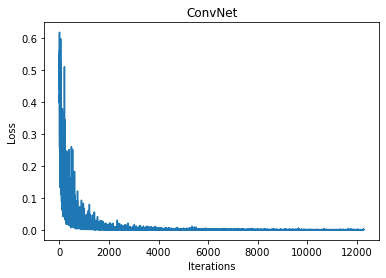

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Sequential(
    (0): Linear(in_features=4096, out_features=128, bias=True)
    (1): ReLU()
  )
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [14]:
# Verify ConvNet
net = ConvNet()
net = net.to(device)

# Hyperparameters
num_epochs = 1024
learning_rate = 0.0001
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
#optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

convnet_train_losses = []
          
for epoch in range(1024):
    train(epoch, train_generator, convnet_train_losses)

import matplotlib.pyplot as plt
plt.plot(convnet_train_losses)
plt.title('ConvNet')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

#Saving the model as a state dictionary
state = {
    'net_dict': net.state_dict()
}
torch.save(state, 'ConvNet.pkl')

print (net)

In [15]:
# Validation
correct = 0.0
total = 0.0
for x in val_generator:
    images, labels = x
    images = images.to(device)
    labels = labels.to(device)
    # Doing the Forward pass
    result = net(images)
    # Coverting the predictions to probabilities, by applying the softmax function
    result_sm = F.softmax(result,dim=1)
    # Finding the prediction with the largest probability
    _,pred = torch.max(result.data,1)
    total += labels.size(0)
    # correct is incremented by the numer of prediction which are correct (equal to the ground truth labels)
    correct += (pred == labels).sum().item()
print("Accuracy of Test Data: {0:.2f}%".format(correct/total *100))

Accuracy of Test Data: 98.10%


In [16]:
# Test with unseen image
classes = {0: 'OTHER', 1: 'RIZWAN'}
net = ConvNet()
state = torch.load('ConvNet.pkl', map_location=device)
net.load_state_dict(state['net_dict'])

def face_detector(face):
    if face is None:
        result = "NO FACE DETECTED"
    else:
        image_transform = transforms.Compose([
                transforms.Resize((32,32)),
                transforms.Grayscale(num_output_channels=1),
                transforms.ToTensor()
                ])
        image = image_transform(face)
        image = torch.unsqueeze(image,0)
        #image = image.to(device)
        prediction = net.forward(image)
        _,output = torch.max(prediction, 1)
        zero_dim_example_tensor = output.to(torch.int)
        label_int = zero_dim_example_tensor.item()
    
        result = classes[label_int]
    
    return result

In [17]:
def detect_extract_faces(path):
    # Detect faces
    image = cv2.imread(path)
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    faces = faceCascade.detectMultiScale(image,scaleFactor=1.3,
                                         minNeighbors=3,
                                         minSize=(30, 30))
    print (f'[INFO] Found {len(faces)} faces')
    
    # Mark detected faces
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.imwrite('faces_detected.jpg', image)
    
    # Extract faces
    extracted_faces = []
    idx = 1
    for (x, y, w, h) in faces:
        roi_color = image[y:y + h, x:x + w]
        face_file = f'face_{str(w)}_{str(h)}_crop_{idx}.jpg'
        face_path = os.path.join(PROCDIR, face_file)
        extracted_faces.append(face_path)
        cv2.imwrite(face_path, roi_color)
        idx += 1
        
    return extracted_faces

In [18]:
def plot_images(face_list, img_array):
    width=8
    height=8
    rows = 4
    cols = 4
    axes=[]
    fig=plt.figure()
    for i in range(rows*cols):
        if i < len(face_list):
            #print (f'{i}:{len(img_array)}')
            axes.append( fig.add_subplot(rows, cols, i+1) )
            subplot_title = (face_list[i])
            axes[-1].set_title(subplot_title)  
            plt.imshow(img_array[i])
        
    fig.tight_layout()
    plt.show()

In [19]:
def plot_marks():
    mimg = cv2.imread('faces_detected.jpg')
    plt.imshow(mimg)
    plt.show()

In [20]:
def detect_face(extracted_faces):
    face_list = []
    img_array = []
    
    for path in extracted_faces:
        # Resize Image
        img = cv2.imread(path)
        resize_img = cv2.resize(img, (32,32))
        img_array.append(resize_img)
        
        # Convert np.array image to PIL
        img_PIL = Image.fromarray(resize_img)
    
        # Detect face
        face_result = face_detector(img_PIL)
        face_list.append(face_result)
    
    # Plot images
    plot_marks()
    plot_images(face_list, img_array)

[INFO] Found 4 faces


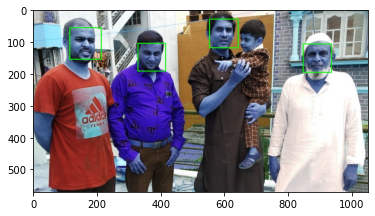

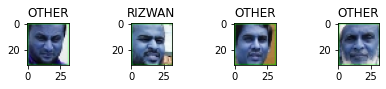

In [22]:
input_path = '/data/codes/aiml/projects_aiml/family_face_detection'
file = 'bakrid2019.jpg'
f = os.path.join(input_path,file)
faces = detect_extract_faces(f)
detect_face(faces)